In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Home_Depot_Case_Study//Workspace_EDA
!pwd

/content/drive/MyDrive/Home_Depot_Case_Study/Workspace_ckpt1
/content/drive/MyDrive/Home_Depot_Case_Study/Workspace_ckpt1


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib_venn import venn2
import regex as re
from collections import Counter
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from collections import Counter
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud, STOPWORDS 
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from scipy.stats import spearmanr

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA 1

In [ ]:
train_df = pd.read_csv("train.csv", encoding='iso-8859-1')
test_df = pd.read_csv("test.csv",encoding='iso-8859-1')

print(train_df.shape)
print(test_df.shape)

train_df.head()

(74067, 5)
(166693, 4)


id  product_uid  ...         search_term relevance
0   2       100001  ...       angle bracket      3.00
1   3       100001  ...           l bracket      2.50
2   9       100002  ...           deck over      3.00
3  16       100005  ...    rain shower head      2.33
4  17       100005  ...  shower only faucet      2.67

[5 rows x 5 columns]

In [ ]:
#Checking for null values 
train_df.isna().sum()

id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

### EDA Relevance Scores 

In [ ]:
train_df['relevance'].value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.25       11
2.75       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

* Relevance Scores are categorical in nature

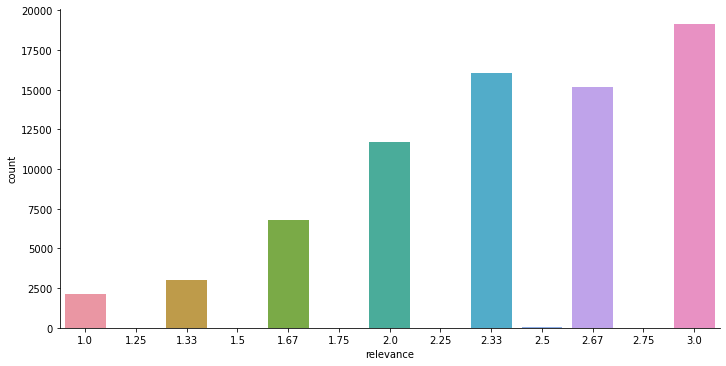

In [ ]:
sns.catplot(x='relevance', kind='count', data=train_df, height=5, aspect=2)
plt.show()

* As the relevance score were average of scores of 3 raters hence we observe scores to be distibuted in such fashion. 
* Majority of product had a high relevance score i.e most of the products are relevant. 
* We will solve this as a regression problem because that will help us in ranking our products easily. 
* This can also be tackled as a classification case in case need be. 
* Scores of 2.50 2.25 2.75 1.75 1.50 1.25 occured in very low frequency hence they might act as outliers and overfit. While modelling, we can remove them and check if the score improve.   

### EDA Product_uid 

max times a product has occured 21
min times a product has occured 1
Total number of unique products 54667



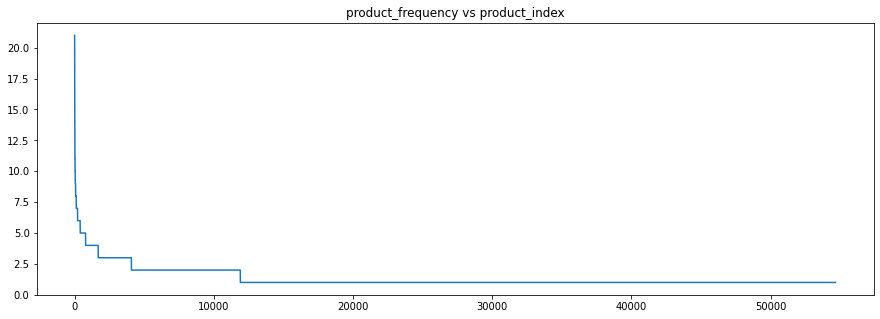

In [ ]:
prod_counts=train_df['product_uid'].value_counts()
print('max times a product has occured', max(prod_counts))
print('min times a product has occured', min(prod_counts))
print('Total number of unique products', len(prod_counts))
print('')

plt.figure(figsize=(15,5))
plt.title('product_frequency vs product_index')
plt.plot(prod_counts.values)
plt.show()

* There are more than 10000 products that occur multiple times i.e we have multiple search queries and corresponding relevance scores for them 

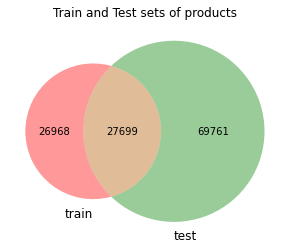

In [ ]:
#https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
set1 = set(train_df['product_uid'].values)
set2 = set(test_df['product_uid'].values)

venn2([set1, set2], ('train', 'test'))
plt.title('Train and Test sets of products')
plt.show()

* About half of the products in train dataset occur in test dataset
* Test dataset has a lot of products which are not seen in the train dataset

**Checking if product_uids have any correlation with relevance scores**

Spearmans correlation between product_uid and relevance class 0.08922860613250413



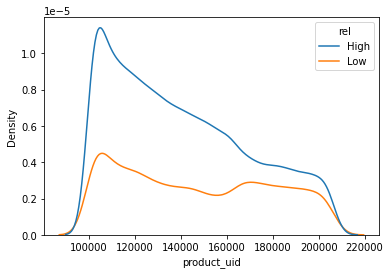

In [ ]:
temp_ = train_df.copy()
temp_['rel'] = temp_['relevance'].apply(lambda x: 'High' if x > 2 else 'Low')

corr, _ = spearmanr(temp_['product_uid'], temp_['rel'])
print('Spearmans correlation between product_uid and relevance class', corr)
print('')

sns.kdeplot(data=temp_, x="product_uid", hue="rel")
plt.plot()
plt.show()

* We have an interesting find that products with smaller user id (100k to 120k) tend to show high relevance scores as compared to products with higher user id value. 
* Using this as a feature doesn't seem very logical and hence we are not going to. But this is something that can be experimented with later. 

### Merging the attributes, description and brand with train dataset

#### Attributes

In [ ]:
attr_df = pd.read_csv("attributes.csv", encoding='iso-8859-1')
attr_df.head()

product_uid      name                                              value
0     100001.0  Bullet01  Versatile connector for various 90Â° connectio...
1     100001.0  Bullet02  Stronger than angled nailing or screw fastenin...
2     100001.0  Bullet03  Help ensure joints are consistently straight a...
3     100001.0  Bullet04              Dimensions: 3 in. x 3 in. x 1-1/2 in.
4     100001.0  Bullet05                           Made from 12-Gauge steel

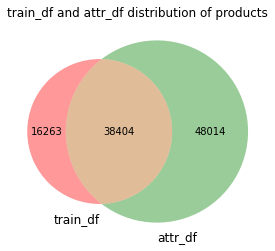

In [ ]:
#https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
set1 = set(train_df['product_uid'].values)
set2 = set(attr_df['product_uid'].values)

venn2([set1, set2], ('train_df', 'attr_df'))
plt.title('train_df and attr_df distribution of products')
plt.show()

* A considerable portion of products in train dataset dont have attributes 

max number of attributes for a single product 88
min number of attributes for a single product 5



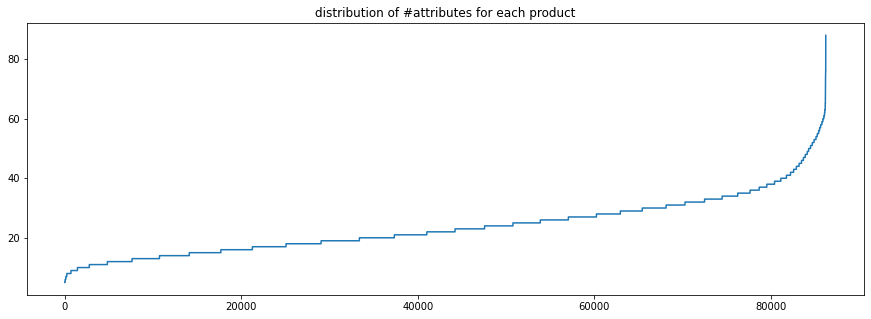

In [ ]:
#distibution of #attributes for each product 
grp_df = attr_df.groupby(['product_uid'])
print('max number of attributes for a single product', grp_df.count()['value'].max())
print('min number of attributes for a single product', grp_df.count()['value'].min())
print('')

plt.figure(figsize=(15,5))
plt.plot(np.sort(grp_df.count()['value']))
plt.title('distribution of #attributes for each product')
plt.show()

* Every product has atleast 5 attributes 
* Most of the products have #attributes less than 40

In [ ]:
#getting the rows with product_uid in train dataset 
train_product_ids = train_df['product_uid'].values
temp = attr_df.loc[attr_df['product_uid'].isin(train_product_ids)]  
temp.shape

(932000, 3)

In [ ]:
#Filling the null values 
print(temp['value'].isna().values.sum())
temp['value'].fillna('',inplace=True)
print(temp['value'].isna().values.sum())

929
0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
temp['name_value'] = temp['name'] + ' ' + temp['value']
temp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


product_uid  ...                                         name_value
0     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
1     100001.0  ...  Bullet02 Stronger than angled nailing or screw...
2     100001.0  ...  Bullet03 Help ensure joints are consistently s...
3     100001.0  ...     Bullet04 Dimensions: 3 in. x 3 in. x 1-1/2 in.
4     100001.0  ...                  Bullet05 Made from 12-Gauge steel

[5 rows x 4 columns]

In [ ]:
temp2 = temp.groupby(['product_uid'])['name_value'].transform(lambda x: ' '.join(x))
temp2

0          Bullet01 Versatile connector for various 90Â° ...
1          Bullet01 Versatile connector for various 90Â° ...
2          Bullet01 Versatile connector for various 90Â° ...
3          Bullet01 Versatile connector for various 90Â° ...
4          Bullet01 Versatile connector for various 90Â° ...
                                 ...                        
1665860    Assembled Depth (in.) .1 in Assembled Height (...
1665861    Assembled Depth (in.) .1 in Assembled Height (...
1665862    Assembled Depth (in.) .1 in Assembled Height (...
1665863    Assembled Depth (in.) .1 in Assembled Height (...
1665864    Assembled Depth (in.) .1 in Assembled Height (...
Name: name_value, Length: 932000, dtype: object

In [ ]:
temp['combined_attr'] = temp2
temp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


product_uid  ...                                      combined_attr
0     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
1     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
2     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
3     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
4     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...

[5 rows x 5 columns]

In [ ]:
temp3 = temp[['product_uid','combined_attr']].drop_duplicates()
temp3.shape

(38404, 2)

In [ ]:
#Adding attributes to the train dataset
train_df = pd.merge(train_df, temp3, on='product_uid', how='left')
print(train_df.shape)
train_df.head()

(74067, 6)


id  ...                                      combined_attr
0   2  ...  Bullet01 Versatile connector for various 90Â° ...
1   3  ...  Bullet01 Versatile connector for various 90Â° ...
2   9  ...  Application Method Brush,Roller,Spray Assemble...
3  16  ...  Bath Faucet Type Combo Tub and Shower Built-in...
4  17  ...  Bath Faucet Type Combo Tub and Shower Built-in...

[5 rows x 6 columns]

#### Adding 'brand' attribute as a seperate feature

In [ ]:
#top 20 most common attribute_names
attr_df['name'].value_counts().head(20)

MFG Brand Name                 86250
Bullet02                       86248
Bullet03                       86226
Bullet04                       86174
Bullet01                       85940
Product Width (in.)            61137
Bullet05                       60529
Product Height (in.)           54698
Product Depth (in.)            53652
Product Weight (lb.)           45175
Bullet06                       44901
Color Family                   41508
Bullet07                       34349
Material                       31500
Color/Finish                   28564
Bullet08                       26645
Certifications and Listings    24583
Bullet09                       20567
Assembled Height (in.)         18299
Assembled Width (in.)          18263
Name: name, dtype: int64

* The most common attribute is the brand of the product and it's very logical that many search queries would contain the brand of the product. Thus, we are adding brand as a seperate feature in our train dataset. 

In [ ]:
temp.head()

product_uid  ...                                      combined_attr
0     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
1     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
2     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
3     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...
4     100001.0  ...  Bullet01 Versatile connector for various 90Â° ...

[5 rows x 5 columns]

In [ ]:
#Adding brand as a feature
brands = temp[temp['name']=='MFG Brand Name']
brands_temp = brands[['product_uid','value']]
train_df = pd.merge(train_df, brands_temp, on='product_uid', how='left')
train_df.head()

id  ...                           value
0   2  ...              Simpson Strong-Tie
1   3  ...              Simpson Strong-Tie
2   9  ...  BEHR Premium Textured DeckOver
3  16  ...                           Delta
4  17  ...                           Delta

[5 rows x 7 columns]

In [ ]:
train_df.shape

(74067, 7)

In [ ]:
train_df.rename(columns = {'value':'brand'}, inplace = True) 
train_df.head()

id  ...                           brand
0   2  ...              Simpson Strong-Tie
1   3  ...              Simpson Strong-Tie
2   9  ...  BEHR Premium Textured DeckOver
3  16  ...                           Delta
4  17  ...                           Delta

[5 rows x 7 columns]

* Notice that the brand is mostly present in the product_title

#### Adding description to the training data 

In [ ]:
desc_df = pd.read_csv('product_descriptions.csv', encoding='iso-8859-1')
desc_df.head()

product_uid                                product_description
0       100001  Not only do angles make joints stronger, they ...
1       100002  BEHR Premium Textured DECKOVER is an innovativ...
2       100003  Classic architecture meets contemporary design...
3       100004  The Grape Solar 265-Watt Polycrystalline PV So...
4       100005  Update your bathroom with the Delta Vero Singl...

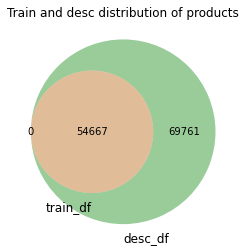

In [ ]:
#https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
set1 = set(train_df['product_uid'].values)
set2 = set(desc_df['product_uid'].values)

venn2([set1, set2], ('train_df', 'desc_df'))
plt.title('Train and desc distribution of products')
plt.show()

* We have descriptions for all the products in the train data 

In [ ]:
train_df = pd.merge(train_df, desc_df, on='product_uid', how='left')
train_df.head()

id  ...                                product_description
0   2  ...  Not only do angles make joints stronger, they ...
1   3  ...  Not only do angles make joints stronger, they ...
2   9  ...  BEHR Premium Textured DECKOVER is an innovativ...
3  16  ...  Update your bathroom with the Delta Vero Singl...
4  17  ...  Update your bathroom with the Delta Vero Singl...

[5 rows x 8 columns]

**DESCRIPTION WORD SEPERATION**

In [ ]:
train_df['product_description'][0]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [ ]:
train_df['product_description'][10000]

'Rustic warmth with a streamlined modern design embodies the Barnside Collection by Home Styles. The remarkable rough hued wire brushed finish exposes the unique grain and accentuates the cozy weathered allure of this charmingly crafted collection. Constructed of mahogany solids and veneers complemented with a weathered aged barnside finish. The King Bed features detailed panels and a plank slat-style design. The Night Stand features a plank slat-style design, one storage drawer with side-mounted metal guides, and one slatted shelf. Set includes King Bed and night stand. Assembly required. Finish and measurements may vary slightly. Size: 78.75 in. W 86.75 in. D 56 in. H. Night Stand Size: 24 in. W 18 in. D 28 in. H.Remarkable rough hued wire brush finishFeatures detailed panels and plank slat-style designHeadboard will accommodate most king/cal king bed framesConstructed of mahogany solids and veneersReady to assemble'

In [ ]:
train_df['product_description'][50000]

'Notify others about a forbidden zone with the Brady 10 in. x 14 in. Plastic Caution Do Not Enter OSHA Safety Sign. Strong black font stands out clearly on the bright yellow background.California residents: see&nbsp;Proposition 65 information1-sidedBlack font on yellow background for visibilityUV-resistant plastic and protected graphics for durabilitySuitable for indoor and outdoor use1-2 year outdoor lifeGreat for light-duty industrial, utility, commercial and institutional environmentsRounded corners with 4 holes for easy mounting'

* Note that the description contains concatenated sentences hence you will observe that last word of one sentence is concatenated with first word of suceeding sentence like strongDimensions and resistanceInstall 
* To correct this, we will be seperating words by the capital letters. 

In [ ]:
#https://stackoverflow.com/questions/42275474/split-string-by-capital-letter-but-ignore-aaa-python-regex
#Here the regex function splits strings by capital letters but it ignores AAA type strings
#Hence'I play fifaI like ESPN' gets split to 'I like fifa I like ESPN'. It doesnt split 'ESPN' into 'E S P N'

train_df['product_description'] = train_df['product_description'].apply(lambda x: ' '.join(re.findall(r'[A-Z]?[^A-Z\s]+|[A-Z]+', x)) )

In [ ]:
train_df['product_description'][50000]

'Notify others about a forbidden zone with the Brady 10 in. x 14 in. Plastic Caution Do Not Enter OSHA Safety Sign. Strong black font stands out clearly on the bright yellow background. California residents: see&nbsp; Proposition 65 information1-sided Black font on yellow background for visibility UV -resistant plastic and protected graphics for durability Suitable for indoor and outdoor use1-2 year outdoor life Great for light-duty industrial, utility, commercial and institutional environments Rounded corners with 4 holes for easy mounting'

### Filling Null Values

In [ ]:
train_df.drop('id',inplace=True, axis=1)
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))

product_uid has 0 null values
product_title has 0 null values
search_term has 0 null values
relevance has 0 null values
combined_attr has 17520 null values
brand has 17531 null values
product_description has 0 null values


* We have a lot of rows with null values. These null values come from the combined_attr and brand

**FILLING NULL VALS FOR BRAND**

* The brand feature has been derived from the title in most cases so for the missing values we can take help of the title

In [ ]:
unique_brands = np.unique(train_df['brand'].dropna().values)
print('Number of unique brands', len(unique_brands))

Number of unique brands 3143


In [ ]:
#Length of brand name
lengths = train_df['brand'].dropna().apply(lambda x: len(x.split()))
lengths.value_counts()

1    35032
2    15918
3     5001
4      424
0       97
5       33
6       31
Name: brand, dtype: int64

In [ ]:
train_df[train_df['brand'].isnull()][:5]

product_uid  ...                                product_description
198       100109  ...  A lightweight and steerable Never Loses Suctio...
199       100109  ...  A lightweight and steerable Never Loses Suctio...
219       100124  ...  The Champion Power Equipment 16590 gasoline po...
302       100160  ...  The DEWALT DCK 940 D2 combo kit is ideal for j...
881       100490  ...  The Milwaukee Hole Dozer Bi- Metal Hole Saw fe...

[5 rows x 7 columns]

In [ ]:
train_df[train_df['brand']=='Shark'][:5]

product_uid  ...                                product_description
134        100069  ...  The Shark Rotator Slim- Light Lift- Away is an...
850        100471  ...  The Shark Rotator Professional Lift- Away is a...
851        100471  ...  The Shark Rotator Professional Lift- Away is a...
1963       101044  ...  The Shark Professional Steam Pocket Mop featur...
1964       101044  ...  The Shark Professional Steam Pocket Mop featur...

[5 rows x 7 columns]

In [ ]:
null_df = train_df[train_df['brand'].isnull()]
notnull_df = train_df.dropna()

In [ ]:
def first_n(n, sent):
  if n > len(sent.split()):
    return 'error101'
  return ' '.join(sent.split()[:n])

* We will be looking at first 4 words in title and then match if it in the unique_brands list. If it is then thats our brand, if its not then we will check for first 3 words and then so on. 

In [ ]:
for i, row in null_df.iterrows():
  title = row['product_title']
  if first_n(4, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(4, title)
  elif first_n(3, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(3, title)
  elif first_n(2, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(2, title)
  elif first_n(1, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(1, title)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/loc

In [ ]:
null_df['brand'].isna().values.sum()

2528

* So after performing, we still have about 2.5K null values. This happens cause brands like Novolink, CELIMA, etc are not in the unique brands list. For them we are putting brand as the first word in the title as most brands have a length of 1

In [ ]:
#Notice the change in code - else instead of elif
for i, row in null_df.iterrows():
  title = row['product_title']
  if first_n(4, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(4, title)
  elif first_n(3, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(3, title)
  elif first_n(2, title) in unique_brands:
    null_df['brand'].loc[i] = first_n(2, title)
  else:
    null_df['brand'].loc[i] = first_n(1, title)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impor

In [ ]:
null_df['brand'].isna().values.sum()

0

In [ ]:
train_df['brand'].loc[null_df.index] = null_df['brand'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))

product_uid has 0 null values
product_title has 0 null values
search_term has 0 null values
relevance has 0 null values
combined_attr has 17520 null values
brand has 0 null values
product_description has 0 null values


**FILLING ATTRIBUTES NA VALUES**

* For attributes we will be filling the missing values from description as we will see both attributes and description text are very similar

In [ ]:
null_df = train_df[train_df['combined_attr'].isnull()]

In [ ]:
null_df['combined_attr'] = null_df['product_description'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_df['combined_attr'].loc[null_df.index] = null_df['combined_attr'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))

product_uid has 0 null values
product_title has 0 null values
search_term has 0 null values
relevance has 0 null values
combined_attr has 0 null values
brand has 0 null values
product_description has 0 null values


### Comparing product_description and combined_attr features

In [ ]:
train_df['product_description'][4] 

'Update your bathroom with the Delta Vero Single- Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The Multi Choice universal valve keeps the water temperature within +/-3 degrees Fahrenheit to help prevent scalding. California residents: see&nbsp; Proposition 65 information Includes the trim kit only, the rough-in kit ( R10000- UNBX ) is sold separately Includes the handle Maintains a balanced pressure of hot and cold water even when a valve is turned on or off elsewhere in the system Due to Water Sense regulations in the state of New York, please confirm your shipping zip code is not restricted from use of items that do not meet Water Sense qualifications'

In [ ]:
train_df['combined_attr'][4]

'Bath Faucet Type Combo Tub and Shower Built-in Water Filter No Bullet01 Includes the trim kit only, the rough-in kit (R10000-UNBX) is sold separately Bullet02 Includes the handle Bullet03 Maintains a balanced pressure of hot and cold water even when a valve is turned on or off elsewhere in the system Bullet04 Due to WaterSense regulations in the state of New York, please confirm your shipping zip code is not restricted from use of items that do not meet WaterSense qualifications Certifications and Listings ADA Compliant,CSA Certified,IAPMO Certified Color Family Chrome Color/Finish Chrome Connection size (in.) 1/2 In. Faucet Features No Additional Features Faucet Included Components Handles,Pressure Balance/Scald Guard Faucet type Bath Faucet Flow rate (gallons per minute) 2.5 Handle type Lever MFG Brand Name Delta Number of Faucet Handles Single Handle Number of showerheads 1 Number of Spray Settings 1 Product Depth (in.) 15.28 Product Height (in.) 24 Product Width (in.) 7.09 Showerh

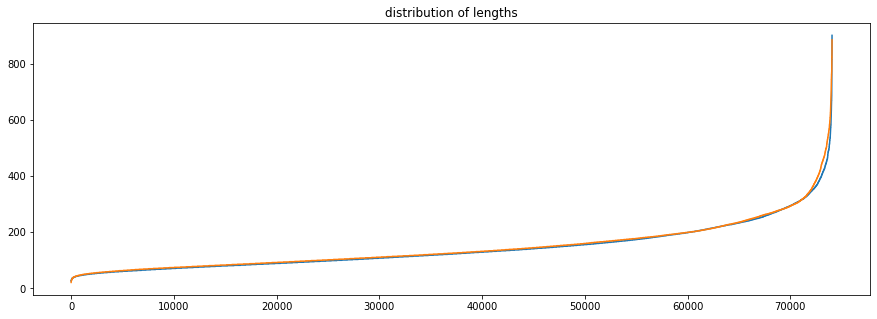

In [ ]:
temp_df = train_df[['combined_attr','product_description']]
len_desc = temp_df['product_description'].apply(lambda x : len(x.split()))
len_attr = temp_df['combined_attr'].apply(lambda x : len(x.split()))

plt.figure(figsize=(15,5))
plt.plot(np.sort(len_desc.values))
plt.plot(np.sort(len_attr.values))
plt.title('distribution of lengths')
plt.show()

* On close inspection we see that product description and Combined_attr are very similar texts. We will explore them more after data cleaning.


# Cleaning of Text Data

In [ ]:
train_df.head()

product_uid  ...                                product_description
0       100001  ...  Not only do angles make joints stronger, they ...
1       100001  ...  Not only do angles make joints stronger, they ...
2       100002  ...  BEHR Premium Textured DECKOVER is an innovativ...
3       100005  ...  Update your bathroom with the Delta Vero Singl...
4       100005  ...  Update your bathroom with the Delta Vero Singl...

[5 rows x 7 columns]

In [ ]:
def unit_counts(column):
  words = ' '.join(train_df[column].unique()).split()
  units = ['feet', 'foot','ft.','fathom', 'fm','fm.','inches', 'inchs','in', 'inch','in.', 'centi','cm.' ,'yd.', 'yd','yard', 'yds',
          'ac', 'ac.' , 'acre', 'sq', 'square', 'sq.', 'lb', 'lb.','lbs', 'pound', 'pounds','oz', 'ozs', 'ounce', 'ounces', 'oz.',
          'g', 'gram', 'gr', 'mg', 'st', 'st.', 'stone', 'kg', 'tsp', 'g.', 'tbsp', 'qt', 'ml', 'ml.', 'l',  'l', 'litre','pt', 
          'pt.', 'gal', 'gals', 'gallon', 'gallons','galons', 'gals.','gal.', 'mph', 'cal', 'kn','metre', 'm', 'cm', 'km']
  counts = {}
  for unit in units:
    cnt = list(words).count(unit)
    counts[unit] = cnt
  return counts

In [ ]:
print(unit_counts('product_description'))
print(unit_counts('combined_attr'))
print(unit_counts('product_title'))
print(unit_counts('search_term'))

{'feet': 963, 'foot': 1097, 'ft.': 17173, 'fathom': 0, 'fm': 0, 'fm.': 0, 'inches': 196, 'inchs': 0, 'in': 70808, 'inch': 402, 'in.': 84645, 'centi': 0, 'cm.': 0, 'yd.': 10, 'yd': 15, 'yard': 680, 'yds': 0, 'ac': 5, 'ac.': 0, 'acre': 27, 'sq': 29, 'square': 2191, 'sq.': 3908, 'lb': 214, 'lb.': 2777, 'lbs': 94, 'pound': 34, 'pounds': 72, 'oz': 22, 'ozs': 0, 'ounce': 26, 'ounces': 20, 'oz.': 1515, 'g': 30, 'gram': 18, 'gr': 0, 'mg': 5, 'st': 2, 'st.': 0, 'stone': 1869, 'kg': 12, 'tsp': 0, 'g.': 2, 'tbsp': 0, 'qt': 2, 'ml': 33, 'ml.': 2, 'l': 87, 'litre': 0, 'pt': 3, 'pt.': 43, 'gal': 4, 'gals': 2, 'gallon': 282, 'gallons': 188, 'galons': 0, 'gals.': 1, 'gal.': 818, 'mph': 158, 'cal': 0, 'kn': 1, 'metre': 0, 'm': 159, 'cm': 127, 'km': 0}
{'feet': 827, 'foot': 923, 'ft.': 13005, 'fathom': 0, 'fm': 0, 'fm.': 0, 'inches': 164, 'inchs': 0, 'in': 86768, 'inch': 262, 'in.': 68481, 'centi': 0, 'cm.': 0, 'yd.': 5, 'yd': 14, 'yard': 411, 'yds': 0, 'ac': 5, 'ac.': 0, 'acre': 18, 'sq': 38, 'square':

* In lots of product_title, dimensions of products are mentioned. A very common way of representing them is like '8 ft. x 5 ft. x 8 ft.' with whitespaces in between. The same is observed in product_description.
* In product_title units are mostly represented as (in.  lb.  sq.  lb.  oz. gal. mph) but in product_description and search_term units are represented in multiple ways for example inch as (in.  in  inches) and gallons as (gal. gals gallon), feet as (ft. feet foot ft) hence these need to be standardized.
* Also, in search terms, there were some common errors when specifying measurements. Some examples are '4shelves', '9x12', 'g135', '5gal', '1/2 in by 12'. Hence we need to seperate numbers from letters. 

**CLEANING**
1. Seperate numbers from words: "9x12" -> "9 x 12" , "5gal" -> "5 gal" ...
2. Bring all units of measurements to a consistent representation.

In [ ]:
#https://www.geeksforgeeks.org/python-add-space-between-numbers-and-alphabets-in-string/

#We are not including units (ft. lb. sq. ...) as the full stop will be taken care by 
#the re.split(r'\W+', sent) function in the preprocessing function

#In description and title, 'inch' is generally found as 'in.' where as in search_term,
#its found both as 'in' and 'in.' thus we deal with both cases seperately. Thus a seperate 
#preprocessing function for search terms

#we are not using stemming and stopwords now. We will be stemming after correction of search terms

#'in.','in' to inch is taken care of in preprocessing step
#'inches' to inch will be taken care in stemming. And anyhow 'inches' is not used a lot
def standardize_units(text):
  text = " " + text + " "
  text = re.sub('( gal | gals | galon )',' gallon ',text)
  text = re.sub('( ft | fts | feets | foot | foots )',' feet ',text)
  text = re.sub('( squares | sq )',' square ',text)
  text = re.sub('( lb | lbs | pounds )',' pound ',text)
  text = re.sub('( oz | ozs | ounces | ounc )',' ounce ',text)
  text = re.sub('( yds | yd | yards )',' yard ',text)
  return text

def preprocessing(sent):
  sent = sent.replace('in.', ' inch ') #If we dont to this then 'in.' will be turned to 'in' in the next step
  words = re.split(r'\W+', sent)
  words = [word.lower() for word in words]
  res = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", ' '.join(words)) #add space between number and alphabets in a string
  cleaned = standardize_units(res) 
  cleaned = ' '.join(cleaned.split()) #removing extra whitespaces
  return cleaned

def preprocessing_search(sent):
  sent = sent.replace('in.', ' inch ')
  words = re.split(r'\W+', sent)
  words = [word.lower() for word in words]
  res = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", ' '.join(words)) #add space between number and alphabets in a string
  res = standardize_units(res) 
  res = res.replace(' in ', ' inch ') #in search_terms 'in' is used more for 'inch' than as a preposition hence this step shouldn't hurt
  cleaned = ' '.join(res.split()) #removing extra whitespaces
  return cleaned

In [ ]:
train_df['cleaned_title'] = train_df['product_title'].apply(lambda x : preprocessing(x))
train_df['cleaned_brand'] = train_df['brand'].apply(lambda x : preprocessing(x))
train_df['cleaned_description'] = train_df['product_description'].apply(lambda x : preprocessing(x))
train_df['cleaned_attributes'] = train_df['combined_attr'].apply(lambda x : preprocessing(x))

#preprocessing for search is implemented in a slight different manner 
train_df['cleaned_search'] = train_df['search_term'].apply(lambda x : preprocessing_search(x))
train_df.head()

product_uid  ...      cleaned_search
0       100001  ...       angle bracket
1       100001  ...           l bracket
2       100002  ...           deck over
3       100005  ...    rain shower head
4       100005  ...  shower only faucet

[5 rows x 12 columns]

### Correcting Search Term

* Through literature survey, we found that search_term has a lot of typos hence we will be using a custom spelling corrector to correct the misspelled terms. The code we use is given by Peter Norvig http://norvig.com/spell-correct.html
* Another approach was using google's spelling corrector - https://www.kaggle.com/steubk/fixing-typos . But this was not allowed in the kaggle competetion.  


In [ ]:
print(train_df['cleaned_search'][12])
print(train_df['cleaned_search'][68])
print(train_df['cleaned_search'][112])

gas mowe
american standard bone round toliet
glaciar bay toiled


In [ ]:
corpus = train_df['cleaned_title'] + " "  + train_df['cleaned_brand'] + " " + train_df['cleaned_description'] + " " + train_df['cleaned_attributes']
stp_wrds = set(stopwords.words('english'))

#removing stopwords
def stop_word_removal(sent):
  words = sent.split()
  words = [w for w in words if not w in stp_wrds]
  return ' '.join(words)
corpus = corpus.apply(lambda x : stop_word_removal(x)) 
np.savetxt(r'preprocessing/corpus.txt', corpus.values, fmt='%s')

In [ ]:
#http://norvig.com/spell-correct.html
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('preprocessing/corpus.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or set([word]))
    

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
  

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def corrected_term(term):
  temp = term.lower().split()
  temp = [correction(word) for word in temp]
  return ' '.join(temp)

In [ ]:
#testing
typos = ['steele stake',
        'gas mowe',
        'metal plate cover gcfi',
        'lawn sprkinler',
        'ourdoor patio tile',
        '6 teir shelving',
        'storage shelve',
        'American Standard Bone round toliet',
        '6 stell',
        'fece posts metal',
        'cushions outdoorlounge',
        'pricepfister kitchen faucet g135',
        'glaciar bay toiled',
        'glacie bay dual flush',
        'glacier bay tiolet tank lid',
        'handycap toilets',
        'high boy tolet',
        'gas wayer heaters',
        'basemetnt window',
        'rustollum epoxy',
        'air /heaterconditioner window',
        'spliter ac unit',
        'berh deck over',
        '28 snow thower',
        'base board molding boundle',
        '1 infloor flange',
        '10 window sping rod',
        'combo powertool kit',
        'desalt impact 18',
        'rigid lithium ion batteries fuego drill',
        'fiberglass repir kit',
        'portable air condtioners',
        'wall pannels',
        '2X4 SRUDS',
        'frostking window shrink film',
        'Florescent Light Bulbs',
        'violet flourescent light',
        'lawn mower- electic',
        'closetmade',
        'greecianmarble floor tile',
        'join compound wall tile',
        'montagnia contina floor tile',
        'porcelin floor tile 6x24',
        'three wayy',
        'incide wall heater',
        'westminster pedistal combo',
        'water softners',
        'miricale',
        'sliding windos locks',
        '20v dewalt kombo',
        'DEWALT VACCUM',
        'lithium 20 dewalt',
        'water heather',
        'riobi blower vac 9056',
        'DRAWEER PULLS',
        'bagged cinder mulch',
        ]

for typo in typos:
  print(typo, '-->', corrected_term(typo))

steele stake --> steel stake
gas mowe --> gas mower
metal plate cover gcfi --> metal plate cover gcfi
lawn sprkinler --> lawn sprinkler
ourdoor patio tile --> outdoor patio tile
6 teir shelving --> 6 tier shelving
storage shelve --> storage shelve
American Standard Bone round toliet --> american standard bone round toilet
6 stell --> 6 stell
fece posts metal --> fence posts metal
cushions outdoorlounge --> cushions outdoorlounge
pricepfister kitchen faucet g135 --> pricepfister kitchen faucet 135
glaciar bay toiled --> glacier bay toiled
glacie bay dual flush --> glacier bay dual flush
glacier bay tiolet tank lid --> glacier bay toilet tank lid
handycap toilets --> handicap toilets
high boy tolet --> high boy toilet
gas wayer heaters --> gas water heaters
basemetnt window --> basement window
rustollum epoxy --> rustoleum epoxy
air /heaterconditioner window --> air /heaterconditioner window
spliter ac unit --> splinter ac unit
berh deck over --> behr deck oven
28 snow thower --> 28 snow

* Its working decently. Some words like toiled, heather, wayy dont get corrected because they appear in the corpus text (there are a few spelling mistakes even in the official doc fields) and as the words which are in the corpus dont corrected hence the issue. 
* One way to rectify this would be to remove the words from the corpus which occur very less frequently. This is something which we will experiment later. 
* For now we will also keep raw search

In [ ]:
train_df['corrected_search'] = train_df['cleaned_search'].apply(lambda x: corrected_term(x))
print(train_df.shape)
train_df.head()

(74067, 13)


product_uid  ...    corrected_search
0       100001  ...       angle bracket
1       100001  ...           l bracket
2       100002  ...           deck oven
3       100005  ...    rain shower head
4       100005  ...  shower oily faucet

[5 rows x 13 columns]

### Further Cleaning

In [ ]:
#stop word removal and stemming
#We didn't do this before because we wanted to fix the typos in the searh term first 
porter = PorterStemmer()

stop_words = set(stopwords.words('english'))

def futher_preprocessing(sent):
  words = sent.split()
  words = [w for w in words if not w in stop_words]
  words = [porter.stem(word) for word in words]
  return ' '.join(words)

#storing the final data in a new dataframe 'cleaned_df' 
cleaned_df = pd.DataFrame() 
cleaned_df['title'] = train_df['cleaned_title'].apply(lambda x : futher_preprocessing(x)) 
cleaned_df['brand'] = train_df['cleaned_brand'].apply(lambda x : futher_preprocessing(x)) 
cleaned_df['description'] = train_df['cleaned_description'].apply(lambda x : futher_preprocessing(x)) 
cleaned_df['attributes'] = train_df['cleaned_attributes'].apply(lambda x : futher_preprocessing(x)) 
cleaned_df['search'] = train_df['cleaned_search'].apply(lambda x : futher_preprocessing(x)) 
cleaned_df['corrected_search'] = train_df['corrected_search'].apply(lambda x : futher_preprocessing(x)) 
cleaned_df['relevance'] = train_df['relevance']

cleaned_df.head()

title  ... relevance
0                    simpson strong tie 12 gaug angl  ...      3.00
1                    simpson strong tie 12 gaug angl  ...      2.50
2  behr premium textur deckov 1 gallon sc 141 tug...  ...      3.00
3  delta vero 1 handl shower faucet trim kit chro...  ...      2.33
4  delta vero 1 handl shower faucet trim kit chro...  ...      2.67

[5 rows x 7 columns]

* We create another dataframe cleaned_df2 with no stemming

In [ ]:
#stop word removal only - no stemming

stop_words = set(stopwords.words('english'))

def stop_word_removal(sent):
  words = sent.split()
  words = [w for w in words if not w in stop_words]
  return ' '.join(words)

cleaned_df2 = pd.DataFrame()
cleaned_df2['title'] = train_df['cleaned_title'].apply(lambda x : stop_word_removal(x)) 
cleaned_df2['brand'] = train_df['cleaned_brand'].apply(lambda x : stop_word_removal(x)) 
cleaned_df2['description'] = train_df['cleaned_description'].apply(lambda x : stop_word_removal(x))
cleaned_df2['attributes'] = train_df['cleaned_attributes'].apply(lambda x : stop_word_removal(x)) 
cleaned_df2['search'] = train_df['cleaned_search'].apply(lambda x : stop_word_removal(x)) 
cleaned_df2['corrected_search'] = train_df['corrected_search'].apply(lambda x : stop_word_removal(x)) 
cleaned_df2['relevance'] = train_df['relevance']

cleaned_df2.head()

title  ... relevance
0                  simpson strong tie 12 gauge angle  ...      3.00
1                  simpson strong tie 12 gauge angle  ...      2.50
2  behr premium textured deckover 1 gallon sc 141...  ...      3.00
3  delta vero 1 handle shower faucet trim kit chr...  ...      2.33
4  delta vero 1 handle shower faucet trim kit chr...  ...      2.67

[5 rows x 7 columns]

* A few (about 20) search terms contained only 'To' and 'or' which were removed as stopwords. Hence we are removing those rows. 

In [ ]:
cleaned_df = cleaned_df[cleaned_df['search'] != '']
cleaned_df = cleaned_df[cleaned_df['corrected_search'] != '']

cleaned_df2 = cleaned_df2[cleaned_df2['search'] != '']
cleaned_df2 = cleaned_df2[cleaned_df2['corrected_search'] != '']

**REPLACING EMPTY STRINGS**

* Brand feature some empty strings. This could have happened while we were removing stop words as some brands had the first word of title. This can cause problem when we store the file hence we are replacing them.

In [ ]:
for col in cleaned_df.columns:
  print(col)
  print(cleaned_df[cleaned_df[col]==''])
  print('='*100)

title
Empty DataFrame
Columns: [title, brand, description, attributes, search, corrected_search, relevance]
Index: []
brand
                                                   title  ... relevance
578    5 step pressur treat cedar tone pine stair str...  ...      3.00
579    5 step pressur treat cedar tone pine stair str...  ...      1.67
3036   3 step pressur treat cedar tone pine stair str...  ...      1.67
4065   1 8 inch x 48 inch x 96 inch copper mountain p...  ...      2.33
9926          homestead 6 feet unfinish cap shelf mantel  ...      2.33
...                                                  ...  ...       ...
69204         devonshir 6 feet unfinish cap shelf mantel  ...      2.33
70215               19 inch jolli santa luminari potteri  ...      2.33
70238          abingdon 6 feet unfinish cap shelf mantel  ...      2.00
70278             19 inch jolli snowman luminari potteri  ...      1.67
72498                             snow woman bird feeder  ...      1.00

[146 rows x

In [ ]:
cleaned_df['brand'] = cleaned_df['brand'].replace(to_replace =[""], 
                            value ="missing_brand")

cleaned_df2['brand'] = cleaned_df2['brand'].replace(to_replace =[""], 
                            value ="missing_brand")

**REMOVING 'bullet' STRINGS FROM 'description' FIELD**

* The description field is basically the attributes fields and the attributes fields has a lot of of strings 'bullet' as the name of the attribute but which is not usefull and can be removed

In [ ]:
cleaned_df['description'] = cleaned_df['description'].apply(lambda x: re.sub('bullet \d\d ', '', x))
cleaned_df2['description'] = cleaned_df2['description'].apply(lambda x: re.sub('bullet \d\d ', '', x))

#Renaming 'search' as 'raw_search' and storing the dataframe
cleaned_df.rename(columns={"search": "raw_search"}, inplace=True)
cleaned_df2.rename(columns={"search": "raw_search"}, inplace=True)

**SAVING THE DATAFRAMES**

In [ ]:
cleaned_df.to_csv('cleaned_df.csv', index=False)
cleaned_df2.to_csv('cleaned_df2.csv', index=False)

# EDA 2

**NOTE**

For analysis, we are seperating relevance scores into 2 classes 'High' (score>2) and 'Low' (Score<=2).

In [ ]:
#creating a new df for eda
cleaned_df = pd.read_csv('cleaned_df.csv')
eda_df = cleaned_df.copy()

#we are dropping the relevance scores which occur very less in the data 
#so that we can treat the remaining 9 relevance scores as categorical variables
rem = [1.25, 1.50, 1.75, 2.75, 2.25, 2.50]
eda_df.drop(eda_df[eda_df['relevance'].isin(rem)].index, inplace = True)

#creating a class with sorting relevance scores into 2 categories high and low
eda_df['class'] = eda_df['relevance'].apply(lambda x: 'High' if x>2.0 else 'Low')
eda_df.head()

title  ... class
0                    simpson strong tie 12 gaug angl  ...  High
2  behr premium textur deckov 1 gallon sc 141 tug...  ...  High
3  delta vero 1 handl shower faucet trim kit chro...  ...  High
4  delta vero 1 handl shower faucet trim kit chro...  ...  High
5  whirlpool 1 9 cu feet rang convect microwav st...  ...  High

[5 rows x 8 columns]

### Search

**BASIC STATISTICS**

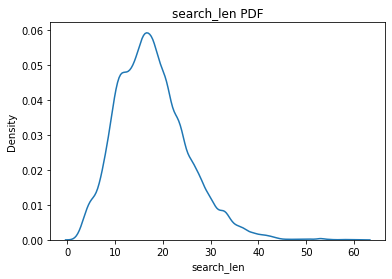

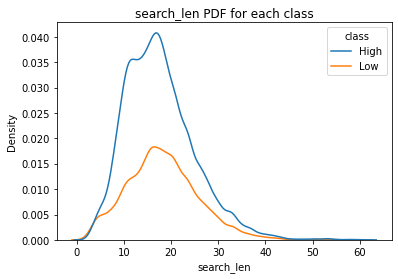

In [ ]:
eda_df['search_len'] = eda_df['corrected_search'].str.len()
sns.kdeplot(data=eda_df, x="search_len")
plt.title('search_len PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="search_len", hue="class")
plt.title('search_len PDF for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['search_len'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.092


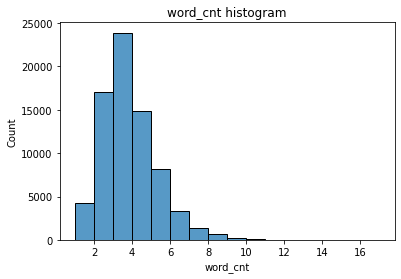

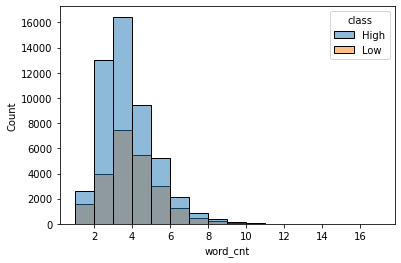

In [ ]:
eda_df['word_cnt'] = eda_df['corrected_search'].apply(lambda x: len(x.split()))
sns.histplot(data=eda_df, x="word_cnt", binwidth=1)
plt.title('word_cnt histogram')
plt.show()
print('')
sns.histplot(data=eda_df, x="word_cnt", hue="class", binwidth=1)
plt.show('word_cnt histogram for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['word_cnt'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.130


* Most search queries are have length between 2 to 5 words. Most common length in both positive and negative class is 3
* The distribution is very similar for both positive and negative class
* As we move towards the right, the ratio of positive to negative class starts decreasing or we can say that negative class starts becoming more prominent. That means as word_cnt increases, the probability of relevance being High decreases. 
* And the above statement can be justified by looking at the correlation score. There is a little correlation and negative in nature. 
* So word_cnt might not be that bad a feature 

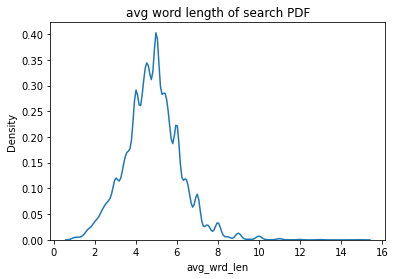

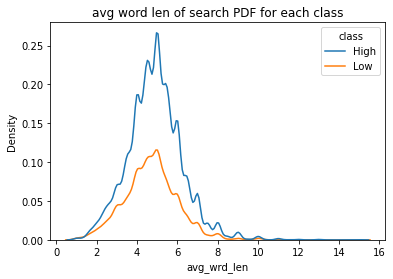

In [ ]:
eda_df['avg_wrd_len'] = eda_df['corrected_search'].apply(lambda x: [len(i) for i in x.split()]).map(lambda x: np.mean(x))
sns.kdeplot(data=eda_df, x="avg_wrd_len")
plt.title('avg word length of search PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="avg_wrd_len", hue="class")
plt.title('avg word len of search PDF for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['avg_wrd_len'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.084


* search_len and avg_wrd_len have a very low correlation with relevance hence might not be helpful. Whereas word_cnt does have a little correlation which might help

**MOST COMMON UNIGRAMS AND BIGRAMS**

In [ ]:
eda_df_high = eda_df[eda_df['class']=='High']
eda_df_low = eda_df[eda_df['class']=='Low']

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
  
def gen_wordcloud(df):
  comment_words = '' 
    
  # iterate through the csv file 
  for row in df: 
      tokens = row.split() 
      comment_words += " ".join(tokens)+" "  
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  min_font_size = 10).generate(comment_words) 
  # plot the WordCloud image                        
  plt.figure(figsize = (4, 6), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show() 

Word Cloud for whole data


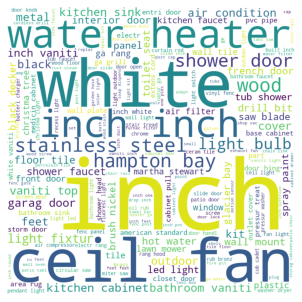

Positive Class


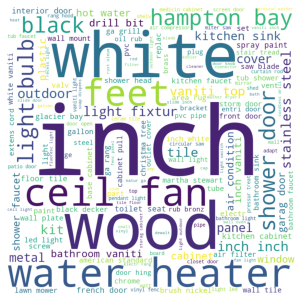

Negative Class


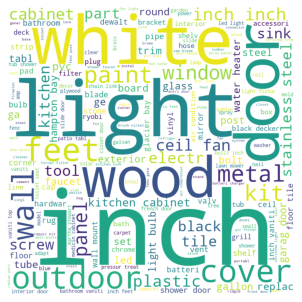

In [ ]:
print('Word Cloud for whole data')
gen_wordcloud(eda_df['corrected_search'])
print('Positive Class')
gen_wordcloud(eda_df_high['corrected_search'])
print('Negative Class')
gen_wordcloud(eda_df_low['corrected_search'])

In [ ]:
corpus=[]
new = eda_df['corrected_search'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

corpus_high=[]
new = eda_df[eda_df['class']=='High']['corrected_search'].str.split()
new = new.values.tolist()
corpus_high=[word for i in new for word in i]

corpus_low=[]
new = eda_df[eda_df['class']=='Low']['corrected_search'].str.split()
new = new.values.tolist()
corpus_low=[word for i in new for word in i]

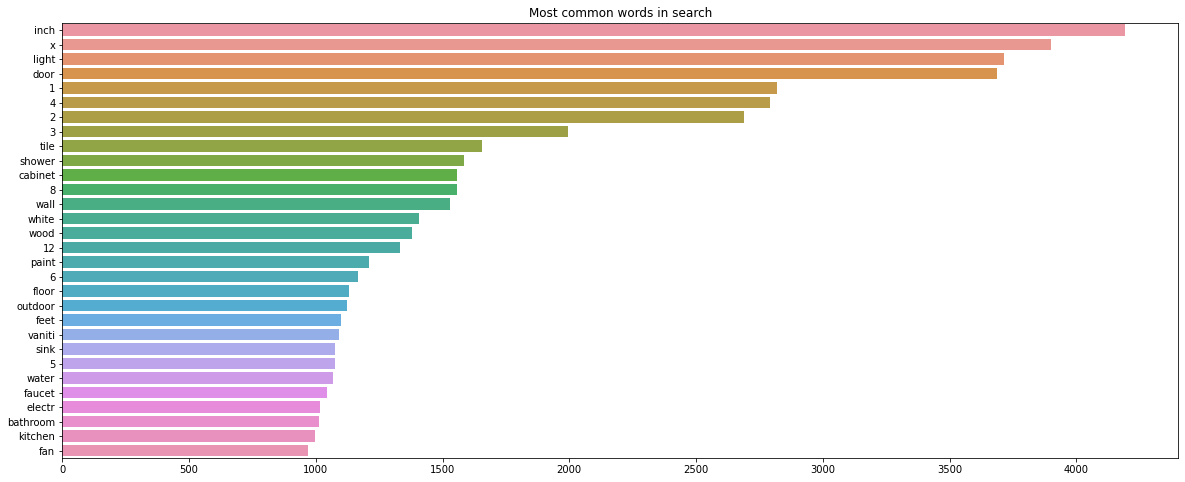

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:30]:
    x.append(word)
    y.append(count)

plt.figure(figsize=(20,8))   
plt.title('Most common words in search')     
sns.barplot(x=y,y=x)
plt.show()

* Inch and x are the most frequent terms. Not only this but a lot of numbers are very frequently occuring. This means that lot of search terms contain the dimensions of the products needed. Hence we didn't remove the numbers while data cleaning.

In [ ]:
counter=Counter(corpus_high)
most=counter.most_common()
pos=[]
for word,count in most[:30]:
    pos.append((word,count))

counter=Counter(corpus_low)
most=counter.most_common()
neg=[]
for word,count in most[:30]:
    neg.append((word,count))

In [ ]:
columns = ['Positive Class', 'Negative Class']
  
myTable = PrettyTable()
  
# Add Columns
myTable.add_column(columns[0], pos)
myTable.add_column(columns[1], neg)
  
print('Most common search terms')
print(myTable)

Most common search terms
+-------------------+------------------+
|   Positive Class  |  Negative Class  |
+-------------------+------------------+
|  ('light', 2774)  |   ('x', 1577)    |
|   ('inch', 2763)  |  ('inch', 1430)  |
|   ('door', 2571)  |  ('door', 1118)  |
|    ('x', 2323)    |   ('1', 1031)    |
|    ('4', 1832)    |   ('2', 1017)    |
|    ('1', 1787)    |    ('4', 958)    |
|    ('2', 1672)    |  ('light', 941)  |
|    ('3', 1306)    |    ('3', 687)    |
|   ('tile', 1232)  |    ('8', 568)    |
|  ('shower', 1196) |  ('wood', 516)   |
| ('cabinet', 1139) |   ('12', 454)    |
|   ('wall', 1086)  |  ('wall', 443)   |
|  ('white', 1032)  |    ('6', 440)    |
|     ('8', 988)    |    ('5', 430)    |
|    ('12', 880)    |  ('tile', 424)   |
|  ('vaniti', 878)  |  ('feet', 423)   |
|   ('wood', 863)   | ('cabinet', 419) |
|   ('sink', 859)   | ('shower', 388)  |
|   ('paint', 828)  |  ('paint', 382)  |
|  ('faucet', 818)  |  ('white', 376)  |
|  ('outdoor', 815) | ('window',

In [ ]:
pos_words = set([x[0] for x in pos])
neg_words = set([x[0] for x in neg])
print('words in pos but not in neg top30')
print(pos_words - neg_words)
print('words in neg but not in pos top30')
print(neg_words - pos_words)

words in pos but not in neg top30
{'fan', 'vaniti', 'led', 'bathroom', 'sink', 'faucet', 'ga'}
words in neg but not in pos top30
{'kit', 'pipe', 'cover', 'feet', 'window', '5', 'panel'}


* Most of the words are common hence this doesnt really give us a lot of information

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Most common bigrams


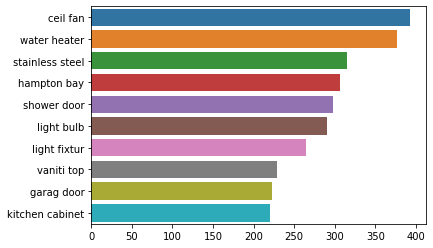

In [ ]:
top_n_bigrams=get_top_ngram(eda_df['corrected_search'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
print('Most common bigrams')
sns.barplot(x=y,y=x)
plt.show()

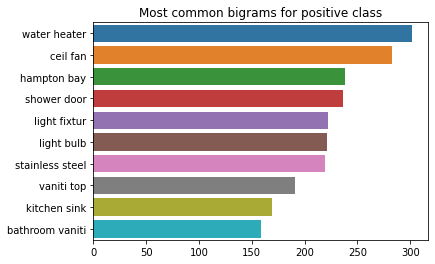

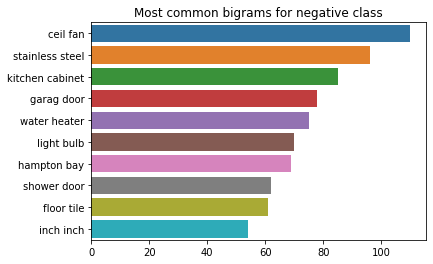

In [ ]:
top_n_bigrams=get_top_ngram(eda_df_high['corrected_search'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Most common bigrams for positive class')
sns.barplot(x=y,y=x)
plt.show()

top_n_bigrams=get_top_ngram(eda_df_low['corrected_search'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Most common bigrams for negative class')
sns.barplot(x=y,y=x)
plt.show()

* Very generally we saw that most both classes have pretty similar most frequent words. Vectorizations like simple BOW or tfidf BOW might not work that well

**SENTIMENT ANALYSIS**

* Just for experimentation purposes we are checking if sentiment analysis and readability scores help in any way

In [ ]:
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

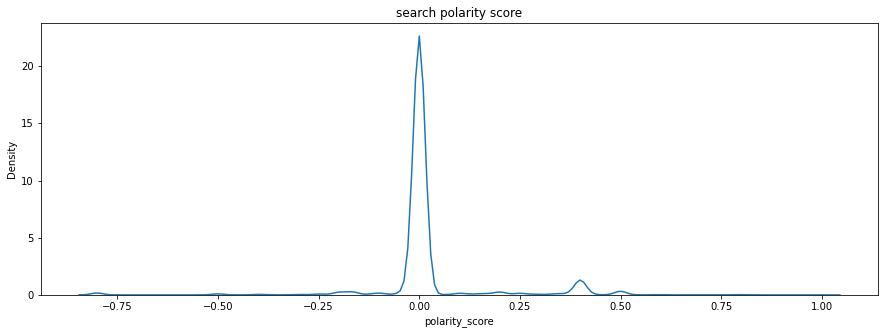

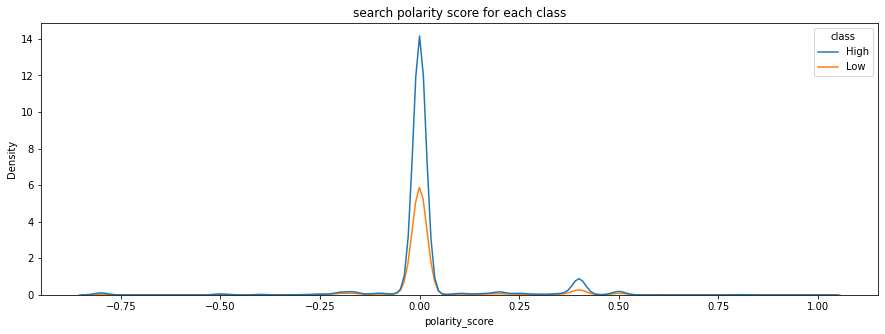

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

eda_df['polarity_score'] = eda_df['corrected_search'].apply(lambda x: polarity(x))
plt.figure(figsize=(15,5))
sns.kdeplot(data=eda_df, x="polarity_score")
plt.title('search polarity score')
plt.show()
print('')
plt.figure(figsize=(15,5))
sns.kdeplot(data=eda_df, x="polarity_score", hue="class")
plt.title('search polarity score for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['polarity_score'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.019


* Most searches have polarity score = 0. Not helpful

**READABILITY INDEX**

In [ ]:
!pip install textstat

     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 1.9MB 18.4MB/s 


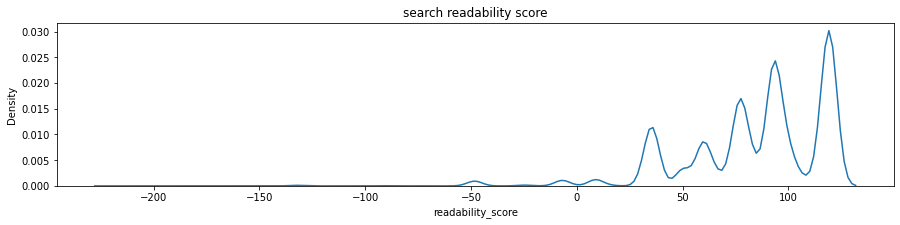

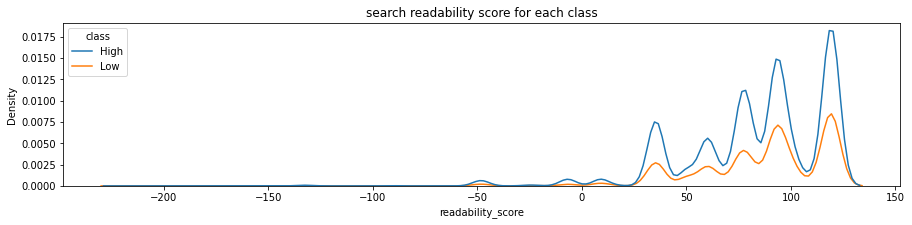

In [ ]:
from textstat import flesch_reading_ease

eda_df['readability_score'] = eda_df['corrected_search'].apply(lambda x: flesch_reading_ease(x))
plt.figure(figsize=(15,3))
sns.kdeplot(data=eda_df, x="readability_score")
plt.title('search readability score')
plt.show()
print('')
plt.figure(figsize=(15,3))
sns.kdeplot(data=eda_df, x="readability_score", hue="class")
plt.title('search readability score for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['readability_score'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.035


* Both sentiment analysis and readability are not helpfull in distinguishing the positive from the negative class

### Description

**BASIC STATISTICS**

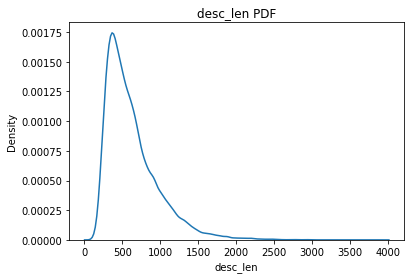

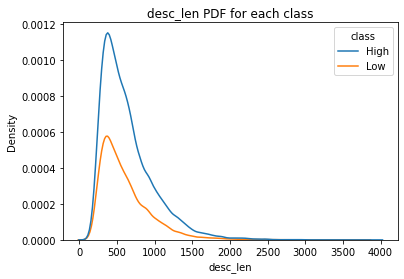

In [ ]:
eda_df['desc_len'] = eda_df['description'].str.len()
sns.kdeplot(data=eda_df, x="desc_len")
plt.title('desc_len PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="desc_len", hue="class")
plt.title('desc_len PDF for each class')
plt.show()

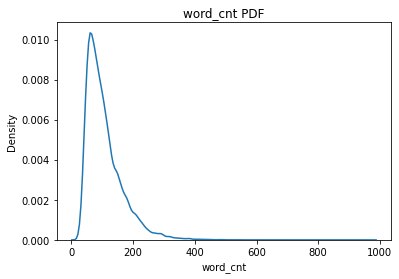

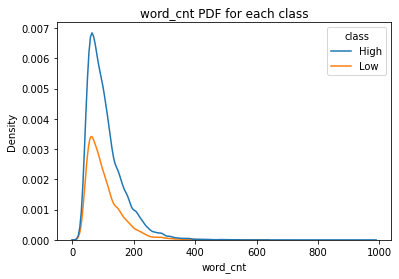

In [ ]:
eda_df['word_cnt'] = eda_df['description'].apply(lambda x: len(x.split()))
sns.kdeplot(data=eda_df, x="word_cnt")
plt.title('word_cnt PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="word_cnt", hue="class")
plt.title('word_cnt PDF for each class')
plt.show()

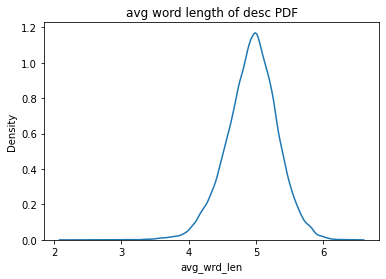

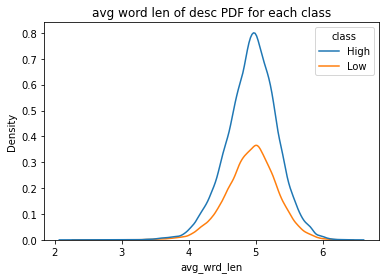

In [ ]:
eda_df['avg_wrd_len'] = eda_df['description'].apply(lambda x: [len(i) for i in x.split()]).map(lambda x: np.mean(x))
sns.kdeplot(data=eda_df, x="avg_wrd_len")
plt.title('avg word length of desc PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="avg_wrd_len", hue="class")
plt.title('avg word len of desc PDF for each class')
plt.show()

**MOST COMMON UNIGRAMS AND BIGRAMS**

In [ ]:
eda_df_high = eda_df[eda_df['class']=='High']
eda_df_low = eda_df[eda_df['class']=='Low']

In [ ]:
corpus=[]
new = eda_df['description'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

corpus_high=[]
new = eda_df[eda_df['class']=='High']['description'].str.split()
new = new.values.tolist()
corpus_high=[word for i in new for word in i]

corpus_low=[]
new = eda_df[eda_df['class']=='Low']['description'].str.split()
new = new.values.tolist()
corpus_low=[word for i in new for word in i]

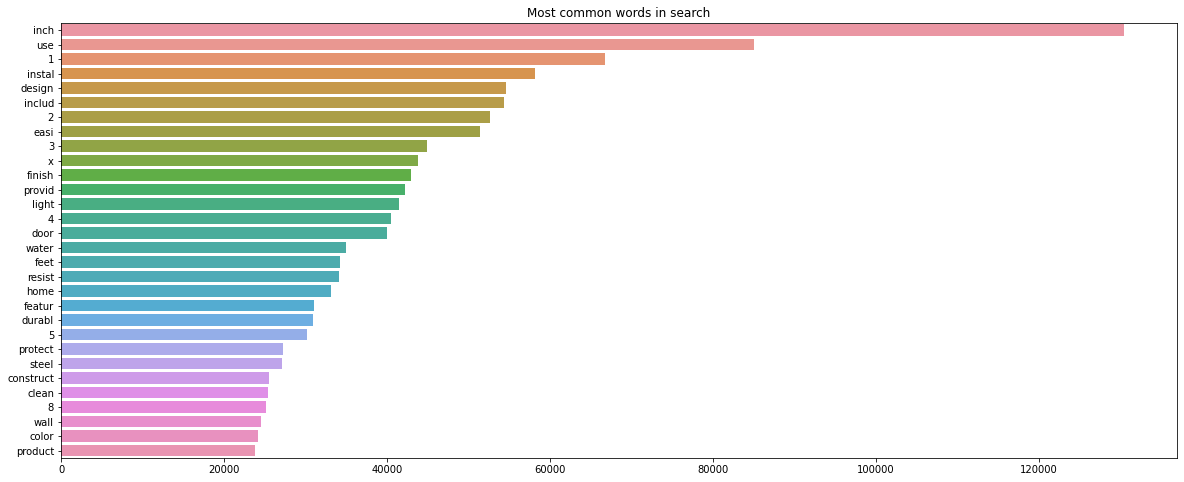

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:30]:
    x.append(word)
    y.append(count)

plt.figure(figsize=(20,8))   
plt.title('Most common words in search')     
sns.barplot(x=y,y=x)
plt.show()

In [ ]:
counter=Counter(corpus_high)
most=counter.most_common()
pos=[]
for word,count in most[:30]:
    pos.append((word,count))

counter=Counter(corpus_low)
most=counter.most_common()
neg=[]
for word,count in most[:30]:
    neg.append((word,count))

In [ ]:
columns = ['Positive Class', 'Negative Class']
  
myTable = PrettyTable()
  
# Add Columns
myTable.add_column(columns[0], pos)
myTable.add_column(columns[1], neg)
  
print('Most common desc terms')
print(myTable)

Most common desc terms
+----------------------+---------------------+
|    Positive Class    |    Negative Class   |
+----------------------+---------------------+
|   ('inch', 89624)    |   ('inch', 40849)   |
|    ('use', 57865)    |    ('use', 27224)   |
|     ('1', 46168)     |     ('1', 20663)    |
|  ('instal', 40038)   |  ('instal', 18103)  |
|  ('includ', 37873)   |  ('design', 16791)  |
|  ('design', 37812)   |  ('includ', 16532)  |
|     ('2', 36659)     |     ('2', 15965)    |
|   ('easi', 35540)    |   ('easi', 15846)   |
|     ('3', 31360)     |     ('x', 13783)    |
|     ('x', 30044)     |     ('3', 13513)    |
|  ('finish', 30001)   |  ('provid', 13002)  |
|   ('light', 29890)   |  ('finish', 12973)  |
|  ('provid', 29251)   |     ('4', 12454)    |
|     ('4', 28075)     |   ('door', 12364)   |
|   ('door', 27698)    |   ('light', 11626)  |
|   ('water', 24182)   |   ('feet', 10811)   |
|   ('feet', 23440)    |  ('resist', 10803)  |
|  ('resist', 23258)   |   ('water', 

In [ ]:
pos_words = set([x[0] for x in pos])
neg_words = set([x[0] for x in neg])
print('words in pos but not in neg top30')
print(pos_words - neg_words)
print('words in neg but not in pos top30')
print(neg_words - pos_words)

words in pos but not in neg top30
set()
words in neg but not in pos top30
set()


In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

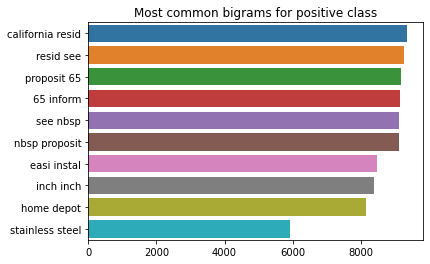

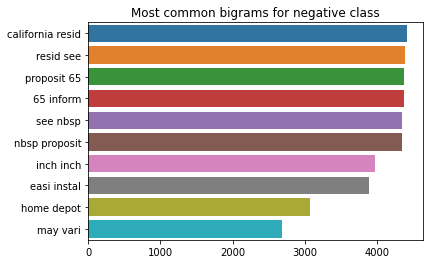

In [ ]:
top_n_bigrams=get_top_ngram(eda_df_high['description'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Most common bigrams for positive class')
sns.barplot(x=y,y=x)
plt.show()

top_n_bigrams=get_top_ngram(eda_df_low['description'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Most common bigrams for negative class')
sns.barplot(x=y,y=x)
plt.show()

* For unigrams set of top30 words for both pos and neg class is exactly the same. Even bigrams are very much similar in their frequencies. 
* So description in itself is a very bad discriminator for both the classes

**Other Experimentations:**

* Readability Scores and Sentiment Polarity scores were also calculated for description but they showed the same trend for both positive and negative class and not helpful.

### Brand

**BASIC STATISTICS**

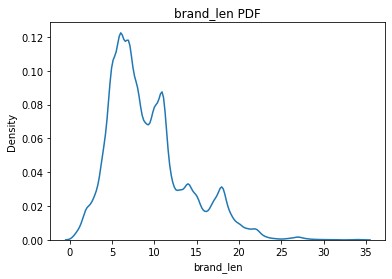

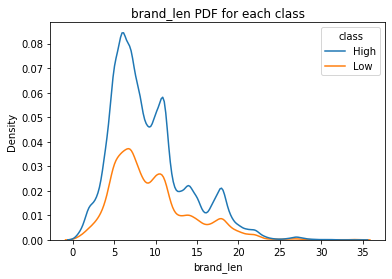

In [ ]:
eda_df['brand_len'] = eda_df['brand'].str.len()
sns.kdeplot(data=eda_df, x="brand_len")
plt.title('brand_len PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="brand_len", hue="class")
plt.title('brand_len PDF for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['brand_len'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.031


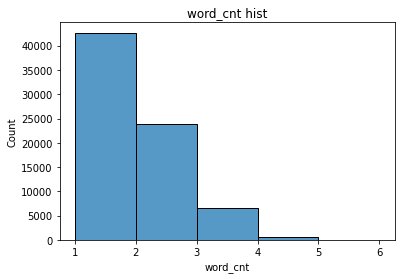

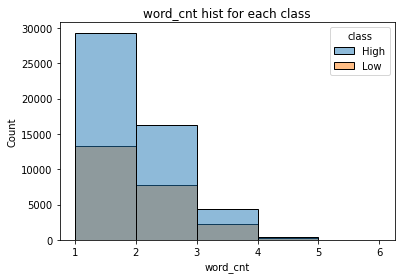

In [ ]:
eda_df['word_cnt'] = eda_df['brand'].apply(lambda x: len(x.split()))
sns.histplot(data=eda_df, x="word_cnt", binwidth=1)
plt.title('word_cnt hist')
plt.show()
print('')
sns.histplot(data=eda_df, x="word_cnt", binwidth=1, hue="class")
plt.title('word_cnt hist for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['word_cnt'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.028


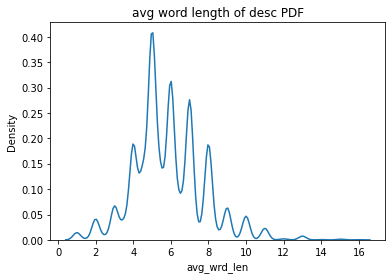

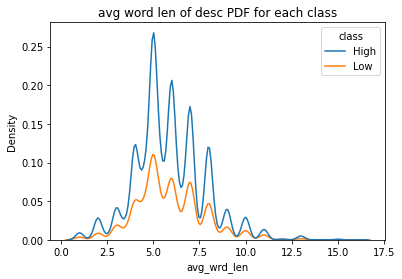

In [ ]:
eda_df['avg_wrd_len'] = eda_df['brand'].apply(lambda x: [len(i) for i in x.split()]).map(lambda x: np.mean(x))
sns.kdeplot(data=eda_df, x="avg_wrd_len")
plt.title('avg word length of desc PDF')
plt.show()
print('')
sns.kdeplot(data=eda_df, x="avg_wrd_len", hue="class")
plt.title('avg word len of desc PDF for each class')
plt.show()

In [ ]:
corr, _ = spearmanr(eda_df['avg_wrd_len'], eda_df['relevance'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.001


* All three stats for brands have very low correlation factor

**MOST COMMON BRANDS**

In [ ]:
eda_df_high = eda_df[eda_df['class']=='High']
eda_df_low = eda_df[eda_df['class']=='Low']

In [ ]:
top20_pos = eda_df_high['brand'].value_counts().index[:20]
top20_neg = eda_df_low['brand'].value_counts().index[:20]

In [ ]:
columns = ['Positive Class', 'Negative Class'] 
myTable = PrettyTable()
  
# Add Columns
myTable.add_column(columns[0], top20_pos)
myTable.add_column(columns[1], top20_neg)
  
print('Most common desc terms')
print(myTable)

Most common desc terms
+--------------------+--------------------+
|   Positive Class   |   Negative Class   |
+--------------------+--------------------+
|      unbrand       |      unbrand       |
|    hampton bay     |    hampton bay     |
|         ge         |      everbilt      |
| home decor collect | home decor collect |
|      everbilt      |         ge         |
|       kohler       |     prime line     |
|       dewalt       |       kohler       |
|       delta        |       delta        |
|       philip       |       ryobi        |
|      milwauke      |     crown bolt     |
|    glacier bay     |       philip       |
|        moen        |       dewalt       |
|       ryobi        |       ridgid       |
|     prime line     |      veranda       |
|     crown bolt     |      milwauke      |
|      veranda       |    glacier bay     |
|       huski        |        moen        |
|       ridgid       |       huski        |
|   lithonia light   |        hdx         |
| america

* Very similar distribution for both classes

# Feature Engineering 

In [ ]:
import math
import re
import xgboost as xgb
from xgboost import XGBRegressor
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
import pickle
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
cleaned_df = pd.read_csv('cleaned_df.csv')
cleaned_df.head()

title  ... relevance
0                    simpson strong tie 12 gaug angl  ...      3.00
1                    simpson strong tie 12 gaug angl  ...      2.50
2  behr premium textur deckov 1 gallon sc 141 tug...  ...      3.00
3  delta vero 1 handl shower faucet trim kit chro...  ...      2.33
4  delta vero 1 handl shower faucet trim kit chro...  ...      2.67

[5 rows x 7 columns]

In [ ]:
#Utility Functions

def xgb_model_fit(data, labels, model, cv_splits=5, early_stop=30, verbose_fit=False):
  """
  Calculating CV scores on XGBoost model with sklearn XGBRegressor 
  such that CV is done is a stratified fashion.
  """
  skf = StratifiedKFold(cv_splits, shuffle=True)
  i = 1
  results = {}

  for tr_ind, te_ind in skf.split(data, relevance_classes):
    X_tr, y_tr = data.iloc[tr_ind], labels.iloc[tr_ind]
    X_te, y_te = data.iloc[te_ind], labels.iloc[te_ind]
    print('  Round {} of {}-fold cross validation'.format(i, cv_splits))
    hist = model.fit(X_tr, y_tr, 
              eval_set=[(X_te, y_te)], 
              eval_metric='rmse',
              early_stopping_rounds=early_stop,
              verbose=verbose_fit
              )
    bst = min(hist.evals_result()['validation_0']['rmse'])
    n_rounds = len(hist.evals_result()['validation_0']['rmse'])
    results['cv'+str(i)] = (bst, n_rounds)
    print('    best score = {} for n_estimators = {}'.format(bst, n_rounds-early_stop))
    i+=1

  rmse_scores = [x[0] for x in results.values()]
  print('  Mean rmse-score over all rounds = {}'.format(np.mean(rmse_scores)))
  return rmse_scores

# Feature Set 1 - Set Theoretic Features

**FEATURES**
- common words and their count between query and document fields (title, brand, description)
- Cosine coefficient,  jacquard coefficient between query and document fields
- Length of the query 
- Lengths of document fields 
- whether the last word in query is in text fields 

**FURTHER EXPERIMENTATION IDEAS**

* Do the common words contain numbers and or units.
* Common words can be encoded. 


**FURTHER EXPERIMENTATION IDEAS**

## Creating the Features

In [ ]:
data1 = cleaned_df.copy()

**COMMON WORDS**

In [ ]:
def common_words(df, col1, col2):
  """
  Returns common words between each row of col1 and col2 of df in the form of a list. 
  Length of list is number of rows in dataframe
  """
  common_list = []
  for i, row in df[[col1,col2]].iterrows():
    set1 = set(row[col1].split())
    set2 = set(row[col2].split())
    common = set1 & set2
    common = ' '.join(common)
    common_list.append(common)
  return common_list

In [ ]:
data1['common_ST'] = common_words(data1,'corrected_search', 'title')
data1['common_SD'] = common_words(data1,'corrected_search', 'description')
data1['common_SB'] = common_words(data1,'corrected_search', 'brand')

data1['num_common_ST'] = data1['common_ST'].apply(lambda x : len(x.split()))
data1['num_common_SD'] = data1['common_SD'].apply(lambda x : len(x.split()))
data1['num_common_SB'] = data1['common_SB'].apply(lambda x : len(x.split()))

#for experimental purposes, I am also creating a column for the 'uncorrected' or 'raw' search term
data1['common_r_ST'] = common_words(data1,'raw_search', 'title')
data1['common_r_SD'] = common_words(data1,'raw_search', 'description')
data1['common_r_SB'] = common_words(data1,'raw_search', 'brand')

data1['num_common_r_ST'] = data1['common_r_ST'].apply(lambda x : len(x.split()))
data1['num_common_r_SD'] = data1['common_r_SD'].apply(lambda x : len(x.split()))
data1['num_common_r_SB'] = data1['common_r_SB'].apply(lambda x : len(x.split()))

**Corrected and Uncorrected/Raw Search Analysis**

In [ ]:
print('---> Number of rows where corrected_search is same as raw search')
print(sum(data1['corrected_search'] == data1['raw_search']))

---> Number of rows where corrected_search is same as uncorrected search
56857


In [ ]:
print('---> Number of rows in which #common words for corrected_search are equal to uncorrected search')
print('brand', sum(data1['num_common_SB'] == data1['num_common_r_SB']))
print('title', sum(data1['num_common_ST'] == data1['num_common_r_ST']))
print('description', sum(data1['num_common_SD'] == data1['num_common_r_SD']))

print('-'*100)

print('---> Number of rows in which #common words for corrected_search are more than uncorrected search')
print('brand', sum(data1['num_common_SB'] > data1['num_common_r_SB']))
print('title', sum(data1['num_common_ST']  > data1['num_common_r_ST']))
print('description', sum(data1['num_common_SD'] > data1['num_common_r_SD']))

print('-'*100)

print('---> Number of rows in which #common words for uncorrected searches are more than corrected search')
print('brand', sum(data1['num_common_SB'] < data1['num_common_r_SB']))
print('title', sum(data1['num_common_ST']  < data1['num_common_r_ST']))
print('description', sum(data1['num_common_SD'] < data1['num_common_r_SD']))

---> Number of rows in which #common words for corrected_search are equal to uncorrected search
brand 73280
title 70063
description 69683
----------------------------------------------------------------------------------------------------
---> Number of rows in which #common words for corrected_search are more than uncorrected search
brand 766
title 3959
description 4339
----------------------------------------------------------------------------------------------------
---> Number of rows in which #common words for uncorrected searches are more than corrected search
brand 1
title 25
description 25


* There are considerable amount of rows where the two search terms are different
* There are very few rows in which #common words is more for uncorrected than corrected 
* We are going to keep both the uncorrected and the corrected search terms

**MORE SET OPERATIONS**

In [ ]:
def cosine_similarity_sent(sent1, sent2):
  """
  Cosine Similarity between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = math.sqrt(len(set1)) * math.sqrt(len(set2))
  
  if not denominator:
      return 0.0
  else:
      return numerator / denominator

def jacquard_coefficient_sent(sent1, sent2):
  """
  Jacquard Coefficient between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = len(set1 | set2)

  if not denominator:
      return 0.0
  else:
      return numerator / denominator

In [ ]:
#COSINE COEFFICIENT
data1['cosine_ST'] = data1.apply(lambda row: cosine_similarity_sent(row['corrected_search'], row['title']), axis=1) 
data1['cosine_SD'] = data1.apply(lambda row: cosine_similarity_sent(row['corrected_search'], row['description']), axis=1)
data1['cosine_SB'] = data1.apply(lambda row: cosine_similarity_sent(row['corrected_search'], row['brand']), axis=1)
#for experimental purposes, I am also creating a column for the 'uncorrected' search term
data1['cosine_r_ST'] = data1.apply(lambda row: cosine_similarity_sent(row['raw_search'], row['title']), axis=1) 
data1['cosine_r_SD'] = data1.apply(lambda row: cosine_similarity_sent(row['raw_search'], row['description']), axis=1)
data1['cosine_r_SB'] = data1.apply(lambda row: cosine_similarity_sent(row['raw_search'], row['brand']), axis=1)


#JACQUARD COEFFICIENT
data1['jacquard_ST'] = data1.apply(lambda row: jacquard_coefficient_sent(row['corrected_search'], row['title']), axis=1) 
data1['jacquard_SD'] = data1.apply(lambda row: jacquard_coefficient_sent(row['corrected_search'], row['description']), axis=1)
data1['jacquard_SB'] = data1.apply(lambda row: jacquard_coefficient_sent(row['corrected_search'], row['brand']), axis=1)
#for experimental purposes, I am also creating a column for the 'uncorrected' search term
data1['jacquard_r_ST'] = data1.apply(lambda row: jacquard_coefficient_sent(row['raw_search'], row['title']), axis=1) 
data1['jacquard_r_SD'] = data1.apply(lambda row: jacquard_coefficient_sent(row['raw_search'], row['description']), axis=1)
data1['jacquard_r_SB'] = data1.apply(lambda row: jacquard_coefficient_sent(row['raw_search'], row['brand']), axis=1)

**LENGTH OF DOCUMENT FIELDS**

In [ ]:
data1['len_description'] = data1['description'].apply(lambda x : len(x.split()))
data1['len_brand'] = data1['brand'].apply(lambda x : len(x.split()))
data1['len_title'] = data1['title'].apply(lambda x : len(x.split()))
data1['len_search'] = data1['corrected_search'].apply(lambda x : len(x.split()))
data1['len_r_search'] = data1['raw_search'].apply(lambda x : len(x.split()))

**PRESENCE OF LAST SEARCH WORD IN DOCUMENT FIELDS**

In [ ]:
#corrected search
data1['islast_ST'] = data1.apply(lambda row: row['corrected_search'].split()[-1] in row['title'].split(), axis=1)
data1['islast_SD'] = data1.apply(lambda row: row['corrected_search'].split()[-1] in row['description'].split(), axis=1)
data1['islast_SB'] = data1.apply(lambda row: row['corrected_search'].split()[-1] in row['brand'].split(), axis=1)

#raw search
data1['islast_r_ST'] = data1.apply(lambda row: row['raw_search'].split()[-1] in row['title'].split(), axis=1)
data1['islast_r_SD'] = data1.apply(lambda row: row['raw_search'].split()[-1] in row['description'].split(), axis=1)
data1['islast_r_SB'] = data1.apply(lambda row: row['raw_search'].split()[-1] in row['brand'].split(), axis=1)

In [ ]:
data1.columns

Index(['title', 'brand', 'description', 'attributes', 'raw_search',
       'corrected_search', 'relevance', 'common_ST', 'common_SD', 'common_SB',
       'num_common_ST', 'num_common_SD', 'num_common_SB', 'common_r_ST',
       'common_r_SD', 'common_r_SB', 'num_common_r_ST', 'num_common_r_SD',
       'num_common_r_SB', 'cosine_ST', 'cosine_SD', 'cosine_SB', 'cosine_r_ST',
       'cosine_r_SD', 'cosine_r_SB', 'jacquard_ST', 'jacquard_SD',
       'jacquard_SB', 'jacquard_r_ST', 'jacquard_r_SD', 'jacquard_r_SB',
       'len_description', 'len_brand', 'len_title', 'len_search',
       'len_r_search', 'islast_ST', 'islast_SD', 'islast_SB', 'islast_r_ST',
       'islast_r_SD', 'islast_r_SB'],
      dtype='object')

In [ ]:
#converting all the boolean column to int
bool_cols = ['islast_ST', 'islast_SD', 'islast_SB', 'islast_r_ST', 'islast_r_SD', 'islast_r_SB']
for col in bool_cols:
  data1[col] = data1[col].astype(int)

In [ ]:
corrected_feat_set = ['num_common_ST','num_common_SD', 'num_common_SB', 'cosine_ST', 'cosine_SD', 
                'cosine_SB', 'jacquard_ST', 'jacquard_SD', 'jacquard_SB', 
                'len_description', 'len_brand', 'len_title', 'len_search',
                'islast_ST', 'islast_SD', 'islast_SB']

raw_feat_set = ['num_common_r_ST', 'num_common_r_SD', 'num_common_r_SB', 'cosine_r_ST', 'cosine_r_SD', 
                'cosine_r_SB',  'jacquard_r_ST', 'jacquard_r_SD', 'jacquard_r_SB', 
                'len_description', 'len_brand', 'len_title', 'len_r_search', 
                'islast_r_ST','islast_r_SD', 'islast_r_SB']

feat_set1_comb =  ['num_common_ST','num_common_SD', 'num_common_SB', 'cosine_ST', 'cosine_SD', 
                'cosine_SB', 'jacquard_ST', 'jacquard_SD', 'jacquard_SB', 
                'len_description', 'len_brand', 'len_title', 'len_search',
                'islast_ST', 'islast_SD', 'islast_SB', 'num_common_r_ST', 'num_common_r_SD', 'num_common_r_SB', 'cosine_r_ST', 'cosine_r_SD', 
                'cosine_r_SB',  'jacquard_r_ST', 'jacquard_r_SD', 'jacquard_r_SB', 
                'len_r_search', 'islast_r_ST','islast_r_SD', 'islast_r_SB']

print(len(corrected_feat_set), len(raw_feat_set), len(feat_set1_comb))

16 16 29


In [ ]:
data1.to_pickle('featurization/feature_set1/data1.pkl')
data1[corrected_feat_set].to_pickle('featurization/feature_set1/data1_corrected.pkl')
data1[raw_feat_set].to_pickle('featurization/feature_set1/data1_raw.pkl')
data1[feat_set1_comb].to_pickle('featurization/feature_set1/data1_comb.pkl')

## EDA on Feature Set 1

In [ ]:
corrected_feat_set = ['num_common_ST','num_common_SD', 'num_common_SB', 'cosine_ST', 'cosine_SD', 
                'cosine_SB', 'jacquard_ST', 'jacquard_SD', 'jacquard_SB', 
                'len_description', 'len_brand', 'len_title', 'len_search',
                'islast_ST', 'islast_SD', 'islast_SB']

raw_feat_set = ['num_common_r_ST', 'num_common_r_SD', 'num_common_r_SB', 'cosine_r_ST', 'cosine_r_SD', 
                'cosine_r_SB',  'jacquard_r_ST', 'jacquard_r_SD', 'jacquard_r_SB', 
                'len_description', 'len_brand', 'len_title', 'len_r_search', 
                'islast_r_ST','islast_r_SD', 'islast_r_SB']

feat_set1_comb =  ['num_common_ST','num_common_SD', 'num_common_SB', 'cosine_ST', 'cosine_SD', 
                'cosine_SB', 'jacquard_ST', 'jacquard_SD', 'jacquard_SB', 
                'len_description', 'len_brand', 'len_title', 'len_search',
                'islast_ST', 'islast_SD', 'islast_SB', 'num_common_r_ST', 'num_common_r_SD', 'num_common_r_SB', 'cosine_r_ST', 'cosine_r_SD', 
                'cosine_r_SB',  'jacquard_r_ST', 'jacquard_r_SD', 'jacquard_r_SB', 
                'len_r_search', 'islast_r_ST','islast_r_SD', 'islast_r_SB']

print(len(corrected_feat_set), len(raw_feat_set), len(feat_set1_comb))

16 16 29


In [ ]:
eda_df = pd.read_pickle('featurization/feature_set1/data1.pkl')

#we are dropping the relevance scores which occur very less in the data 
#so that we can treat the remaining 9 relevance scores as categorical variables
rem = [1.25, 1.50, 1.75, 2.75, 2.25, 2.50]
eda_df.drop(eda_df[eda_df['relevance'].isin(rem)].index, inplace = True)

#creating a class with sorting relevance scores into 2 categories high and low
eda_df['binary_class'] = eda_df['relevance'].apply(lambda x: 'High' if x>2.0 else 'Low')
eda_df.head(1)

title               brand  ... islast_r_SB class
0  simpson strong tie 12 gaug angl  simpson strong tie  ...           0  High

[1 rows x 43 columns]

**PDFS FOR EACH FEATURE**

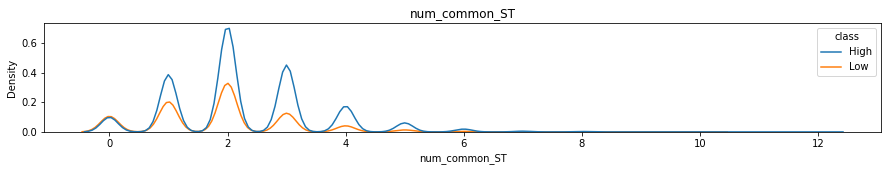

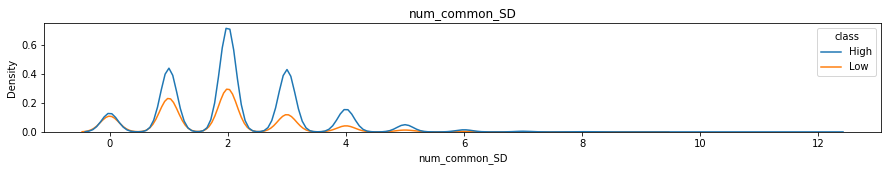

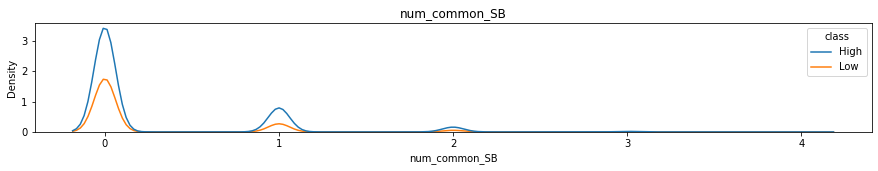

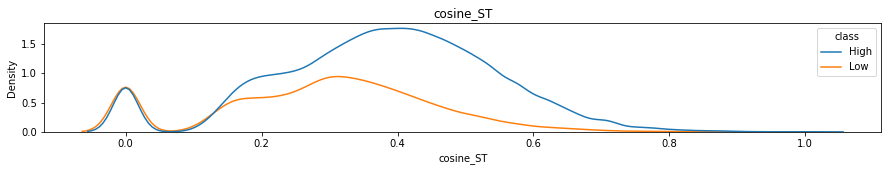

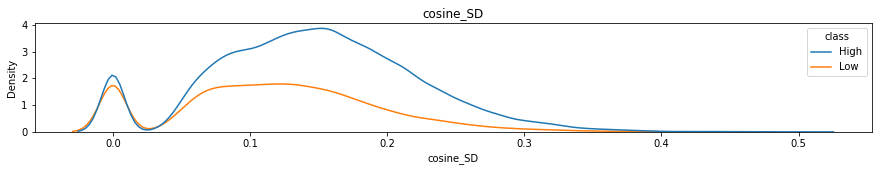

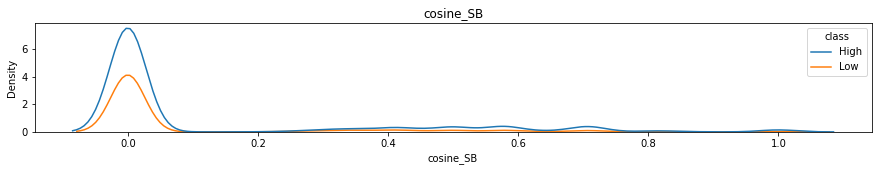

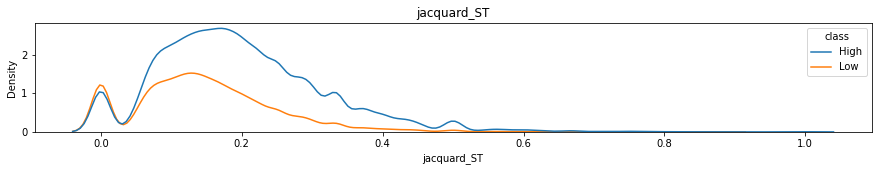

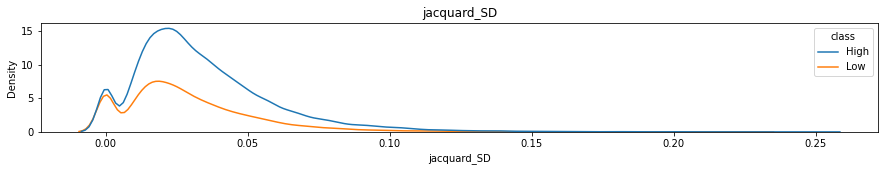

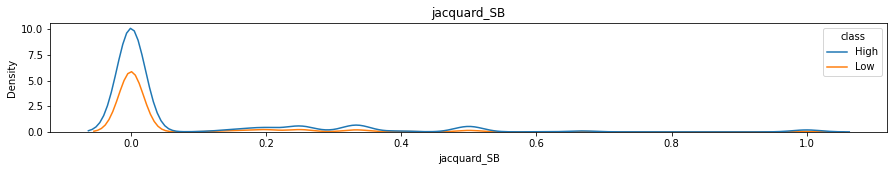

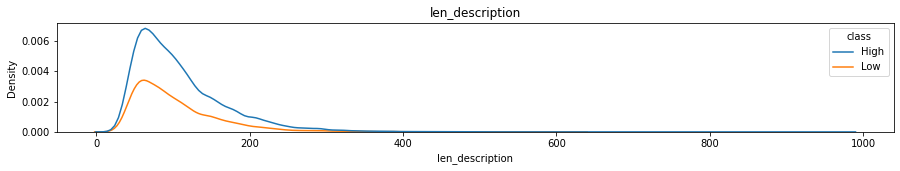

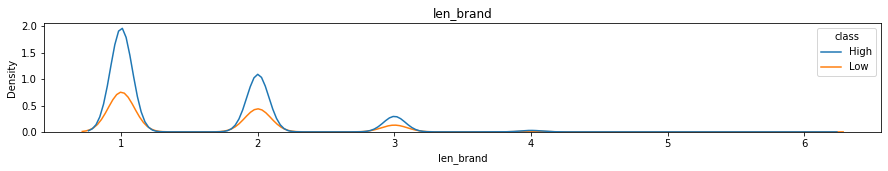

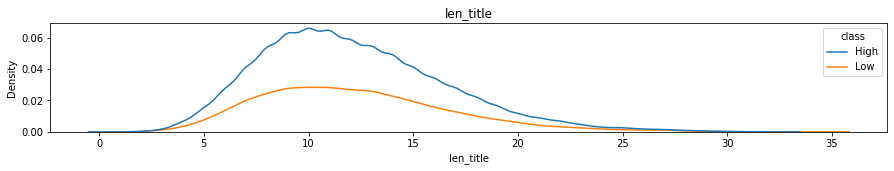

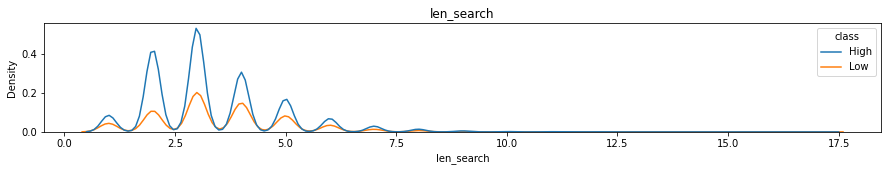

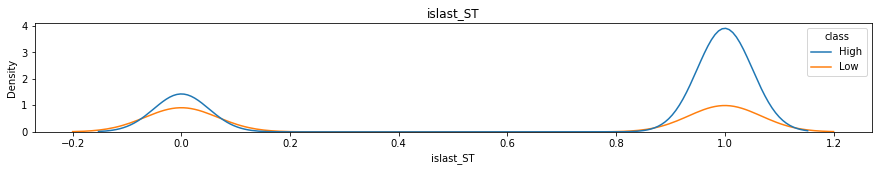

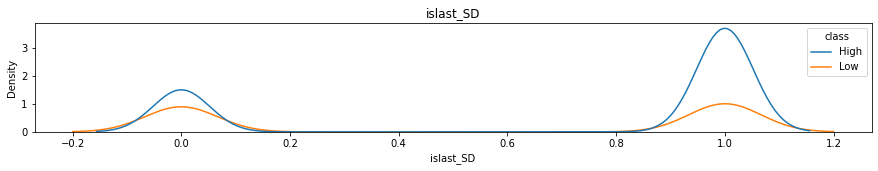

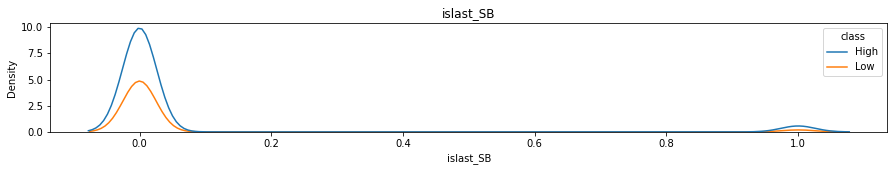

In [ ]:
for col in corrected_feat_set:
  plt.figure(figsize=(15,2))
  sns.kdeplot(data=eda_df, x=col, hue="binary_class")
  plt.title(col)
  plt.show()

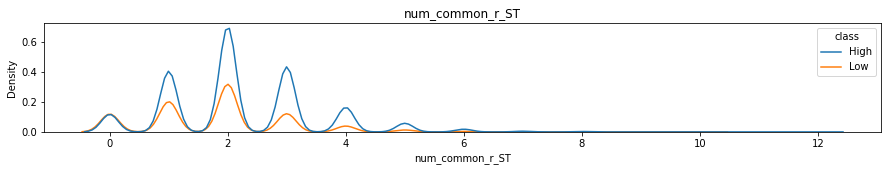

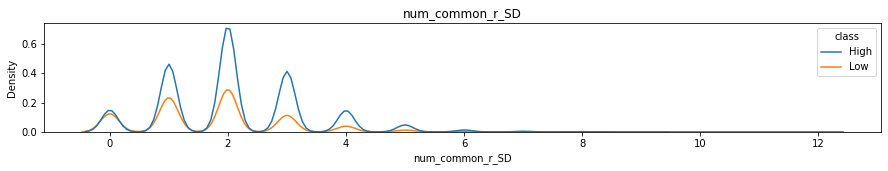

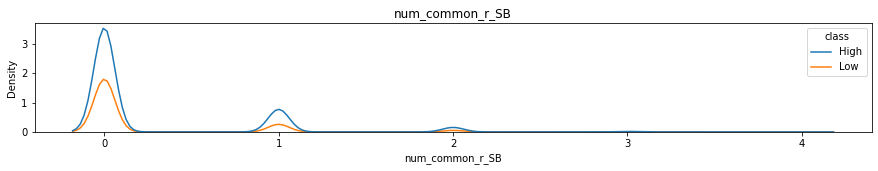

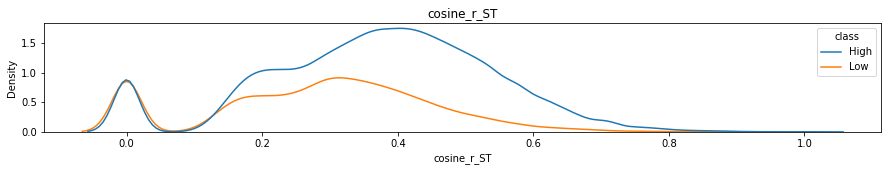

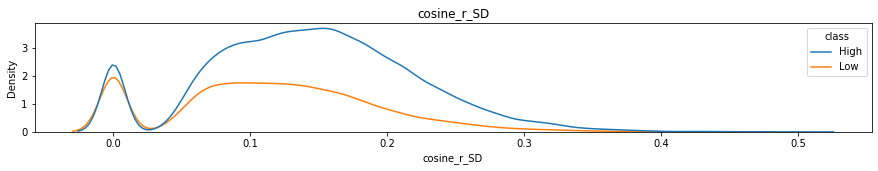

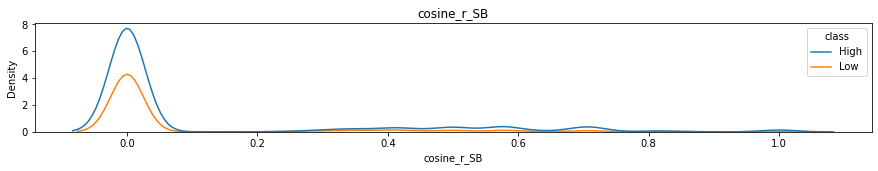

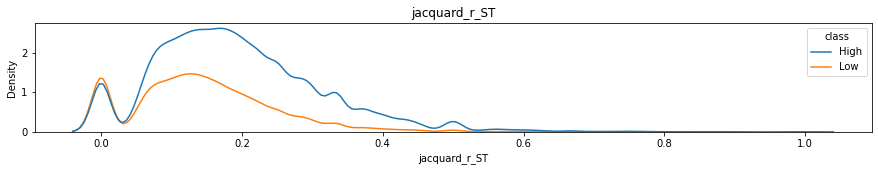

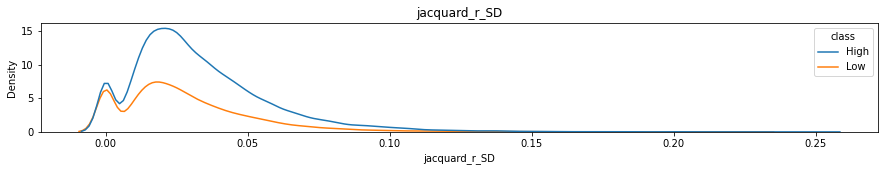

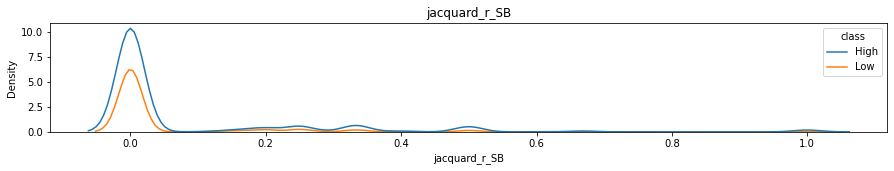

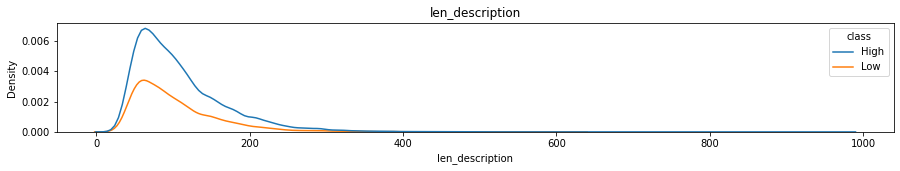

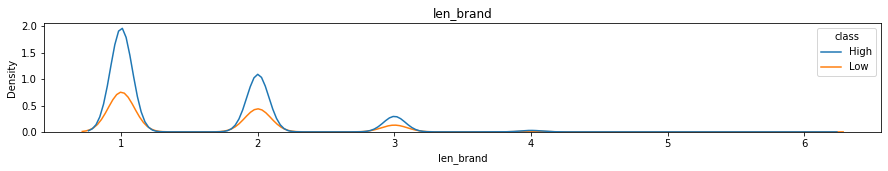

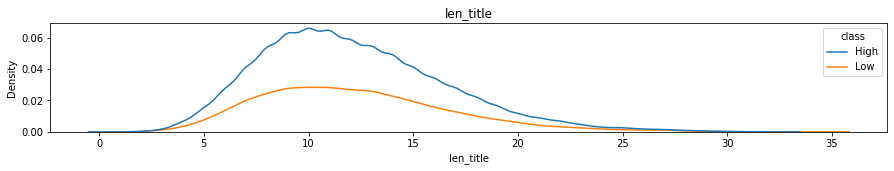

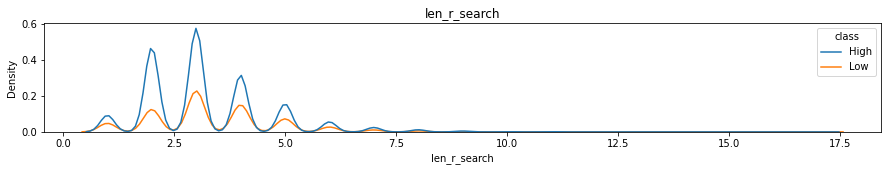

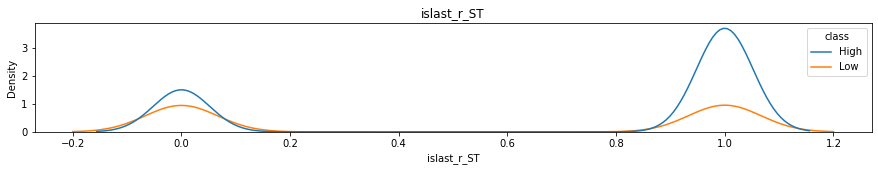

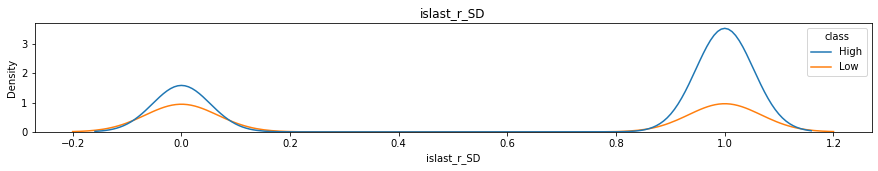

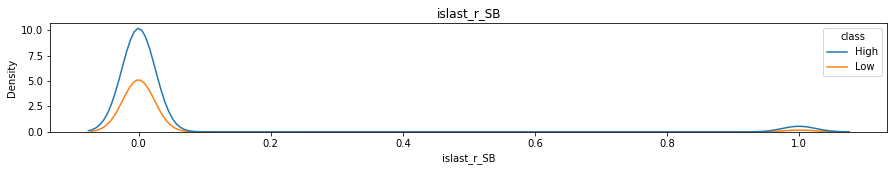

In [ ]:
for col in raw_feat_set:
  plt.figure(figsize=(15,2))
  sns.kdeplot(data=eda_df, x=col, hue="binary_class")
  plt.title(col)
  plt.show()

**Observations**
* In the num_common feature, its not that distinct but we can see that as its value increased, the density of positive class became more and more prominent.
* This prominence was more clearly observed in the cosine features. Taking the case of cosine_ST, the density is very similar for both classes near lower values but as it increases we can see that density of positive class increases drastically.
* For jacquard similarity, density of positive class did increase compared to negative but not as much as the cosine features. 
* We could also observe that similarities between search and title ST showed more distinction in distributions of the positive and negative class compared SD and SB. 
* length features didnt show a lot of difference in distributions
* One of the most interesting feature was islast feature. A pretty considerable difference in distribution was observed. For eg. in islast_ST the density of negative class seems to be similar at both 0 and 1 values but the density of positive class increased considerably
----------------------------------------------------------------
* So as per the observations, cosine and islast features are the most important features followed by jacquard. In them, ST features should show the best results 


**CORRELATION MATRIX (corrected_search)**

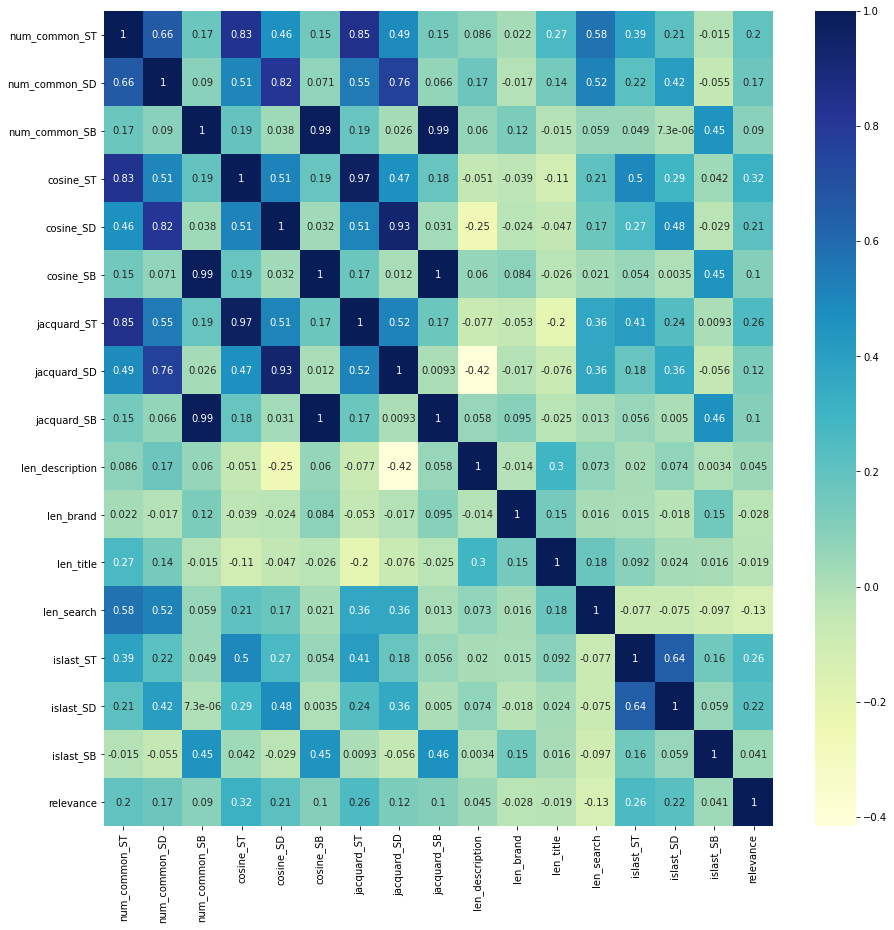

In [ ]:
# plotting correlation heatmap
plt.figure(figsize=(15,15))
corr_df = eda_df[corrected_feat_set+['relevance']].corr(method='spearman')
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()

In [ ]:
thresh = 0.8
t1 = corr_df.abs()
t1 = t1.unstack()
T = t1.sort_values(kind="quicksort")
print('Features with correlation greater than {}'.format(thresh))
print(T[(T>thresh) & (T<1.0)].drop_duplicates())

Features with correlation greater than 0.8
num_common_SD  cosine_SD        0.816731
cosine_ST      num_common_ST    0.834047
num_common_ST  jacquard_ST      0.845324
cosine_SD      jacquard_SD      0.934122
jacquard_ST    cosine_ST        0.967046
cosine_SB      num_common_SB    0.993184
num_common_SB  jacquard_SB      0.993423
cosine_SB      jacquard_SB      0.999277
dtype: float64


* There are a few highly correlated features. These correlated features can be redundant and hence we can try removing these highly correlated features.

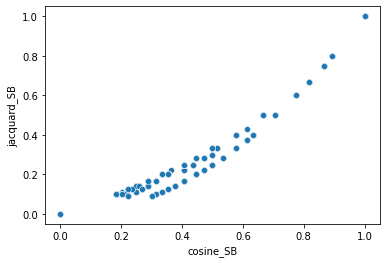

In [ ]:
sns.scatterplot(data=eda_df, x="cosine_SB", y="jacquard_SB")
plt.show()

In [ ]:
print('Most correlated features to relevance')
print('-'*50)
corr_df.abs()['relevance'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


relevance          1.000000
cosine_ST          0.316835
islast_ST          0.260858
jacquard_ST        0.257907
islast_SD          0.222174
cosine_SD          0.209757
num_common_ST      0.201161
num_common_SD      0.167762
len_search         0.130005
jacquard_SD        0.123131
jacquard_SB        0.100081
cosine_SB          0.099922
num_common_SB      0.090479
len_description    0.045072
islast_SB          0.041349
len_brand          0.028264
len_title          0.018704
Name: relevance, dtype: float64

* The correlation scores are not very high but some correlation does exist.
* We can see that correlation of cosine_ST, jacquard_ST and islast_ST are highest, exactly as we predicted.

**CORRELATION (raw_search)**

In [ ]:
# plotting correlation heatmap
corr_df = eda_df[raw_feat_set+['relevance']].corr(method='spearman')

print('Most correlated features to relevance')
print('-'*50)
corr_df.abs()['relevance'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


relevance          1.000000
cosine_r_ST        0.307163
islast_r_ST        0.257827
jacquard_r_ST      0.249345
islast_r_SD        0.223777
cosine_r_SD        0.208200
num_common_r_ST    0.196444
num_common_r_SD    0.168169
jacquard_r_SD      0.125588
len_r_search       0.115516
jacquard_r_SB      0.099574
cosine_r_SB        0.099475
num_common_r_SB    0.090078
islast_r_SB        0.045445
len_description    0.045072
len_brand          0.028264
len_title          0.018704
Name: relevance, dtype: float64

* In general it's seen that correlation of corrected_search features with relevance is more than that of raw_search features

**TSNE**

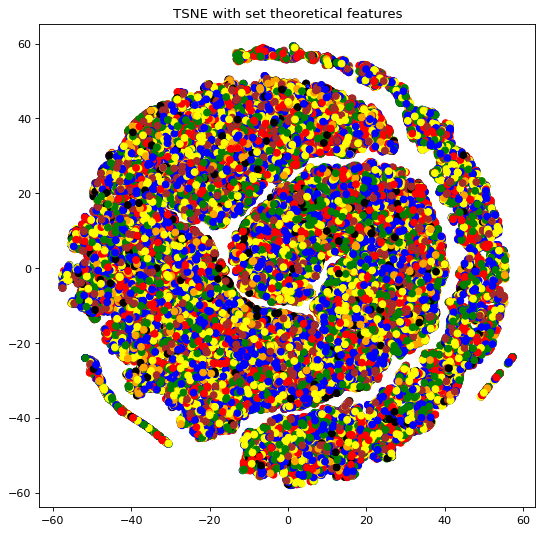

In [ ]:
from scipy.sparse import hstack
from sklearn.manifold import TSNE
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X = eda_df[feat_set1].values
y = eda_df['relevance'].values
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(X)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {3.0:'red', 2.33:'blue', 2.67:'green', 2.0:'yellow', 1.67:'brown', 1.33:'orange', 1.0:'black'}
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.title("TSNE with set theoretical features")
plt.show()

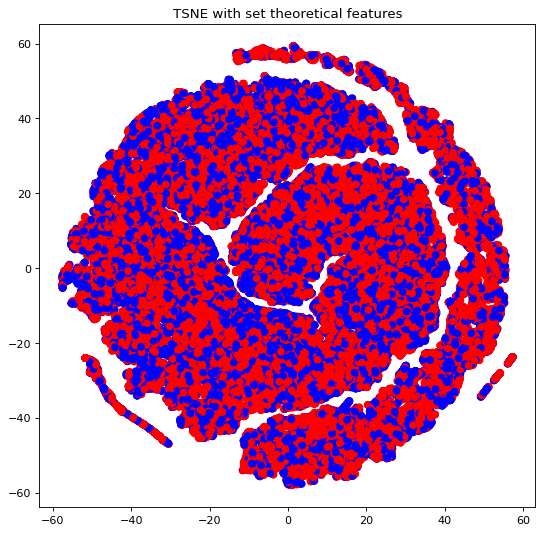

In [ ]:
y_class = eda_df['binary_class'].values
for_tsne = np.hstack((X_embedding, y_class.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {'High':'Red', 'Low':'Blue'}
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.title("TSNE with set theoretical features")
plt.show()

## Modelling Feature Set 1

### Corrected Search

In [ ]:
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data1_corrected = pd.read_pickle('featurization/feature_set1/data1_corrected.pkl')

X, y = data1_corrected, data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 16) (74047,)


In [ ]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}

* We will first tune max_depth, min_child_weight then colsample_bytree, subsample and then finally tune eta

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,7)
    for min_child_weight in range(1,3)
]

In [ ]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10,
        verbose_eval=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=3, min_child_weight=1
[0]	train-rmse:1.41473+0.000572591	test-rmse:1.41484+0.00346918
[10]	train-rmse:0.48588+0.000632769	test-rmse:0.486504+0.00134913
[20]	train-rmse:0.481606+0.000464566	test-rmse:0.482876+0.00156652
[30]	train-rmse:0.480465+0.000447472	test-rmse:0.482318+0.00157221
[40]	train-rmse:0.47963+0.000446446	test-rmse:0.482085+0.00153057
[50]	train-rmse:0.478813+0.000428647	test-rmse:0.48179+0.00154445
[60]	train-rmse:0.478214+0.000462707	test-rmse:0.481675+0.00150311
[70]	train-rmse:0.477581+0.000427126	test-rmse:0.481598+0.00146333
[80]	train-rmse:0.476974+0.000445669	test-rmse:0.481526+0.00149981
[90]	train-rmse:0.476406+0.000434532	test-rmse:0.48142+0.00147501
[100]	train-rmse:0.475865+0.000421499	test-rmse:0.481377+0.00151444
[110]	train-rmse:0.475335+0.000420839	test-rmse:0.481368+0.0015431
[120]	train-rmse:0.474818+0.000405673	test-rmse:0.481296+0.00149707
	rmse 0.48125160000000006 for 116 rounds
CV with max_depth=3, min_child_weight=2
[0]	train-rms

In [ ]:
params['max_depth'] = 6
params['min_child_weight'] = 1

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(9,11)]
    for colsample in [i/10. for i in range(9,11)]
]

In [ ]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10,
        verbose_eval=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
[0]	train-rmse:1.41266+0.000577627	test-rmse:1.41301+0.00338943
[10]	train-rmse:0.475402+0.00054382	test-rmse:0.482774+0.00168191
[20]	train-rmse:0.470106+0.000607345	test-rmse:0.48089+0.00187317
[30]	train-rmse:0.466535+0.00054947	test-rmse:0.480883+0.00190896
	rmse 0.4808834 for 30 rounds
CV with subsample=1.0, colsample=0.9
[0]	train-rmse:1.41289+0.000582391	test-rmse:1.41332+0.00335763
[10]	train-rmse:0.475677+0.00070786	test-rmse:0.482769+0.00172846
[20]	train-rmse:0.47038+0.000956576	test-rmse:0.480942+0.00187719
[30]	train-rmse:0.467092+0.000878198	test-rmse:0.481046+0.00195648
	rmse 0.48087159999999995 for 24 rounds
CV with subsample=0.9, colsample=1.0
[0]	train-rmse:1.41294+0.000452936	test-rmse:1.41322+0.00362475
[10]	train-rmse:0.475716+0.000493348	test-rmse:0.483024+0.0019699
[20]	train-rmse:0.469674+0.000521367	test-rmse:0.481295+0.00180791
	rmse 0.4812946 for 20 rounds
CV with subsample=0.9, colsample=0.9
[0]	train-rmse:1.41314+0.00042

In [ ]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.9

In [ ]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=999,
                seed=42,
                nfold=5,
                metrics=['rmse'],
                early_stopping_rounds=10,
                verbose_eval=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
[0]	train-rmse:1.41289+0.000582391	test-rmse:1.41332+0.00335763
[10]	train-rmse:0.475677+0.00070786	test-rmse:0.482769+0.00172846
[20]	train-rmse:0.47038+0.000956576	test-rmse:0.480942+0.00187719
[30]	train-rmse:0.467092+0.000878198	test-rmse:0.481046+0.00195648
	rmse 0.48087159999999995 for 24 rounds

CV with eta=0.2
[0]	train-rmse:1.59204+0.000669669	test-rmse:1.5923+0.00337341
[10]	train-rmse:0.503916+0.000566294	test-rmse:0.508753+0.0019283
[20]	train-rmse:0.472362+0.0005721	test-rmse:0.48102+0.00184204
[30]	train-rmse:0.469775+0.000565032	test-rmse:0.480438+0.00186861
[40]	train-rmse:0.467414+0.000371638	test-rmse:0.480325+0.00185566
	rmse 0.48029800000000006 for 36 rounds

CV with eta=0.1
[0]	train-rmse:1.77331+0.000758159	test-rmse:1.77343+0.00338196
[10]	train-rmse:0.765463+0.0003772	test-rmse:0.767203+0.00291966
[20]	train-rmse:0.52033+0.000469589	test-rmse:0.524667+0.00205027
[30]	train-rmse:0.479627+0.000449362	test-rmse:0.486286+0.00179762
[40]	train-rmse:0.

In [ ]:
params['eta'] = 0.05
print('Final parameters look like')
params

Final parameters look like


{'colsample_bytree': 0.9,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.86455+0.000802509	test-rmse:1.8646+0.00338555
[10]	train-rmse:1.18192+0.000495457	test-rmse:1.18251+0.00323522
[20]	train-rmse:0.805631+0.000324854	test-rmse:0.807119+0.00304497
[30]	train-rmse:0.615889+0.000392275	test-rmse:0.618686+0.00252133
[40]	train-rmse:0.530552+0.00045535	test-rmse:0.534688+0.00204567
[50]	train-rmse:0.49545+0.000510095	test-rmse:0.500842+0.00177107
[60]	train-rmse:0.481442+0.000506156	test-rmse:0.487924+0.00171137
[70]	train-rmse:0.475651+0.000500341	test-rmse:0.483067+0.00171795
[80]	train-rmse:0.472947+0.000480839	test-rmse:0.481187+0.00175915
[90]	train-rmse:0.471579+0.000430837	test-rmse:0.480469+0.00178282
[100]	train-rmse:0.470794+0.000359695	test-rmse:0.480177+0.00184398
[110]	train-rmse:0.470189+0.000414366	test-rmse:0.480033+0.00184839
[120]	train-rmse:0.469684+0.000427909	test-rmse:0.47995+0.00185848
[130]	train-rmse:0.46928+0.000422532	test-rmse:0.479931+0.00185875
[140]	train-rmse:0.468824+0.000439446	test-rmse:0.479894+0.00184411


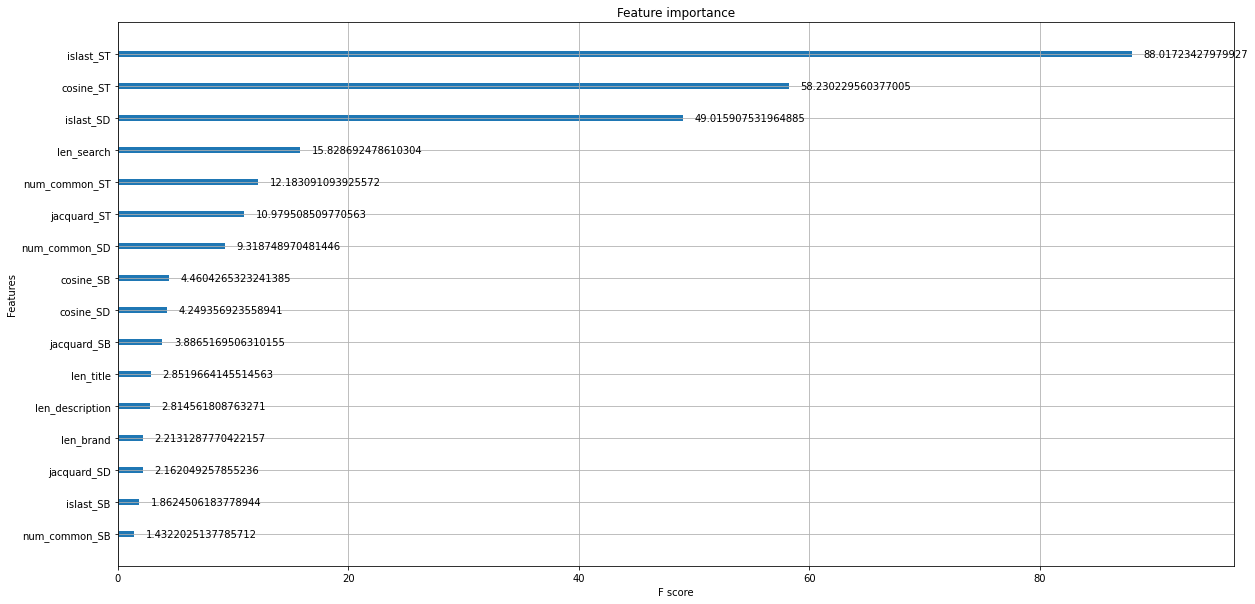

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=350,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 10)

* Note that a feature like Jacuard_ST which had almost doublt the correlation of len_search is below it in feature importance. This might be because it is correlated with cosine_ST. 
* In XGBoost, when a feature f1 is already used in a leaf node, then using another feature f2 later on which is correlated to f1 will not add much of a value.
* So two features might be better than other features but if they are correlated, then one of them doesnt contribute as much others. 

### Raw Search

In [ ]:
data1_raw = pd.read_pickle('featurization/feature_set1/data1_raw.pkl')
X, y = data1_raw, data1['relevance']
dtrain = xgb.DMatrix(X, label=y)
print('Params are:')
params

Params are:


{'colsample_bytree': 0.9,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.86455+0.000803961	test-rmse:1.86459+0.00342527
[10]	train-rmse:1.18204+0.000537092	test-rmse:1.1826+0.00352236
[20]	train-rmse:0.805888+0.000331523	test-rmse:0.807398+0.00336251
[30]	train-rmse:0.616272+0.000336213	test-rmse:0.619074+0.00291288
[40]	train-rmse:0.531034+0.000352829	test-rmse:0.535186+0.00236642
[50]	train-rmse:0.495988+0.000409659	test-rmse:0.501402+0.00195518
[60]	train-rmse:0.482044+0.000391811	test-rmse:0.488488+0.0017328
[70]	train-rmse:0.476285+0.000419829	test-rmse:0.483652+0.00159885
[80]	train-rmse:0.473627+0.000429717	test-rmse:0.481829+0.00154308
[90]	train-rmse:0.4723+0.000373817	test-rmse:0.481141+0.00151982
[100]	train-rmse:0.471506+0.000341917	test-rmse:0.480862+0.00148594
[110]	train-rmse:0.470916+0.000380411	test-rmse:0.480712+0.00147842
[120]	train-rmse:0.470484+0.000414266	test-rmse:0.480649+0.00146006
[130]	train-rmse:0.470006+0.000401803	test-rmse:0.480616+0.00147973
[140]	train-rmse:0.469528+0.0004305	test-rmse:0.480601+0.00146622
[

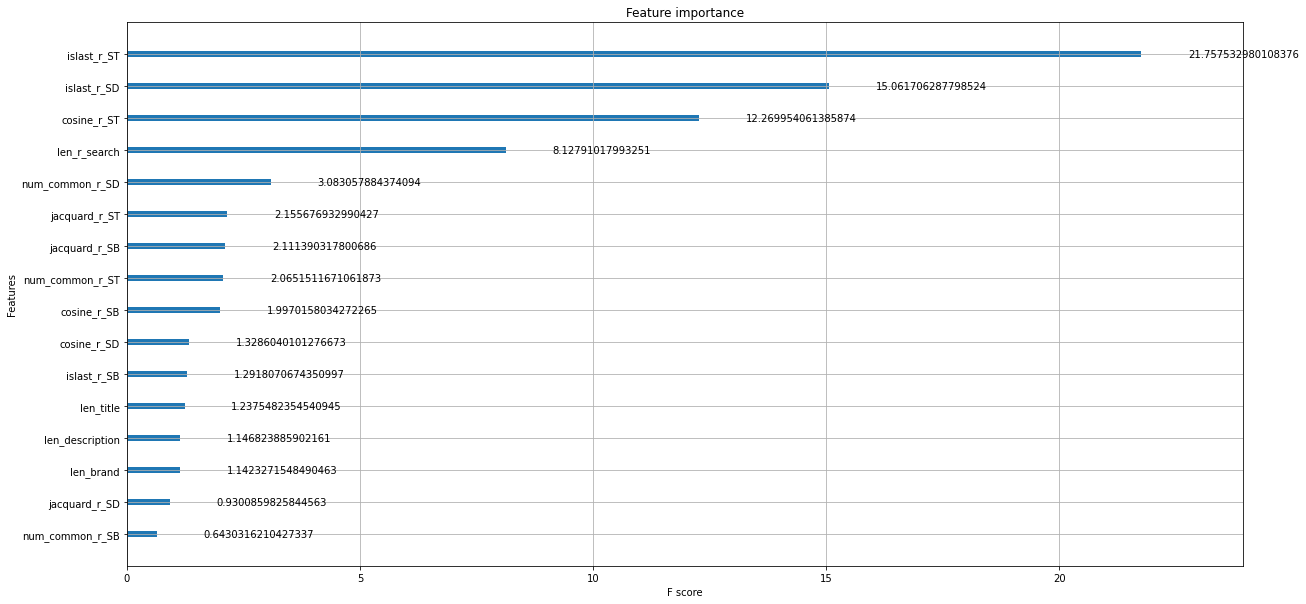

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=260,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 10)

### Combined corrected and raw search

In [ ]:
data1_comb = pd.read_pickle('featurization/feature_set1/data1_comb.pkl')
X, y = data1_comb, data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 29) (74047,)


In [ ]:
params = {'colsample_bytree': 0.9,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.86447+0.000803938	test-rmse:1.86451+0.00340387
[10]	train-rmse:1.18121+0.000487781	test-rmse:1.18184+0.00347328
[20]	train-rmse:0.804151+0.000346177	test-rmse:0.805833+0.00334267
[30]	train-rmse:0.61353+0.000369459	test-rmse:0.616699+0.00285206
[40]	train-rmse:0.527489+0.000377299	test-rmse:0.532151+0.00234908
[50]	train-rmse:0.491964+0.000397934	test-rmse:0.49801+0.00189534
[60]	train-rmse:0.477776+0.000369624	test-rmse:0.484927+0.0017191
[70]	train-rmse:0.471796+0.000389629	test-rmse:0.479969+0.0016501
[80]	train-rmse:0.468994+0.000378205	test-rmse:0.478043+0.00159245
[90]	train-rmse:0.467531+0.00033779	test-rmse:0.477311+0.00157203
[100]	train-rmse:0.466641+0.000256309	test-rmse:0.476955+0.00154283
[110]	train-rmse:0.465982+0.000191554	test-rmse:0.476794+0.00156634
[120]	train-rmse:0.465408+0.000190929	test-rmse:0.476689+0.00155546
[130]	train-rmse:0.464871+0.000165739	test-rmse:0.476621+0.00156232
[140]	train-rmse:0.464406+0.000188159	test-rmse:0.47656+0.00154873
[

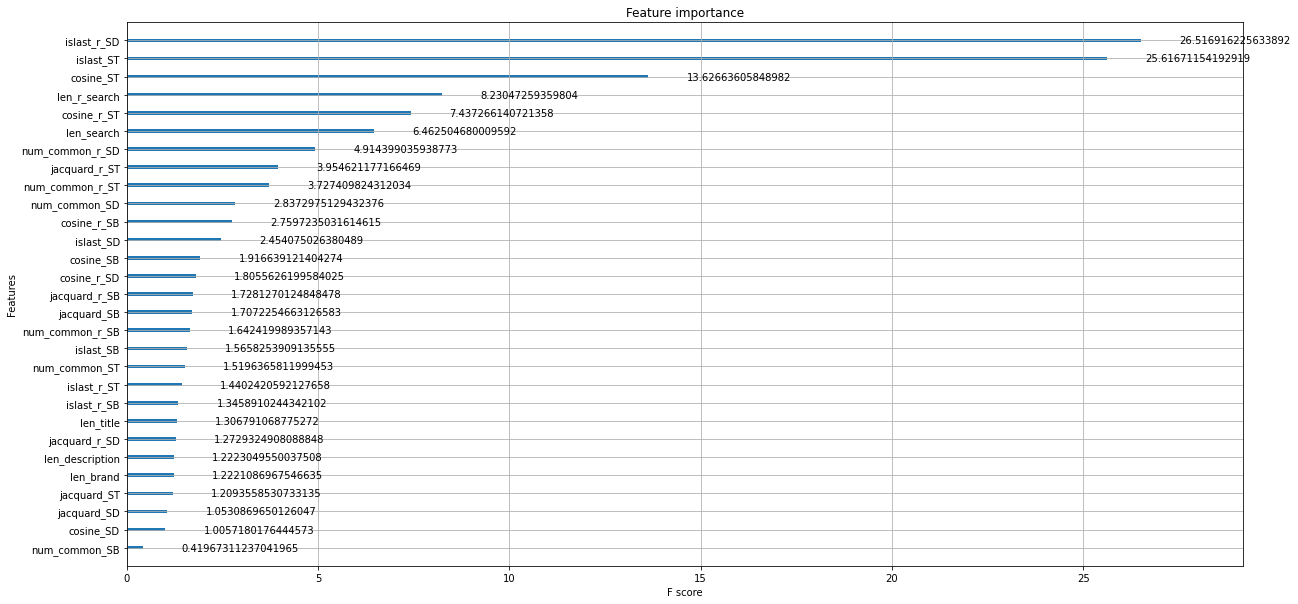

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=270,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 10)

* I tested on different sets and i have gotten the results as 
    - corrected_search features rmse = 0.4797
    - raw_search rmse features = 0.48052
    - combined features rmse = 0.476311
* So there is improvement in using corrected_search but not very drastic. But it improves pretty considerably when i use both the features combined 

**Checking once with XGBRegressor Model**

In [ ]:
params_sklearn = {'colsample_bytree': 0.9,
 'n_estimators': 999,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

model = XGBRegressor(**params_sklearn)
scores = xgb_model_fit(X, y, model)

  Round 1 of 5-fold cross validation
    best score = 0.482554 for n_estimators = 140
  Round 2 of 5-fold cross validation
    best score = 0.479585 for n_estimators = 102
  Round 3 of 5-fold cross validation
    best score = 0.482044 for n_estimators = 78
  Round 4 of 5-fold cross validation
    best score = 0.463655 for n_estimators = 312
  Round 5 of 5-fold cross validation
    best score = 0.484874 for n_estimators = 165
  Mean rmse-score over all rounds = 0.4785424


# Feature Set 2 - VSM Based Features

**FEATURES**
* LSI on term document matrices of query, title and description separately and use the low-rank approximations as features directly. 
* Apply LSI on full text (combined title and description). Then, transform query into the ‘concept’ space and calculate cosine similarity between them. 
* Other similarity measure will be cosine coefficient, jacquard coefficient and inner product.

## Creating the Features

In [ ]:
data2 = cleaned_df.copy()

**LSI ON INDIVISUAL DOCS FIELDS**

* We have selected number of components such that atleast 50% of variance is explained

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True)
X_search = vectorizer.fit_transform(data2['corrected_search'])
print(X_search.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5000, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X_search)

tsvd_var_ratios = svd_model.explained_variance_ratio_
tsvd_var_ratios.sum()

(74047, 5076)


0.9999999999999956

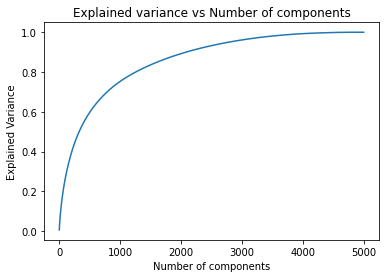

In [ ]:
cmsm = tsvd_var_ratios.cumsum()
plt.plot(cmsm)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Explained variance vs Number of components")
plt.show()

In [ ]:
comp = [500, 1000, 1500, 2000, 2500, 3000]
for i in comp:
  print('for n_components {} we have explained variance = {}'.format(i, cmsm[i]))

for n_components 500 we have explained variance = 0.5975960396076634
for n_components 1000 we have explained variance = 0.7530656571624961
for n_components 1500 we have explained variance = 0.8362545242634655
for n_components 2000 we have explained variance = 0.8925560551685472
for n_components 2500 we have explained variance = 0.9327094367152489
for n_components 3000 we have explained variance = 0.9614435017680942


In [ ]:
svd_model = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=100, random_state=122)
truncated_search = svd_model.fit_transform(X_search)
truncated_search.shape

(74047, 2000)

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True, max_features=5000, min_df=2)
X_title = vectorizer.fit_transform(data2['title'])
print(X_title.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=1000, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X_title)

tsvd_var_ratios = svd_model.explained_variance_ratio_
tsvd_var_ratios.sum()

(74047, 5000)


0.7257893860049718

In [ ]:
truncated_title = svd_model.transform(X_title)
truncated_title.shape

(74047, 1000)

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True, max_features=5000, min_df=2)
X_description = vectorizer.fit_transform(data2['description'])
print(X_description.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=1000, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X_description)

tsvd_var_ratios = svd_model.explained_variance_ratio_
tsvd_var_ratios.sum()

(74047, 5000)


0.7316435958236502

In [ ]:
truncated_description = svd_model.transform(X_description)
truncated_description.shape

(74047, 1000)

In [ ]:
trun_arr = np.hstack((truncated_search,truncated_title,truncated_description))
truncated_df = pd.DataFrame(trun_arr)
truncated_df.shape

(74047, 4000)

In [ ]:
truncated_df.to_pickle('featurization/feature_set2/truncated_df.pkl')

**LSI ON COMBINED TITLE AND DESCRIPTION**

In [ ]:
title_desc = data2["title"].astype(str) + ' ' + data2["description"].astype(str)

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True, max_features=5000, min_df=2)
X_title_desc = vectorizer.fit_transform(title_desc)
print(X_title_desc.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X_title_desc)

tsvd_var_ratios = svd_model.explained_variance_ratio_
tsvd_var_ratios.sum()

(74047, 5000)


0.8833601531424647

In [ ]:
truncated_title_desc = svd_model.transform(X_title_desc)
truncated_title_desc.shape

(74047, 2000)

In [ ]:
X_search_ = vectorizer.transform(data2['corrected_search'])
print(X_search_.shape) # check shape of the document-term matrix

transformed_search = svd_model.transform(X_search_)
transformed_search.shape

(74047, 5000)


(74047, 2000)

**Calculating similarity between them**

In [ ]:
def cosine_similarity_vec(a, b):
  """
  Cosine Similarity between 2 vectors
  """  
  num = np.dot(a, b)
  den = norm(a)*norm(b)
  if den != 0:
    return num/den
  else:
    return 0

def jacquard_similarity_vec(a, b):
  """
  Cosine Similarity between 2 vectors
  """  
  num = np.dot(a,b)
  den = norm(a)**2 + norm(b)**2 - np.dot(a,b)
  if den != 0:
    return num/den
  else:
    return 0

def inner_product_vec(a, b):
  return np.dot(a,b)

In [ ]:
cos_sim = []
for i in range(len(transformed_search)):
  cos_sim.append(cosine_similarity_vec(truncated_title_desc[i], transformed_search[i]))
print(len(cos_sim))
data2['lsi_cos_sim'] = cos_sim

74047


In [ ]:
jaq_sim = []
for i in range(len(transformed_search)):
  jaq_sim.append(jacquard_similarity_vec(truncated_title_desc[i], transformed_search[i]))
print(len(jaq_sim))
data2['lsi_jaq_sim'] = jaq_sim

74047


In [ ]:
inn_prod = []
for i in range(len(transformed_search)):
  inn_prod.append(inner_product_vec(truncated_title_desc[i], transformed_search[i]))
print(len(inn_prod))
data2['lsi_inn_prod'] = inn_prod

74047


In [ ]:
data2 = data2[['lsi_cos_sim', 'lsi_jaq_sim',	'lsi_inn_prod']]
print(data2.shape)
data2.head(3)

(74047, 3)


lsi_cos_sim  lsi_jaq_sim  lsi_inn_prod
0     0.245768     0.140083      0.236546
1     0.000178     0.000089      0.000173
2     0.121842     0.064873      0.117758

In [ ]:
data2.to_pickle('featurization/feature_set2/data2.pkl')

## EDA on feature set 2

In [ ]:
eda_df = pd.read_pickle('featurization/feature_set2/data2.pkl')
eda_df['relevance'] = cleaned_df['relevance']

#we are dropping the relevance scores which occur very less in the data 
#so that we can treat the remaining 9 relevance scores as categorical variables
rem = [1.25, 1.50, 1.75, 2.75, 2.25, 2.50]
eda_df.drop(eda_df[eda_df['relevance'].isin(rem)].index, inplace = True)

#creating a class with sorting relevance scores into 2 categories high and low
eda_df['binary_class'] = eda_df['relevance'].apply(lambda x: 'High' if x>2.0 else 'Low')
eda_df.head(1)

lsi_cos_sim  lsi_jaq_sim  lsi_inn_prod  relevance binary_class
0     0.245768     0.140083      0.236546        3.0         High

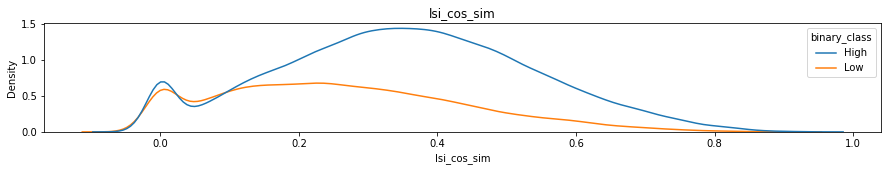

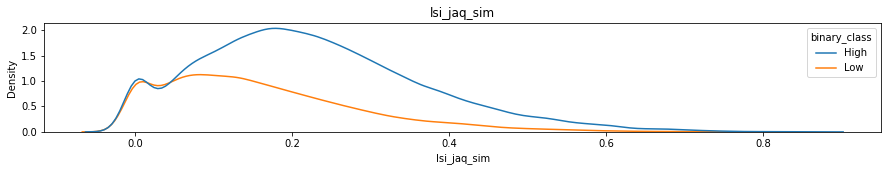

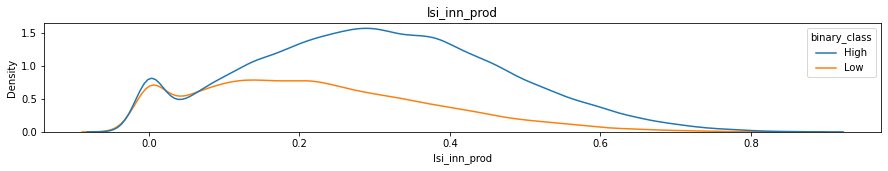

In [ ]:
for col in eda_df.columns[:3]:
  plt.figure(figsize=(15,2))
  sns.kdeplot(data=eda_df, x=col, hue="binary_class")
  plt.title(col)
  plt.show()

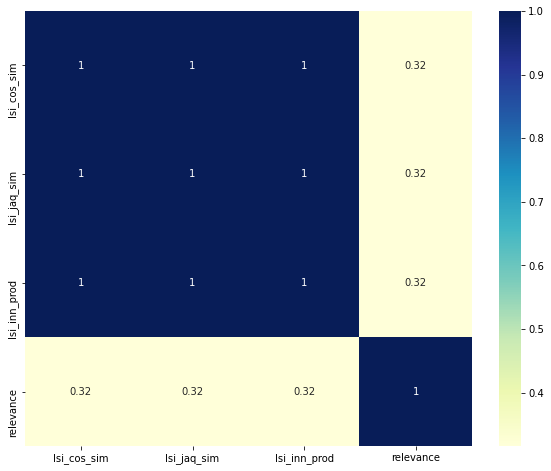

In [ ]:
# plotting correlation heatmap
corr_df = eda_df[:4].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()

* All three are very correlated features

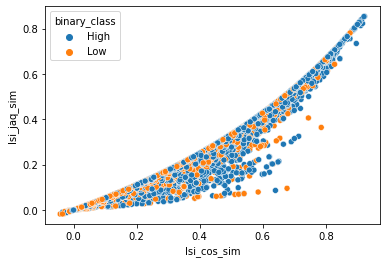

In [ ]:
sns.scatterplot(data=eda_df, x="lsi_cos_sim", y="lsi_jaq_sim", hue='binary_class')
plt.show()

## Modelling Feature Set 2 

### LSI similarity measures from set2 + basic features from set1 

In [ ]:
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data1_comb = pd.read_pickle('featurization/feature_set1/data1_comb.pkl')
data2 = pd.read_pickle('featurization/feature_set2/data2.pkl')

data12 = pd.concat([data1_comb, data2], axis=1)
print(data1_comb.shape, data2.shape, data12.shape)

(74047, 29) (74047, 3) (74047, 32)


In [ ]:
X, y = data12, data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 32) (74047,)


In [ ]:
params = {'colsample_bytree': 0.9,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.77299+0.00076999	test-rmse:1.77309+0.00343905
[10]	train-rmse:0.76139+0.000346139	test-rmse:0.763464+0.00333099
[20]	train-rmse:0.512206+0.000362845	test-rmse:0.517954+0.00215889
[30]	train-rmse:0.469723+0.000372463	test-rmse:0.478318+0.00149728
[40]	train-rmse:0.462002+0.000378428	test-rmse:0.472797+0.00128794
[50]	train-rmse:0.459507+0.000320584	test-rmse:0.4718+0.0011789
[60]	train-rmse:0.457994+0.000208107	test-rmse:0.471495+0.00113613
[70]	train-rmse:0.456698+0.000181714	test-rmse:0.471347+0.00119381
[80]	train-rmse:0.455546+0.000240869	test-rmse:0.471258+0.00119984
[90]	train-rmse:0.454236+0.000337973	test-rmse:0.471149+0.00125573
[100]	train-rmse:0.453022+0.000556835	test-rmse:0.47111+0.00126692
[110]	train-rmse:0.451964+0.000615114	test-rmse:0.471049+0.00125265
[120]	train-rmse:0.450619+0.000732202	test-rmse:0.471048+0.00128358
[130]	train-rmse:0.449431+0.000637153	test-rmse:0.47103+0.00129983
[140]	train-rmse:0.44815+0.000545837	test-rmse:0.471005+0.00130424
[

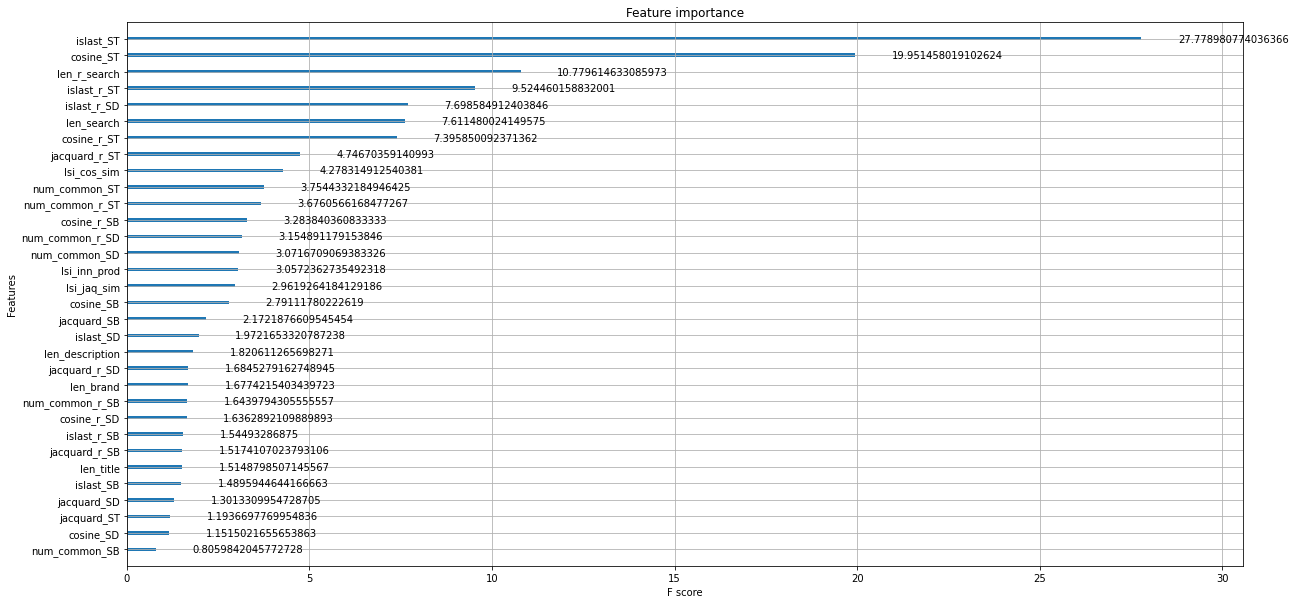

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=150,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 10)

* The three features improved the importance of the model considerably from 0.476 to 0.471. Note that this further improves to 0.470 with a lower learning rate.
* All three newly introduced features have a good feature importance value. 

**Testing with XGBRegressor**

In [ ]:
params_sklearn = {'colsample_bytree': 0.9,
 'n_estimators': 999,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

model = XGBRegressor(**params_sklearn)
scores = xgb_model_fit(X, y, model)

  Round 1 of 5-fold cross validation
    best score = 0.470615 for n_estimators = 315
  Round 2 of 5-fold cross validation
    best score = 0.472557 for n_estimators = 281
  Round 3 of 5-fold cross validation
    best score = 0.468449 for n_estimators = 334
  Round 4 of 5-fold cross validation
    best score = 0.470733 for n_estimators = 246
  Round 5 of 5-fold cross validation
    best score = 0.47137 for n_estimators = 306
  Mean rmse-score over all rounds = 0.4707448


### TSVD features from set2 + basic features from set1

#### SGD Regressor

In [ ]:
truncated_df = pd.read_pickle('featurization/feature_set2/truncated_df.pkl')
print(truncated_df.shape)
X = pd.concat([data12, truncated_df], axis=1)
y = data1['relevance']
X.shape, y.shape

(74047, 4000)


((74047, 4032), (74047,))

In [ ]:
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)

In [ ]:
model = SGDRegressor()
params = {
    'alpha':[0.001, 0,.01, 0.1, 1, 10, 100]
}
search = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=3, verbose=20, n_jobs=-1)
results = search.fit(X_stand, y)
# summarize
print('rmse: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 

rmse: -0.533
Config: {'alpha': 10}


In [ ]:
model = SGDRegressor(alpha=10)
results = model.fit(X_stand, y)
SGD_feature = model.predict(X_stand)
SGD_feature = pd.Series(SGD_feature, name='SGD')

In [ ]:
SGD_feature.to_pickle('featurization/feature_set2/SGD_feature.pkl')

### LSI features + basic features from set1 + SGD feature

In [ ]:
data12.head(1)

num_common_ST  num_common_SD  ...  lsi_inn_prod  SGD_feature
0              1              1  ...      0.236546     2.440381

[1 rows x 33 columns]

In [ ]:
X, y = data12, data1['relevance']
X['SGD_feature'] = SGD_feature
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 33) (74047,)


In [ ]:
params = {'colsample_bytree': 0.9,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.77297+0.00076535	test-rmse:1.77308+0.00344565
[10]	train-rmse:0.761162+0.000377109	test-rmse:0.763523+0.00331568
[20]	train-rmse:0.511546+0.000393857	test-rmse:0.517898+0.00231476
[30]	train-rmse:0.468713+0.000340012	test-rmse:0.478262+0.00176641
[40]	train-rmse:0.460688+0.000456799	test-rmse:0.472525+0.0015835
[50]	train-rmse:0.458073+0.000644086	test-rmse:0.471635+0.00155219
[60]	train-rmse:0.456571+0.000633757	test-rmse:0.471396+0.00153137
[70]	train-rmse:0.455165+0.000682561	test-rmse:0.471262+0.00151494
[80]	train-rmse:0.453836+0.00077376	test-rmse:0.471157+0.00151779
[90]	train-rmse:0.452668+0.000740105	test-rmse:0.471091+0.00151079
[100]	train-rmse:0.451519+0.000782262	test-rmse:0.471029+0.00152976
[110]	train-rmse:0.450432+0.000582081	test-rmse:0.470981+0.00152484
[120]	train-rmse:0.449261+0.000894888	test-rmse:0.470918+0.00150991
[130]	train-rmse:0.447824+0.000734583	test-rmse:0.470859+0.00148001
[140]	train-rmse:0.446772+0.000670385	test-rmse:0.47088+0.001443

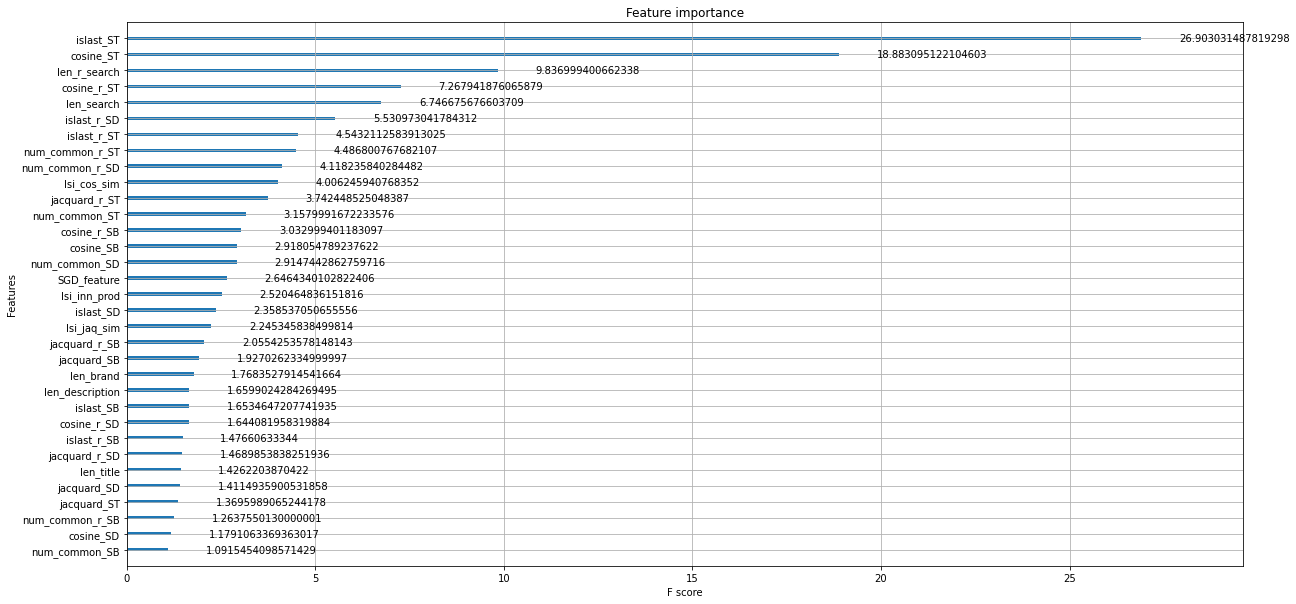

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 10)

* The SGD feature improves performance from 0.47104 to 0.47088 and as we can see it has a decent amount of feature importance

# Feature Set 3 - Probabalistic features

**FEATURES**
- Language model with Diriclet, Absolute and Jelinek Miller smoothing
- BM25 ranking function 
- Query and fields represented as tf-idf Word2Vec
- (sum, min, max) of (tf, normalized tf, tf-idf) for query in each text field 

## Creating the features

In [ ]:
data3 = cleaned_df.copy()

**LANGUAGE MODEL**

**Note**
* In the code for JM Smoothing, probability = lambd\*p_c + (1-lambd)\*pml. So a smaller lambd overfits. We have set lambda to 0.1
* Also we have used -log(prob) thus the features will have a negative corrleation with the relevance score
* In Dirichlet smoothing, i have kept value of mu as 12, 106, 1.5 for title, desc and brand which is their average length 
* These parameters in language model can be tweaked with later on

In [ ]:
#https://github.com/airalcorn2/LMIR
#The code for language modelling is stored in lmir.py file 
from lmir import LMIR

corpus = [sent.split() for sent in data3['title'].values]
model_ST = LMIR(corpus, lamb=0.1, mu=12)
data3['JM_ST'] = data3.apply(lambda row: model_ST.jelinek_mercer(row['title'].split(), row['corrected_search'].split()), axis=1)
data3['Dir_ST'] = data3.apply(lambda row: model_ST.dirichlet(row['title'].split(), row['corrected_search'].split()), axis=1)
data3['AD_ST'] = data3.apply(lambda row: model_ST.absolute_discount(row['title'].split(), row['corrected_search'].split()), axis=1)

corpus = [sent.split() for sent in data3['brand'].values]
model_SB = LMIR(corpus, lamb=0.1, mu=1.5)
data3['JM_SB'] = data3.apply(lambda row: model_SB.jelinek_mercer(row['brand'].split(), row['corrected_search'].split()), axis=1)
data3['Dir_SB'] = data3.apply(lambda row: model_SB.dirichlet(row['brand'].split(), row['corrected_search'].split()), axis=1)
data3['AD_SB'] = data3.apply(lambda row: model_SB.absolute_discount(row['brand'].split(), row['corrected_search'].split()), axis=1)

corpus = [sent.split() for sent in data3['description'].values]
model_SD = LMIR(corpus, lamb=0.1, mu=106)
data3['JM_SD'] = data3.apply(lambda row: model_SD.jelinek_mercer(row['description'].split(), row['corrected_search'].split()), axis=1)
data3['Dir_SD'] = data3.apply(lambda row: model_SD.dirichlet(row['description'].split(), row['corrected_search'].split()), axis=1)
data3['AD_SD'] = data3.apply(lambda row: model_SD.absolute_discount(row['description'].split(), row['corrected_search'].split()), axis=1)

**BM25 RANKING FUNCTION**

* We have implemented this in the featurization notebook. 



**QUERY AND FIELDS REPRESENTED AS W2V**

* for this we need text without stemming which is stored in cleaned_df2.csv file

In [ ]:
cleaned_df2 = pd.read_csv('cleaned_df2.csv')

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(cleaned_df2['corrected_search'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
search_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(cleaned_df2['corrected_search']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    search_tfidf_w2v.append(vector)

print(len(search_tfidf_w2v))
print(len(search_tfidf_w2v[0]))


74047
300


In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(cleaned_df2['title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(cleaned_df2['title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v.append(vector)

print(len(title_tfidf_w2v))
print(len(title_tfidf_w2v[0]))


74047
300


In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(cleaned_df2['description'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.
desc_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(cleaned_df2['description']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    desc_tfidf_w2v.append(vector)

print(len(desc_tfidf_w2v))
print(len(desc_tfidf_w2v[0]))


74047
300


In [ ]:
arr1 = np.array(search_tfidf_w2v)
arr2 = np.array(title_tfidf_w2v)
arr3 = np.array(desc_tfidf_w2v)

tfidf_w2v_df = pd.DataFrame(np.hstack((arr1, arr2, arr3)))
tfidf_w2v_df.shape

(74047, 900)

In [ ]:
tfidf_w2v_df.to_pickle('featurization/feature_set3/tfidf_w2v_df.pkl')

**FEATURE (sum, min, max) of (normalized tf, tf-idf, idf) for query in each text field**

In [ ]:
tfidf_model = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_model.fit(cleaned_df['title'])
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for i in tqdm(range(len(cleaned_df))):
  search = cleaned_df['corrected_search'][i]
  text = cleaned_df['title'][i]
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in tfidf_words:
      tf = (text.split().count(word)/len(text.split()))
      idf = dictionary[word]
    else:
      tf = 0
      idf = 0

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))
  

In [ ]:
data3['max_tf_ST'] = max_tf
data3['max_idf_ST'] = max_idf
data3['max_tfidf_ST'] = max_tfidf

data3['min_tf_ST'] = min_tf
data3['min_idf_ST'] = min_idf
data3['min_tfidf_ST'] = min_tfidf

data3['sum_tf_ST'] = sum_tf
data3['sum_idf_ST'] = sum_idf
data3['sum_tfidf_ST'] = sum_tfidf

In [ ]:
tfidf_model = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_model.fit(cleaned_df['brand'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for i in tqdm(range(len(cleaned_df))):
  search = cleaned_df['corrected_search'][i]
  text = cleaned_df['brand'][i]
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in tfidf_words:
      tf = (text.split().count(word)/len(text.split()))
      idf = dictionary[word]
    else:
      tf = 0
      idf = 0

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))
  

In [ ]:
data3['max_tf_SB'] = max_tf
data3['max_idf_SB'] = max_idf
data3['max_tfidf_SB'] = max_tfidf

data3['min_tf_SB'] = min_tf
data3['min_idf_SB'] = min_idf
data3['min_tfidf_SB'] = min_tfidf

data3['sum_tf_SB'] = sum_tf
data3['sum_idf_SB'] = sum_idf
data3['sum_tfidf_SB'] = sum_tfidf

In [ ]:
tfidf_model = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_model.fit(cleaned_df['description'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for i in tqdm(range(len(cleaned_df))):
  search = cleaned_df['corrected_search'][i]
  text = cleaned_df['description'][i]
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in tfidf_words:
      tf = (text.split().count(word)/len(text.split()))
      idf = dictionary[word]
    else:
      tf = 0
      idf = 0

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))
  

In [ ]:
data3['max_tf_SD'] = max_tf
data3['max_idf_SD'] = max_idf
data3['max_tfidf_SD'] = max_tfidf

data3['min_tf_SD'] = min_tf
data3['min_idf_SD'] = min_idf
data3['min_tfidf_SD'] = min_tfidf

data3['sum_tf_SD'] = sum_tf
data3['sum_idf_SD'] = sum_idf
data3['sum_tfidf_SD'] = sum_tfidf

In [ ]:
print(data3.iloc[:,7:].shape)
data3.iloc[:,7:].head(2)

(74047, 39)


JM_ST     Dir_ST      AD_ST  ...  sum_tf_SD  sum_idf_SD  sum_tfidf_SD
0  11.747774  10.839028  10.894740  ...   0.029412    8.887673       0.13026
1  19.269417  15.475177  15.377597  ...   0.000000    4.458845       0.00000

[2 rows x 39 columns]

In [ ]:
data3.iloc[:,7:].to_pickle('featurization/feature_set3/data3.pkl')

## EDA for feature set 3

In [ ]:
eda_df = pd.read_pickle('featurization/feature_set3/data3.pkl')
eda_df['relevance'] = cleaned_df['relevance']

#we are dropping the relevance scores which occur very less in the data 
#so that we can treat the remaining 9 relevance scores as categorical variables
rem = [1.25, 1.50, 1.75, 2.75, 2.25, 2.50]
eda_df.drop(eda_df[eda_df['relevance'].isin(rem)].index, inplace = True)

#creating a class with sorting relevance scores into 2 categories high and low
eda_df['binary_class'] = eda_df['relevance'].apply(lambda x: 'High' if x>2.0 else 'Low')
print(eda_df.shape)
eda_df.head(1)

(73988, 41)


JM_ST     Dir_ST     AD_ST  ...  sum_tfidf_SD  relevance  binary_class
0  11.747774  10.839028  10.89474  ...       0.13026        3.0          High

[1 rows x 41 columns]

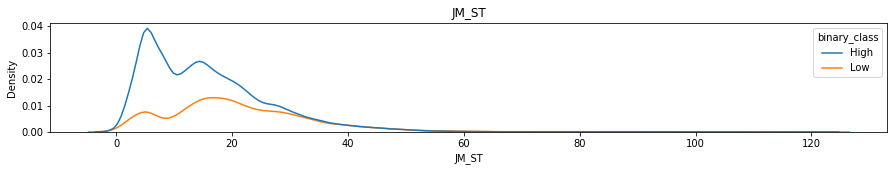

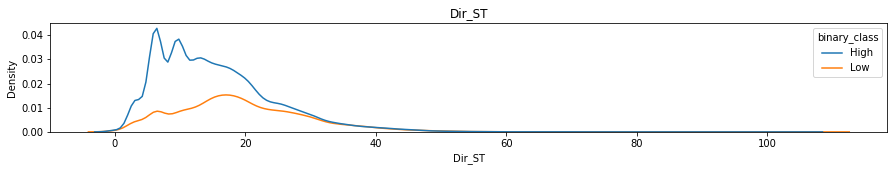

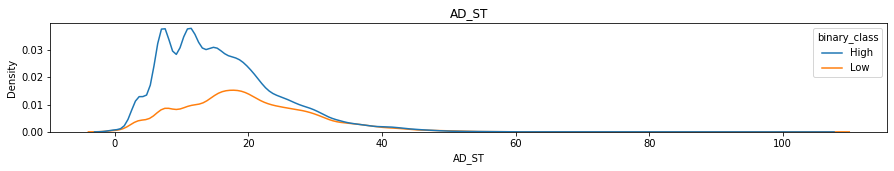

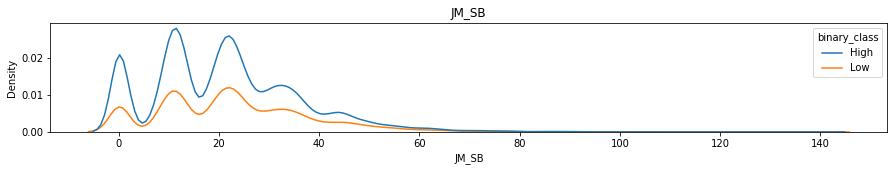

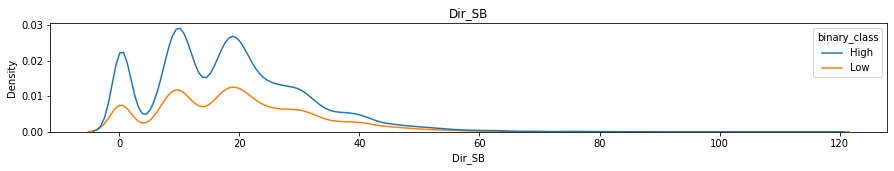

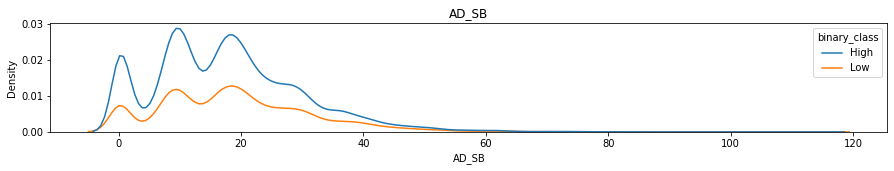

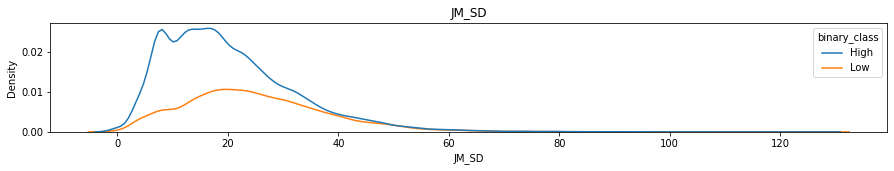

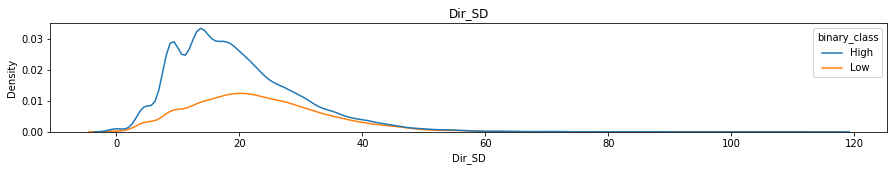

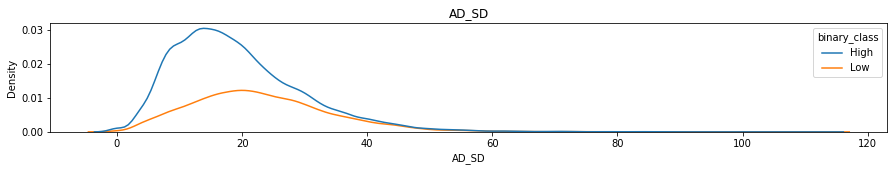

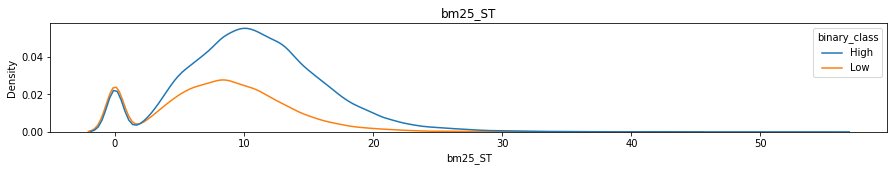

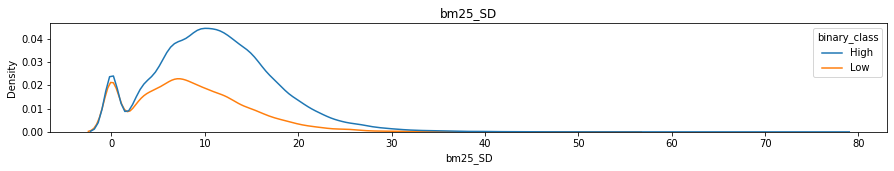

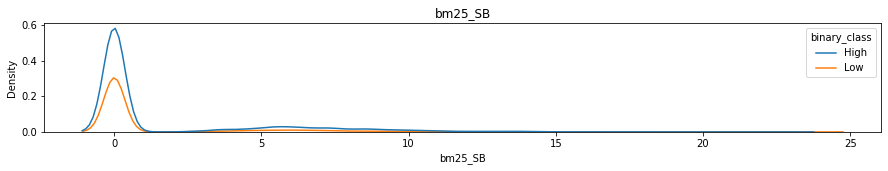

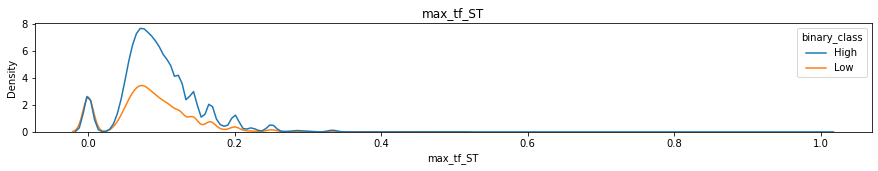

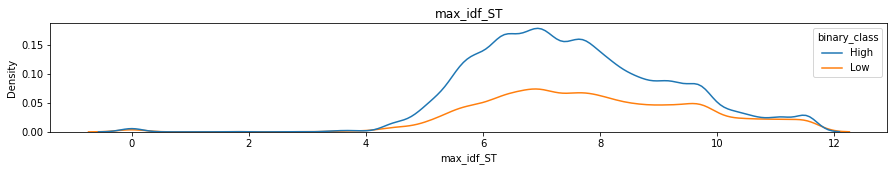

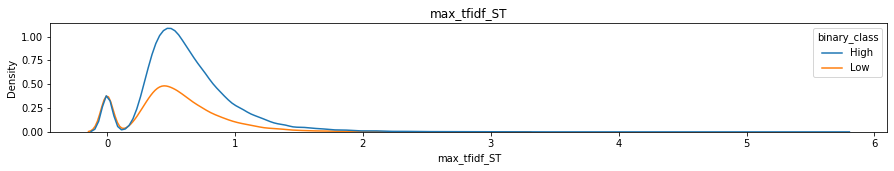

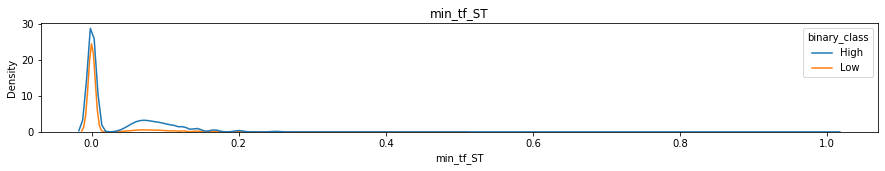

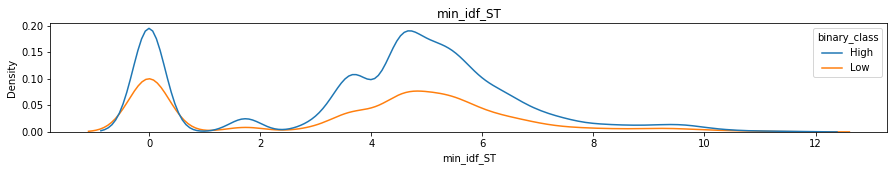

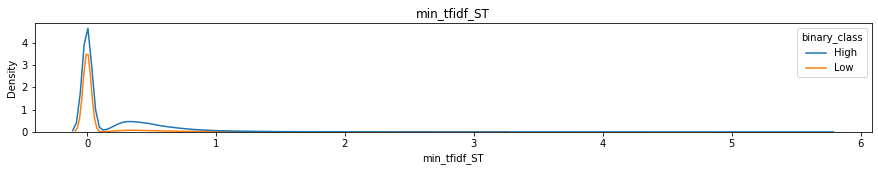

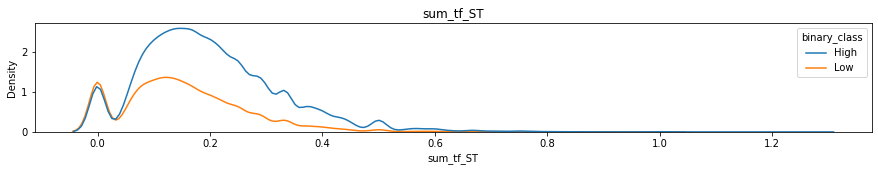

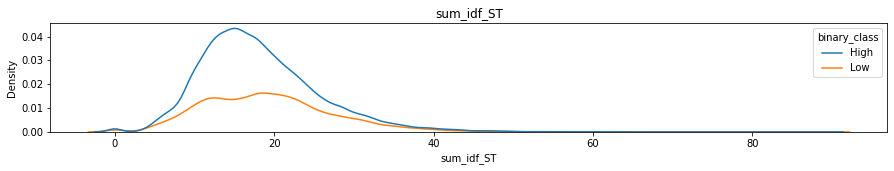

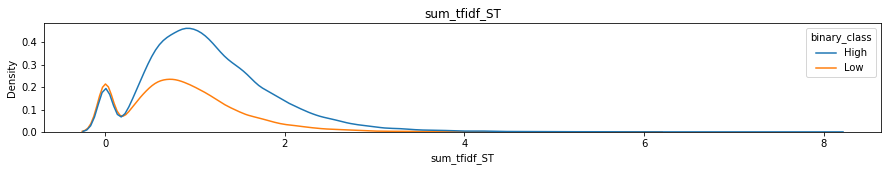

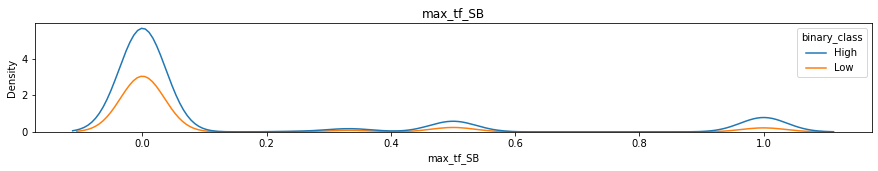

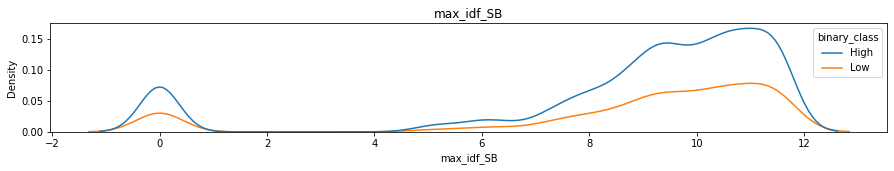

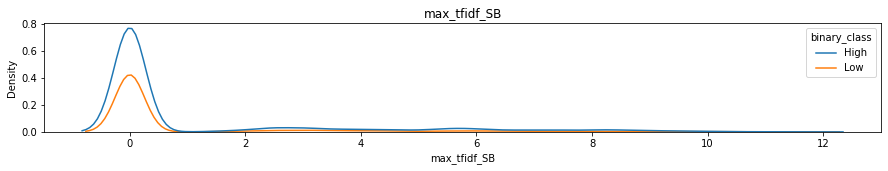

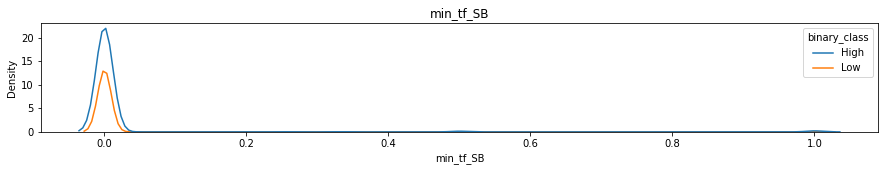

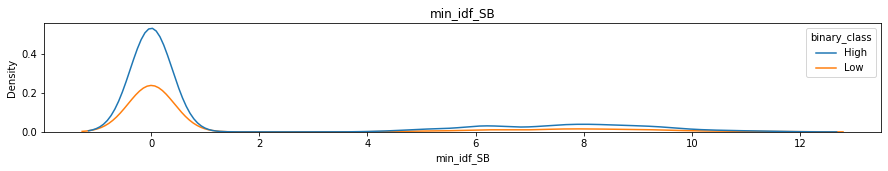

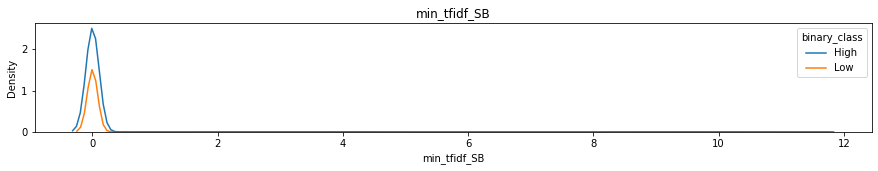

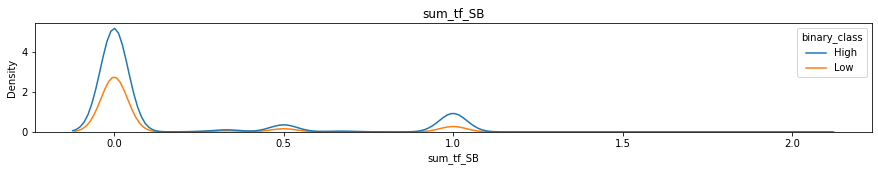

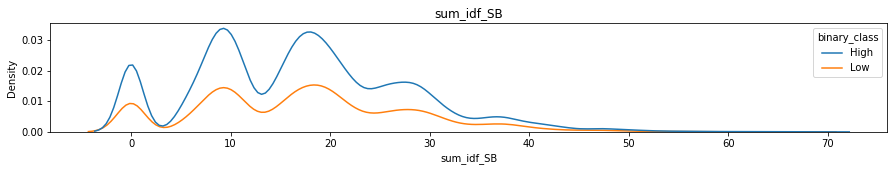

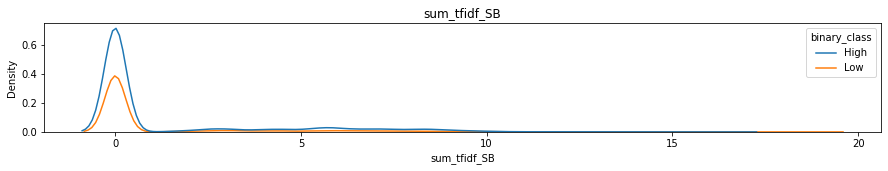

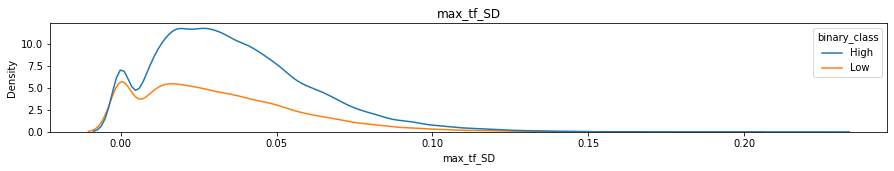

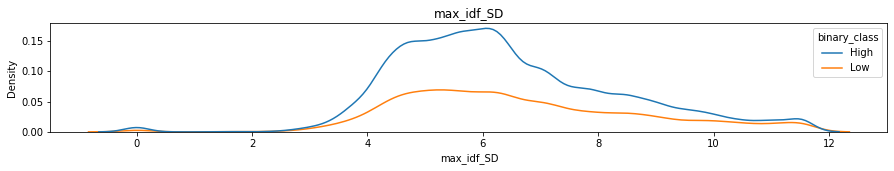

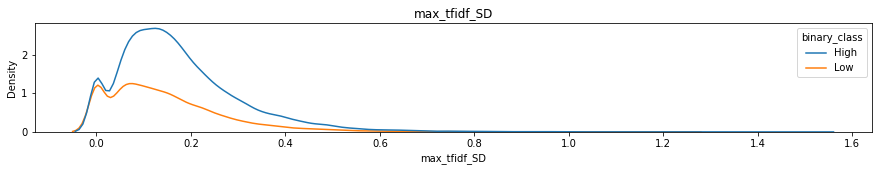

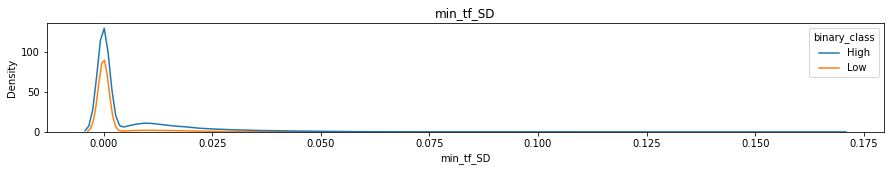

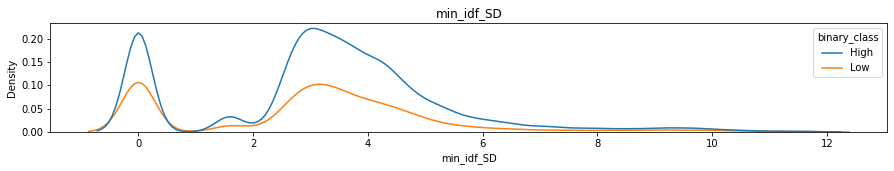

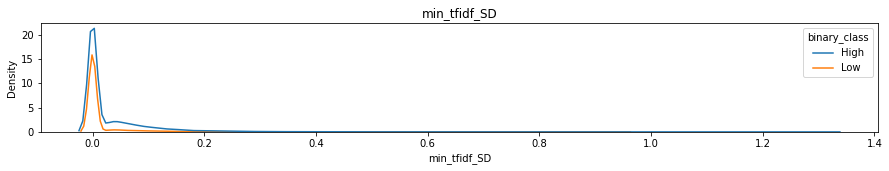

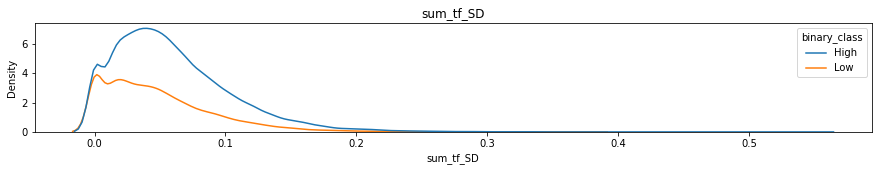

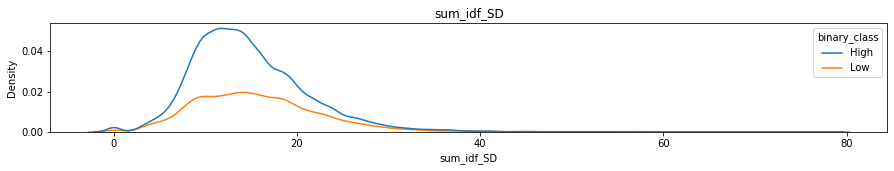

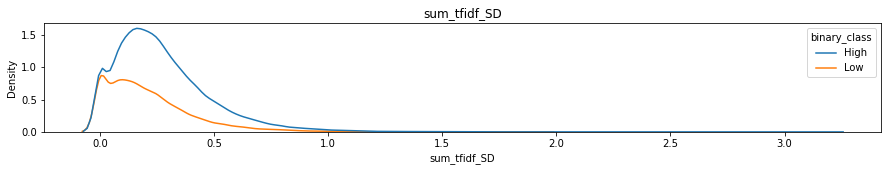

In [ ]:
for col in eda_df.columns[:-2]:
  plt.figure(figsize=(15,2))
  sns.kdeplot(data=eda_df, x=col, hue="binary_class")
  plt.title(col)
  plt.show()

* The negative trend observed in LM features  is cause we have used -log(prob)

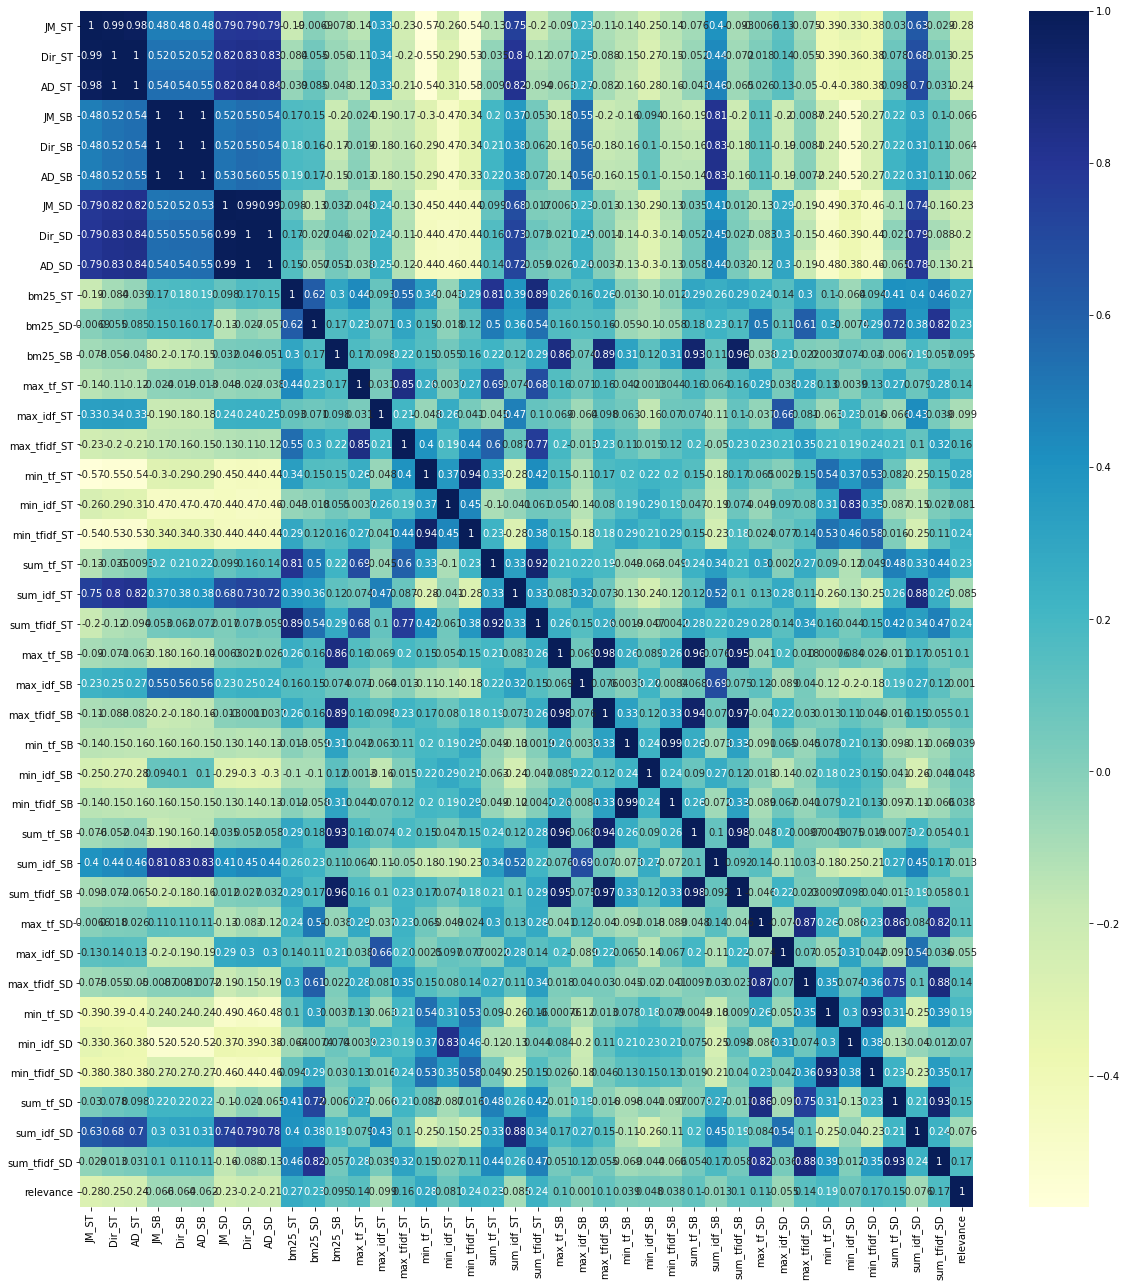

In [ ]:
# plotting correlation heatmap
corr_df = eda_df[:-1].corr(method='pearson')
plt.figure(figsize=(20,22))
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()

In [ ]:
thresh = 0.9
t1 = corr_df.abs()
t1 = t1.unstack()
T = t1.sort_values(kind="quicksort")
print('Features with correlation greater than {}'.format(thresh))
print(T[(T>thresh) & (T<1.0)].drop_duplicates())

Features with correlation greater than 0.9
sum_tf_ST     sum_tfidf_ST    0.922426
sum_tfidf_SD  sum_tf_SD       0.927035
min_tfidf_SD  min_tf_SD       0.928521
sum_tf_SB     bm25_SB         0.931359
max_tfidf_SB  sum_tf_SB       0.941697
min_tf_ST     min_tfidf_ST    0.941715
sum_tfidf_SB  max_tf_SB       0.946182
bm25_SB       sum_tfidf_SB    0.960559
max_tf_SB     sum_tf_SB       0.964693
sum_tfidf_SB  max_tfidf_SB    0.970849
sum_tf_SB     sum_tfidf_SB    0.975056
max_tf_SB     max_tfidf_SB    0.975439
JM_ST         AD_ST           0.981087
Dir_SD        JM_SD           0.989165
min_tf_SB     min_tfidf_SB    0.989630
AD_SD         JM_SD           0.990228
JM_ST         Dir_ST          0.991206
AD_ST         Dir_ST          0.997004
Dir_SD        AD_SD           0.997622
JM_SB         AD_SB           0.997828
              Dir_SB          0.998255
Dir_SB        AD_SB           0.998966
dtype: float64


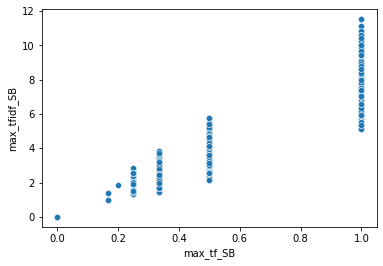

In [ ]:
sns.scatterplot(data=eda_df, x="max_tf_SB", y="max_tfidf_SB")
plt.show()

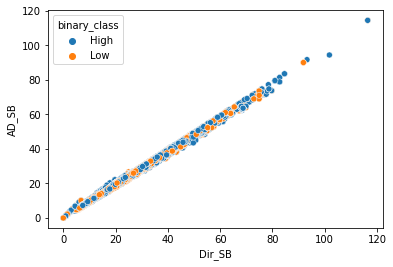

In [ ]:
sns.scatterplot(data=eda_df, x="Dir_SB", y="AD_SB", hue='binary_class')
plt.show()

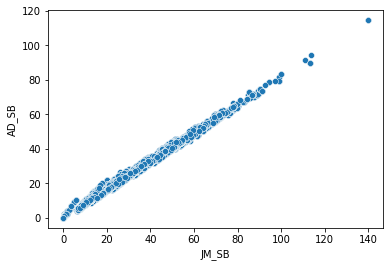

In [ ]:
sns.scatterplot(data=eda_df, x="JM_SB", y="AD_SB")
plt.show()

* Lots of correlated features. Some with not so straigtforward correlation (like max_tf) but some with proper linear like LM features.
* We should consider removing these highly correlated features

In [ ]:
print('Most correlated features to relevance')
print('-'*50)
corr_df.abs()['relevance'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


relevance       1.000000
min_tf_ST       0.282080
JM_ST           0.281174
bm25_ST         0.269340
Dir_ST          0.253255
sum_tfidf_ST    0.240274
min_tfidf_ST    0.239003
AD_ST           0.237795
bm25_SD         0.229760
JM_SD           0.227359
sum_tf_ST       0.225930
AD_SD           0.207208
Dir_SD          0.201362
min_tf_SD       0.186801
sum_tfidf_SD    0.171467
min_tfidf_SD    0.165152
max_tfidf_ST    0.161228
sum_tf_SD       0.150119
max_tf_ST       0.137800
max_tfidf_SD    0.135327
max_tf_SD       0.111408
sum_tf_SB       0.104649
sum_tfidf_SB    0.103885
max_tf_SB       0.103727
max_tfidf_SB    0.103007
max_idf_ST      0.098585
bm25_SB         0.095439
sum_idf_ST      0.085430
min_idf_ST      0.081085
sum_idf_SD      0.075939
min_idf_SD      0.070397
JM_SB           0.066145
Dir_SB          0.064215
AD_SB           0.061753
max_idf_SD      0.055306
min_idf_SB      0.048182
min_tf_SB       0.039350
min_tfidf_SB    0.038386
sum_idf_SB      0.013404
max_idf_SB      0.001009


## Modelling Feature Set 3

### Only set3 features

In [ ]:
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data3 = pd.read_pickle('featurization/feature_set3/data3.pkl')

print(data3.shape)
data3.head()

(74047, 39)


JM_ST     Dir_ST      AD_ST  ...  sum_tf_SD  sum_idf_SD  sum_tfidf_SD
0  11.747774  14.532992  10.894740  ...   0.029412    8.887673      0.130260
1  19.269417  14.670238  15.377597  ...   0.000000    4.458845      0.000000
2  19.122535  14.529329  15.230715  ...   0.030769    9.460429      0.124317
3  22.157968  20.962120  19.311185  ...   0.012821   13.305764      0.053742
4  20.322412  24.916152  20.472322  ...   0.025641   16.413634      0.103222

[5 rows x 39 columns]

In [ ]:
X, y = data3, data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 39) (74047,)


In [ ]:
params = {'colsample_bytree': 0.9,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.773+0.00076263	test-rmse:1.7731+0.00332465
[10]	train-rmse:0.761345+0.000322747	test-rmse:0.763991+0.00302072
[20]	train-rmse:0.511287+0.000359574	test-rmse:0.518303+0.00246733
[30]	train-rmse:0.467086+0.000289893	test-rmse:0.477637+0.00230339
[40]	train-rmse:0.457649+0.000292615	test-rmse:0.471029+0.00232051
[50]	train-rmse:0.453695+0.000144766	test-rmse:0.469183+0.00229893
[60]	train-rmse:0.450981+0.000391183	test-rmse:0.468215+0.0022893
[70]	train-rmse:0.448371+0.000520879	test-rmse:0.467416+0.00212815
[80]	train-rmse:0.445921+0.000392662	test-rmse:0.466734+0.00203754
[90]	train-rmse:0.443555+0.000557408	test-rmse:0.466152+0.00199282
[100]	train-rmse:0.441013+0.000564257	test-rmse:0.465548+0.00201224
[110]	train-rmse:0.43889+0.000497973	test-rmse:0.465123+0.00210234
[120]	train-rmse:0.436617+0.00047008	test-rmse:0.464588+0.00212791
[130]	train-rmse:0.434507+0.000687648	test-rmse:0.46422+0.00198891
[140]	train-rmse:0.432662+0.000834409	test-rmse:0.463857+0.00199987
[

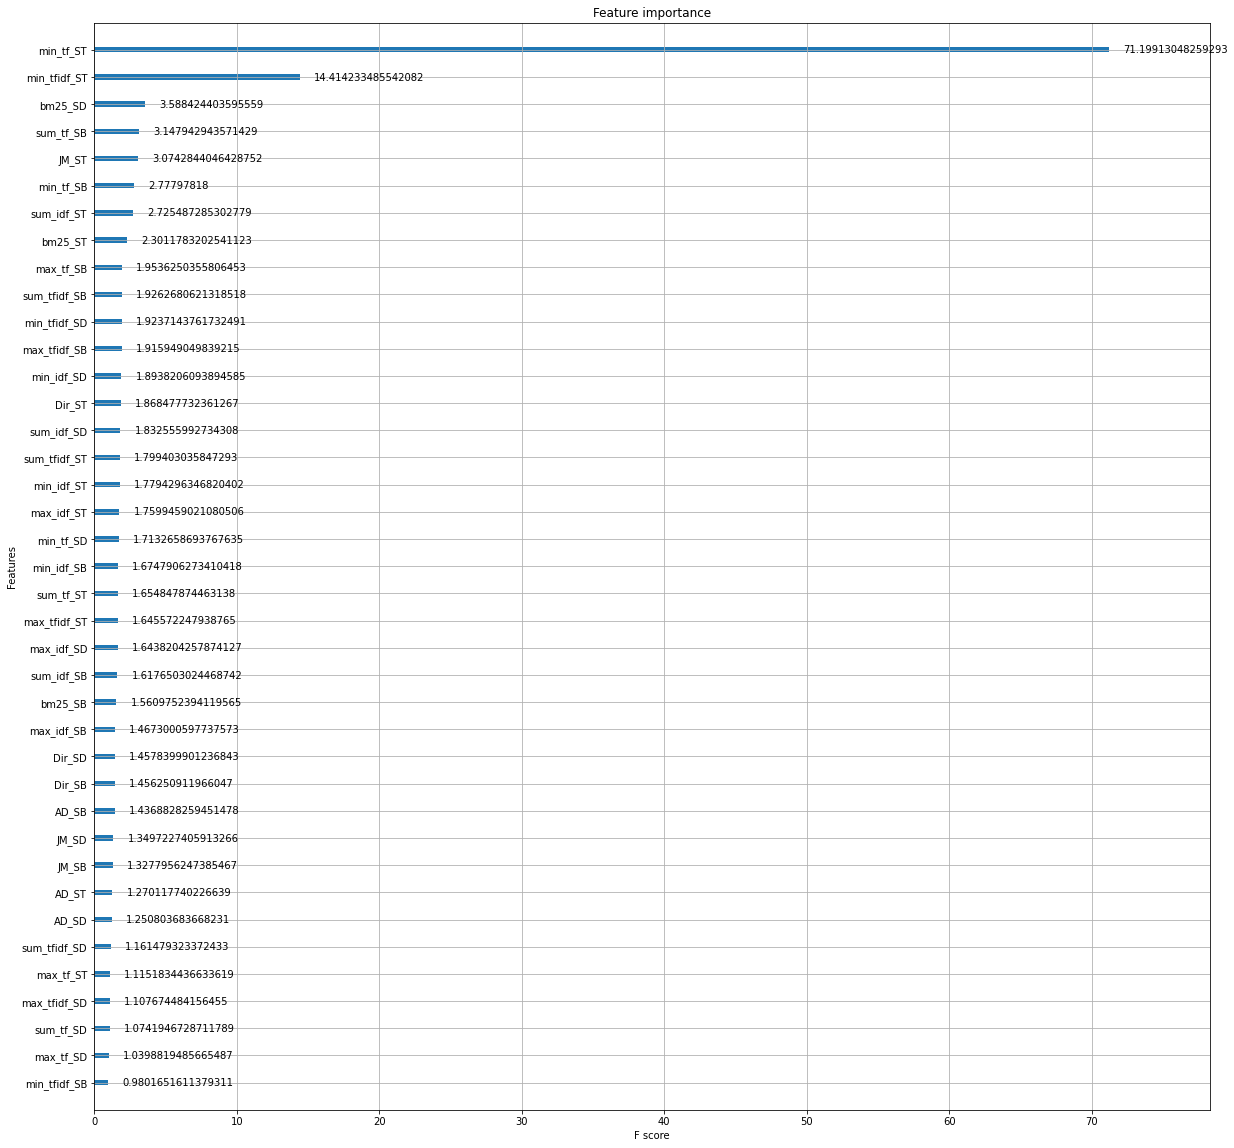

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 20)

**Crosschecking with XGBRegressor**

In [ ]:
params_sklearn = {'colsample_bytree': 0.9,
 'n_estimators': 999,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

model = XGBRegressor(**params_sklearn)
scores = xgb_model_fit(X, y, model)

  Round 1 of 5-fold cross validation
    best score = 0.456752 for n_estimators = 818
  Round 2 of 5-fold cross validation
    best score = 0.459713 for n_estimators = 873
  Round 3 of 5-fold cross validation
    best score = 0.454406 for n_estimators = 969
  Round 4 of 5-fold cross validation
    best score = 0.455713 for n_estimators = 969
  Round 5 of 5-fold cross validation
    best score = 0.457419 for n_estimators = 908
  Mean rmse-score over all rounds = 0.45680060000000006


**DROPPING min_tf_ST and min_tfidf_ST features**

In [ ]:
temp = X.drop(['min_tf_ST', 'min_tfidf_ST'], axis=1)
dtrain = xgb.DMatrix(temp, label=y)
temp.shape

(74047, 37)

In [ ]:
cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.77302+0.000755074	test-rmse:1.7731+0.00345308
[10]	train-rmse:0.761046+0.000353146	test-rmse:0.763848+0.00361342
[20]	train-rmse:0.511118+0.000446813	test-rmse:0.518329+0.00300636
[30]	train-rmse:0.467147+0.000546827	test-rmse:0.477925+0.002334
[40]	train-rmse:0.457714+0.000390084	test-rmse:0.471338+0.00234867
[50]	train-rmse:0.453813+0.000456376	test-rmse:0.469609+0.00233381
[60]	train-rmse:0.450914+0.000533905	test-rmse:0.468619+0.00218166
[70]	train-rmse:0.448306+0.000576896	test-rmse:0.467834+0.00216753
[80]	train-rmse:0.445917+0.000712228	test-rmse:0.467197+0.00213202
[90]	train-rmse:0.443675+0.0009801	test-rmse:0.466687+0.00216631
[100]	train-rmse:0.441124+0.00101536	test-rmse:0.465916+0.00215518
[110]	train-rmse:0.438954+0.0011066	test-rmse:0.46546+0.00210514
[120]	train-rmse:0.436761+0.00116622	test-rmse:0.464897+0.0021934
[130]	train-rmse:0.434491+0.00107928	test-rmse:0.464368+0.00212114
[140]	train-rmse:0.43241+0.00129046	test-rmse:0.463826+0.00205388
[150]	t

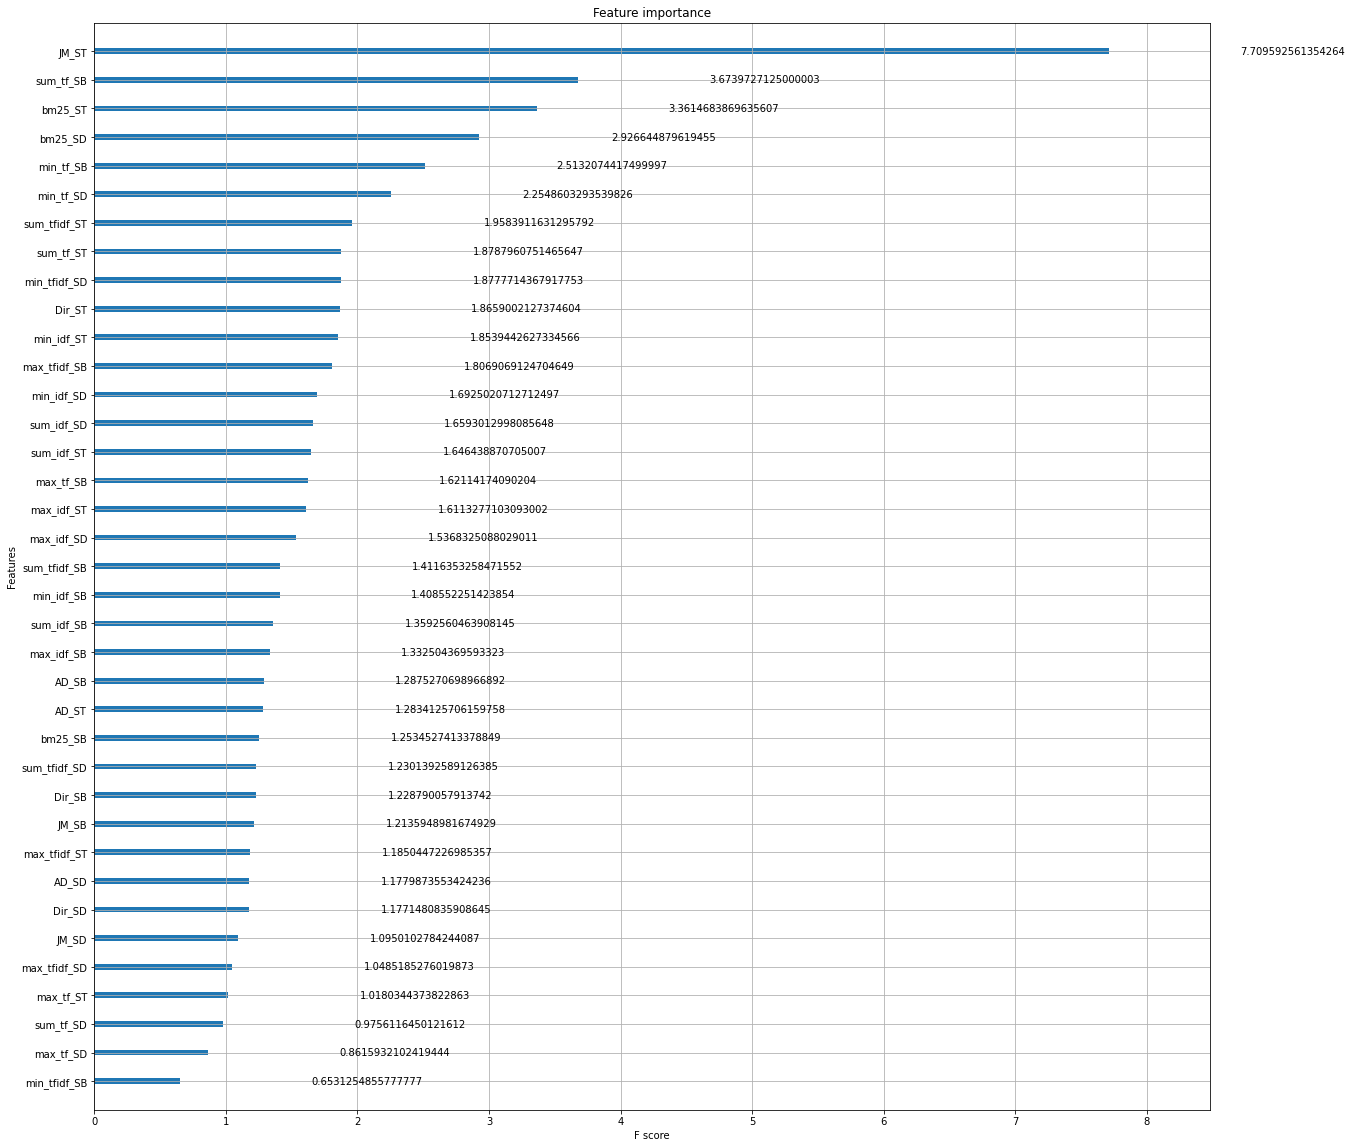

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=660,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 20)

### Set3 Features + lsi from set2 + set1 features

In [ ]:
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data1_comb = pd.read_pickle('featurization/feature_set1/data1_comb.pkl')
data2 = pd.read_pickle('featurization/feature_set2/data2.pkl')
data3 = pd.read_pickle('featurization/feature_set3/data3.pkl')

data123 = pd.concat([data1_comb, data2, data3], axis=1)
print(data1_comb.shape, data2.shape, data3.shape, data123.shape)

(74047, 29) (74047, 3) (74047, 39) (74047, 71)


In [ ]:
X, y = data123, data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 71) (74047,)


In [ ]:
params = {'colsample_bytree': 0.9,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

In [ ]:
cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.7728+0.000750143	test-rmse:1.77294+0.00345006
[10]	train-rmse:0.758723+0.000363845	test-rmse:0.761648+0.00305727
[20]	train-rmse:0.505906+0.000253632	test-rmse:0.51361+0.00233713
[30]	train-rmse:0.461055+0.00025714	test-rmse:0.472616+0.00186715
[40]	train-rmse:0.451421+0.000278255	test-rmse:0.466064+0.00172877
[50]	train-rmse:0.447282+0.000181201	test-rmse:0.464231+0.00173561
[60]	train-rmse:0.44447+0.00018566	test-rmse:0.463448+0.00173619
[70]	train-rmse:0.441951+0.000257295	test-rmse:0.462818+0.00181116
[80]	train-rmse:0.439363+0.000224203	test-rmse:0.462151+0.00172119
[90]	train-rmse:0.436842+0.000410041	test-rmse:0.461606+0.00169919
[100]	train-rmse:0.43448+0.000452197	test-rmse:0.461112+0.00163954
[110]	train-rmse:0.432337+0.000520502	test-rmse:0.46065+0.00158103
[120]	train-rmse:0.430262+0.000819334	test-rmse:0.460271+0.00159396
[130]	train-rmse:0.428152+0.00073888	test-rmse:0.459907+0.0015749
[140]	train-rmse:0.426049+0.000703261	test-rmse:0.459549+0.00162361
[1

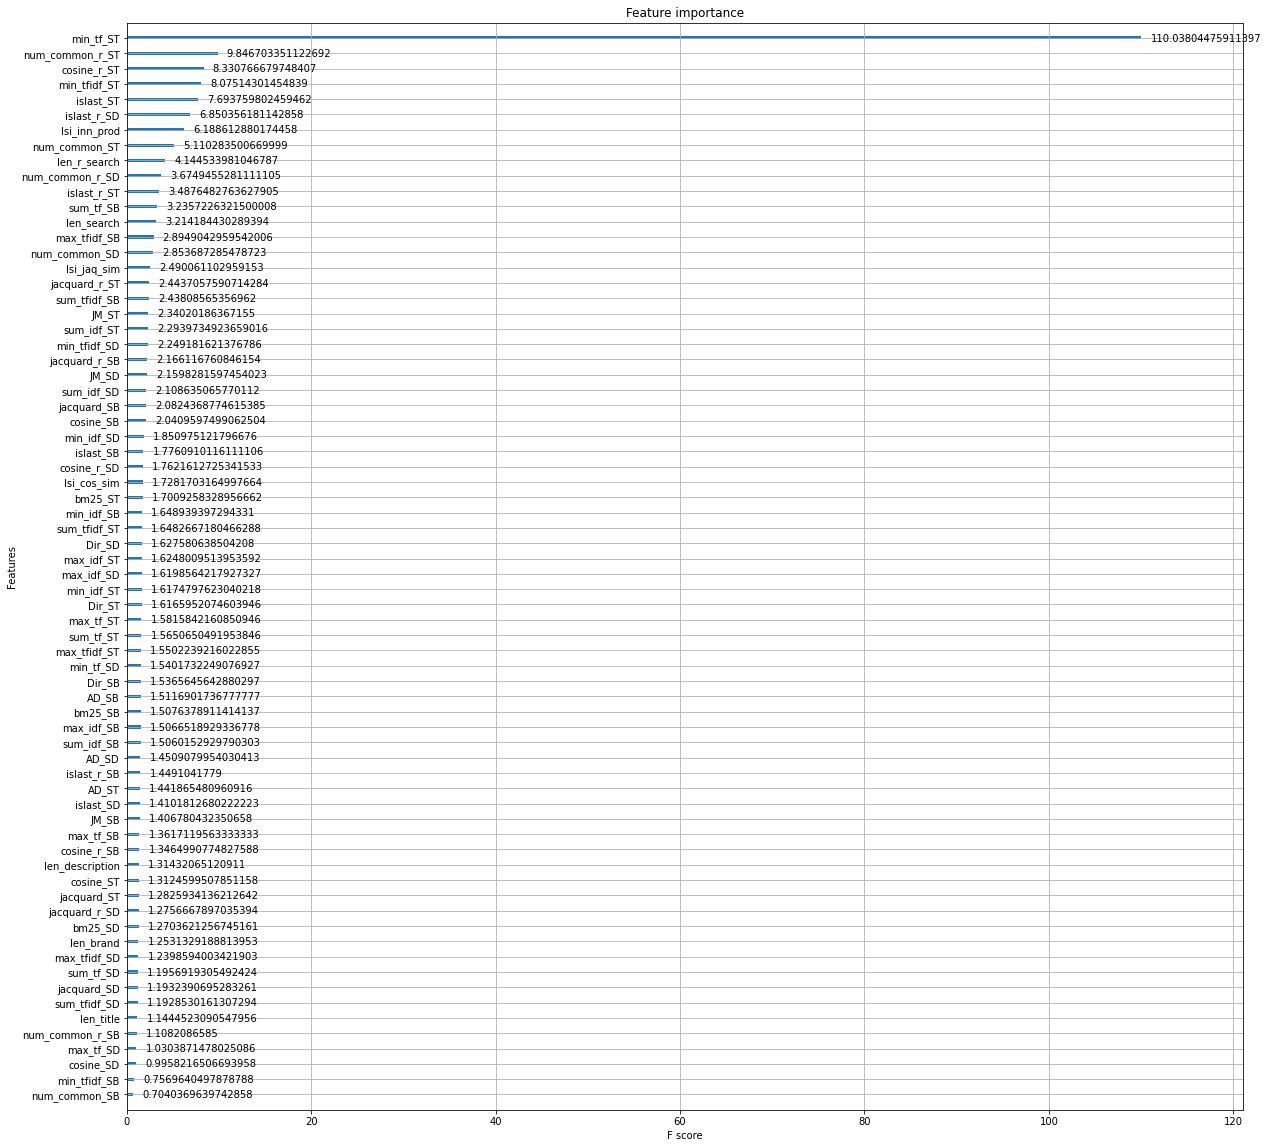

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
)

ax = xgb.plot_importance(model, importance_type='gain') 
fig = ax.figure
fig.set_size_inches(20, 20)

**Testing with XGBRegressor**

In [ ]:
params_sklearn = {'colsample_bytree': 0.9,
 'n_estimators': 999,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

model = XGBRegressor(**params_sklearn)
scores = xgb_model_fit(X, y, model)

  Round 1 of 5-fold cross validation
    best score = 0.453676 for n_estimators = 904
  Round 2 of 5-fold cross validation
    best score = 0.457828 for n_estimators = 545
  Round 3 of 5-fold cross validation
    best score = 0.452441 for n_estimators = 760
  Round 4 of 5-fold cross validation
    best score = 0.453731 for n_estimators = 770
  Round 5 of 5-fold cross validation
    best score = 0.455653 for n_estimators = 795
  Mean rmse-score over all rounds = 0.4546658


# Feature Set 4 - Query Expansion using W2V 

* For each query, it can be treated as a set of words. Now, each word is first converted to w2v and then for each term, most similar k terms are calculated. New query term q’ is a union of all the terms found. 
* All the above features can be calculated with these expanded query terms.

## Creating the features

In [ ]:
#https://medium.com/swlh/how-to-train-word2vec-model-using-gensim-library-115b35440c90
data4 = cleaned_df.copy()

In [ ]:
search_text = list(cleaned_df['corrected_search'].values)
title_text = list(cleaned_df['title'].values)

corpus = search_text.copy()
corpus.extend(title_text)
corpus = [sent.split() for sent in corpus]

len(corpus)

In [ ]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     size=100,
                     workers=-1                      
                     )

import time
t = time.time()
w2v_model.build_vocab(corpus)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

In [ ]:
w2v_model.wv.most_similar(positive=['industri'], topn=5)

In [ ]:
similar_words = []

for search in cleaned_df['corrected_search']:
  sim = []
  for word in search.split():
    lst = [item[0] for item in w2v_model.wv.most_similar(positive=[word], topn=3)]
    sim.extend(lst)

  similar_words.append(list(set(sim)))

len(similar_words)

In [ ]:
similar_words = [' '.join(lst) for lst in similar_words]
data4['sim_search_terms'] = similar_words

data4['expanded_search'] = data4["corrected_search"].astype(str) + ' ' + data4["sim_search_terms"].astype(str)

In [ ]:
data4.head()

**APPLYING FEATURE SET 1**
* We are applying the feature set 1 to this expanded search and will compare the results with normal search

**COMMON WORDS**

In [ ]:
def common_words(df, col1, col2):
  """
  Returns common words between each row of col1 and col2 of df in the form of a list. 
  Length of list is number of rows in dataframe
  """
  common_list = []
  for i, row in df[[col1,col2]].iterrows():
    set1 = set(row[col1].split())
    set2 = set(row[col2].split())
    common = set1 & set2
    common = ' '.join(common)
    common_list.append(common)
  return common_list

In [ ]:
data4['common_ex_ST'] = common_words(data4,'expanded_search', 'title')
data4['common_ex_SD'] = common_words(data4,'expanded_search', 'description')
data4['common_ex_SB'] = common_words(data4,'expanded_search', 'brand')

data4['num_common_ex_ST'] = data4['common_ex_ST'].apply(lambda x : len(x.split()))
data4['num_common_ex_SD'] = data4['common_ex_SD'].apply(lambda x : len(x.split()))
data4['num_common_ex_SB'] = data4['common_ex_SB'].apply(lambda x : len(x.split()))

**MORE SET OPERATIONS**

In [ ]:
def cosine_similarity_sent(sent1, sent2):
  """
  Cosine Similarity between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = math.sqrt(len(set1)) * math.sqrt(len(set2))

  if not denominator:
      return 0.0
  else:
      return numerator / denominator

In [ ]:
def jacquard_coefficient_sent(sent1, sent2):
  """
  Jacquard Coefficient between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = len(set1 | set2)

  if not denominator:
      return 0.0
  else:
      return numerator / denominator

In [ ]:
data4['cosine_ex_ST'] = data4.apply(lambda row: cosine_similarity_sent(row['expanded_search'], row['title']), axis=1) 
data4['cosine_ex_SD'] = data4.apply(lambda row: cosine_similarity_sent(row['expanded_search'], row['description']), axis=1)
data4['cosine_ex_SB'] = data4.apply(lambda row: cosine_similarity_sent(row['expanded_search'], row['brand']), axis=1)

In [ ]:
data4['jacquard_ex_ST'] = data4.apply(lambda row: jacquard_coefficient_sent(row['expanded_search'], row['title']), axis=1) 
data4['jacquard_ex_SD'] = data4.apply(lambda row: jacquard_coefficient_sent(row['expanded_search'], row['description']), axis=1)
data4['jacquard_ex_SB'] = data4.apply(lambda row: jacquard_coefficient_sent(row['expanded_search'], row['brand']), axis=1)

In [ ]:
data4.head(1)

In [ ]:
expanded_feat_set = ['num_common_ex_ST', 'num_common_ex_SD', 'num_common_ex_SB', 'cosine_ex_ST', 
             'cosine_ex_SD','cosine_ex_SB', 'jacquard_ex_ST', 'jacquard_ex_SD', 'jacquard_ex_SB']
             
data4[expanded_feat_set].to_pickle('featurization/feature_set4/data4.pkl')

## Modelling Feature Set 4

### Only set4 features

In [ ]:
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data4 = pd.read_pickle('featurization/feature_set4/data4.pkl')

In [ ]:
extra = ['len_description', 'len_brand', 'len_title', 'len_search',
         'islast_ST', 'islast_SD', 'islast_SB']
X = pd.concat([data4, data1[extra]], axis=1)
y = data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 16) (74047,)


In [ ]:
X.head(1)

num_common_ex_ST  num_common_ex_SD  ...  islast_SD  islast_SB
0                 1                 1  ...          0          0

[1 rows x 16 columns]

In [ ]:
params =  {'colsample_bytree': 0.9,
            'eta': 0.05,
            'eval_metric': 'rmse',
            'max_depth': 6,
            'min_child_weight': 2,
            'objective': 'reg:squarederror',
            'subsample': 1.0}

cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.86454+0.000800385	test-rmse:1.86459+0.0033804
[10]	train-rmse:1.18196+0.000463247	test-rmse:1.18256+0.00333325
[20]	train-rmse:0.805749+0.000322761	test-rmse:0.807328+0.00311915
[30]	train-rmse:0.616119+0.000406832	test-rmse:0.61905+0.00262453
[40]	train-rmse:0.530868+0.000479519	test-rmse:0.535122+0.00223112
[50]	train-rmse:0.495838+0.000524394	test-rmse:0.501289+0.00203473
[60]	train-rmse:0.481893+0.000556335	test-rmse:0.488416+0.00195264
[70]	train-rmse:0.476082+0.000533046	test-rmse:0.483592+0.00194093
[80]	train-rmse:0.47343+0.000536653	test-rmse:0.481762+0.00192923
[90]	train-rmse:0.472038+0.000526381	test-rmse:0.481051+0.00193715
[100]	train-rmse:0.471265+0.000474461	test-rmse:0.480767+0.00196296
[110]	train-rmse:0.470764+0.000453979	test-rmse:0.480637+0.00197473
[120]	train-rmse:0.470321+0.00045244	test-rmse:0.480579+0.00197646
[130]	train-rmse:0.46994+0.000430266	test-rmse:0.480552+0.0019803
[140]	train-rmse:0.469448+0.000389078	test-rmse:0.480518+0.00197816
[

### Set4 features + set3 + lsi features from set2 + set1

In [ ]:
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data1_comb = pd.read_pickle('featurization/feature_set1/data1_comb.pkl')
data2 = pd.read_pickle('featurization/feature_set2/data2.pkl')
data3 = pd.read_pickle('featurization/feature_set3/data3.pkl')
data4 = pd.read_pickle('featurization/feature_set4/data4.pkl')

data_final = pd.concat([data1_comb, data2, data3, data4], axis=1)
print(data1_comb.shape, data2.shape, data3.shape, data4.shape, data_final.shape)

(74047, 29) (74047, 3) (74047, 39) (74047, 9) (74047, 80)


In [ ]:
X = data_final
y = data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 80) (74047,)


In [ ]:
params =  {'colsample_bytree': 0.9,
            'eta': 0.05,
            'eval_metric': 'rmse',
            'max_depth': 6,
            'min_child_weight': 2,
            'objective': 'reg:squarederror',
            'subsample': 1.0}

cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.8643+0.000800822	test-rmse:1.86436+0.00339921
[10]	train-rmse:1.17896+0.000465458	test-rmse:1.18008+0.00344375
[20]	train-rmse:0.799315+0.0003422	test-rmse:0.802052+0.00312765
[30]	train-rmse:0.605393+0.000263641	test-rmse:0.610438+0.00272419
[40]	train-rmse:0.516362+0.000282343	test-rmse:0.523901+0.00226027
[50]	train-rmse:0.47864+0.000267019	test-rmse:0.488438+0.00195749
[60]	train-rmse:0.462764+0.000305325	test-rmse:0.474481+0.00175857
[70]	train-rmse:0.455484+0.0003031	test-rmse:0.468865+0.00169326
[80]	train-rmse:0.451529+0.000276472	test-rmse:0.46633+0.0016428
[90]	train-rmse:0.44882+0.000396963	test-rmse:0.465028+0.00160898
[100]	train-rmse:0.446808+0.000344739	test-rmse:0.464238+0.00161434
[110]	train-rmse:0.445254+0.000346569	test-rmse:0.463699+0.0016282
[120]	train-rmse:0.443891+0.000307834	test-rmse:0.463311+0.00165702
[130]	train-rmse:0.442457+0.000394879	test-rmse:0.46294+0.00162136
[140]	train-rmse:0.441255+0.000342993	test-rmse:0.462633+0.00164338
[150]	

# Summary 

In [ ]:
myTable = PrettyTable(["Feature Set", 'num features', "RMSE"])
  
myTable.add_row(["f1_corrected", 16, "0.4796"])
myTable.add_row(["f1_raw", 16, "0.4805"])
myTable.add_row(["f1_comb", 29, "0.4763"])
myTable.add_row(["f2_lsi + f1_comb", 32, "0.4710"])
myTable.add_row(["f2_tsvd + f2_lsi + f1_comb", 4032, "0.533"])
myTable.add_row(["f2_lsi + f1_comb + SGD", 33, "0.4708"])
myTable.add_row(["f3", 39, "0.4569"])
myTable.add_row(["f3 + f2_lsi + f1_comb", 71, "0.4547"])
myTable.add_row(["f4", 16, "0.4804"])
myTable.add_row(["f4 + f3 + f2_lsi + f1_comb", 80, "0.4541"])
myTable.align['Feature Set'] = 'l'

print(myTable.get_string(sortby="RMSE"))

+----------------------------+--------------+--------+
| Feature Set                | num features |  RMSE  |
+----------------------------+--------------+--------+
| f4 + f3 + f2_lsi + f1_comb |      80      | 0.4541 |
| f3 + f2_lsi + f1_comb      |      71      | 0.4547 |
| f3                         |      39      | 0.4569 |
| f2_lsi + f1_comb + SGD     |      33      | 0.4708 |
| f2_lsi + f1_comb           |      32      | 0.4710 |
| f1_comb                    |      29      | 0.4763 |
| f1_corrected               |      16      | 0.4796 |
| f4                         |      16      | 0.4804 |
| f1_raw                     |      16      | 0.4805 |
| f2_tsvd + f2_lsi + f1_comb |     4032     | 0.533  |
+----------------------------+--------------+--------+


**NOTE**
* All the models except the one with 4032 features have been trained using xgboost. For 4032 features we used SGD classifier with logloss
* Only the model with feature_set1 has been tuned properly. All other models were trained with the same hyperparameter.
* We see that adding more features is always helping in reducing the rmse.
* f4 and f1_raw dont perform better than f1_corrected when used indivisually. So for now, both expanded search and raw search might not be better than corrected search but they do add value in reducint the rmse

# Modelling  on all feaures combined

In [ ]:
data1 = pd.read_pickle('featurization/feature_set1/data1.pkl')
data1_comb = pd.read_pickle('featurization/feature_set1/data1_comb.pkl')
data2 = pd.read_pickle('featurization/feature_set2/data2.pkl')
data3 = pd.read_pickle('featurization/feature_set3/data3.pkl')
data4 = pd.read_pickle('featurization/feature_set4/data4.pkl')
SGD_feature = pd.read_pickle('featurization/feature_set2/SGD_feature.pkl')

data_final = pd.concat([data1_comb, data2, data3, data4, SGD_feature], axis=1)
print(data1_comb.shape, data2.shape, data3.shape, data4.shape, SGD_feature.shape, data_final.shape)

(74047, 29) (74047, 3) (74047, 39) (74047, 9) (74047,) (74047, 81)


In [ ]:
X = data_final
y = data1['relevance']
print(X.shape, y.shape)
dtrain = xgb.DMatrix(X, label=y)

(74047, 81) (74047,)


In [ ]:
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)
X.shape

(74047, 81)

### Linear Regression

In [ ]:
model = SGDRegressor()
params = {
    'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.01],
    'penalty':['l1', 'l2']
}
search = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5, verbose=20, n_jobs=-1)
results = search.fit(X_stand, y)
# summarize
print('rmse: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

rmse: -0.486
Config: {'alpha': 0.0005, 'penalty': 'l1'}


### Support Vector Regression

In [ ]:
# model = SVR()
# params = {
#     'C':[0.01, 0.1, 1, 10],
# }
# search = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=3, verbose=20, n_jobs=-1)
# results = search.fit(X_stand, y)
# # summarize
# print('rmse: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

* best c = 10

### Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor()
params =  {#'bootstrap': [True, False],
 'max_depth': [3, 7, 11, 15],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf = RandomForestRegressor(n_estimators=100)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 12, scoring='neg_root_mean_squared_error', cv = 3, verbose=20, random_state=42, n_jobs = -1)
results = rf_random.fit(X, y)
# summarize
print('rmse: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 10

rmse: -0.468
Config: {'min_samples_split': 2, 'max_depth': 15}


In [ ]:
for i,j in zip(results.cv_results_['params'], results.cv_results_['mean_test_score']):
  print(i, '--->' ,-j)

{'min_samples_split': 2, 'max_depth': 3} ---> 0.4949987574968579
{'min_samples_split': 5, 'max_depth': 3} ---> 0.4949919696332918
{'min_samples_split': 10, 'max_depth': 3} ---> 0.4951541127372985
{'min_samples_split': 2, 'max_depth': 7} ---> 0.47852962535360727
{'min_samples_split': 5, 'max_depth': 7} ---> 0.47831429615956594
{'min_samples_split': 10, 'max_depth': 7} ---> 0.478634809686707
{'min_samples_split': 2, 'max_depth': 11} ---> 0.4713908493838266
{'min_samples_split': 5, 'max_depth': 11} ---> 0.4713297520744071
{'min_samples_split': 10, 'max_depth': 11} ---> 0.4714634977031171
{'min_samples_split': 2, 'max_depth': 15} ---> 0.46819493574896676
{'min_samples_split': 5, 'max_depth': 15} ---> 0.4682604726866948
{'min_samples_split': 10, 'max_depth': 15} ---> 0.4682950748438695


In [ ]:
rf_model = RandomForestRegressor()
params =  {#'bootstrap': [True, False],
 'max_depth': [20, 25, 30],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 4, 6]}
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf = RandomForestRegressor(n_estimators=100)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 9, scoring='neg_root_mean_squared_error', cv = 3, verbose=20, random_state=42, n_jobs = -1)
results = rf_random.fit(X, y)
# summarize
print('rmse: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 39

rmse: -0.468
Config: {'min_samples_split': 6, 'max_depth': 20}


In [ ]:
for i,j in zip(results.cv_results_['params'], results.cv_results_['mean_test_score']):
  print(i, '--->' ,-j)

{'min_samples_split': 2, 'max_depth': 20} ---> 0.4678773170490156
{'min_samples_split': 4, 'max_depth': 20} ---> 0.46782912340587024
{'min_samples_split': 6, 'max_depth': 20} ---> 0.4677662985395159
{'min_samples_split': 2, 'max_depth': 25} ---> 0.46904481606536685
{'min_samples_split': 4, 'max_depth': 25} ---> 0.4688115733302731
{'min_samples_split': 6, 'max_depth': 25} ---> 0.468112356878674
{'min_samples_split': 2, 'max_depth': 30} ---> 0.46904097406759643
{'min_samples_split': 4, 'max_depth': 30} ---> 0.46886308709122976
{'min_samples_split': 6, 'max_depth': 30} ---> 0.4686443055244489


### XGBoost

In [ ]:
params =  {'colsample_bytree': 0.9,
            'eta': 0.05,
            'eval_metric': 'rmse',
            'max_depth': 6,
            'min_child_weight': 2,
            'objective': 'reg:squarederror',
            'subsample': 1.0}

cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
)

[0]	train-rmse:1.8643+0.000800822	test-rmse:1.86436+0.00339921
[10]	train-rmse:1.17895+0.000486027	test-rmse:1.18004+0.00344399
[20]	train-rmse:0.799257+0.000352026	test-rmse:0.802057+0.00315601
[30]	train-rmse:0.605196+0.000343088	test-rmse:0.610404+0.00280979
[40]	train-rmse:0.516108+0.000368048	test-rmse:0.523948+0.00239173
[50]	train-rmse:0.478366+0.000422534	test-rmse:0.488476+0.00204035
[60]	train-rmse:0.462514+0.000400284	test-rmse:0.474554+0.00192843
[70]	train-rmse:0.455231+0.000326211	test-rmse:0.468917+0.00186724
[80]	train-rmse:0.451317+0.000344182	test-rmse:0.466431+0.00183737
[90]	train-rmse:0.448733+0.00042076	test-rmse:0.465174+0.00185163
[100]	train-rmse:0.446875+0.000388897	test-rmse:0.464452+0.00182074
[110]	train-rmse:0.44509+0.00035243	test-rmse:0.463881+0.00181487
[120]	train-rmse:0.443587+0.000312691	test-rmse:0.463408+0.00182982
[130]	train-rmse:0.442186+0.000426477	test-rmse:0.463001+0.00181074
[140]	train-rmse:0.44084+0.000435867	test-rmse:0.462609+0.00175972


### Comparision

In [ ]:
myTable = PrettyTable(["model", "rmse"])
  
myTable.add_row(['linear regression', 0.4796])
myTable.add_row(['SVR', 0.4880])
myTable.add_row(['Random Forest Regressor', 0.4745])
myTable.add_row(['XGBoost', 0.4543])

print(myTable.get_string(sortby="rmse"))

+-------------------------+--------+
|          model          |  rmse  |
+-------------------------+--------+
|         XGBoost         | 0.4543 |
| Random Forest Regressor | 0.4745 |
|    linear regression    | 0.4796 |
|           SVR           | 0.488  |
+-------------------------+--------+
